<a href="https://colab.research.google.com/github/eflatlan/CNN_PID/blob/models_sacved/DrawPion_HMPID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install h5py numpy

import os
import h5py
import numpy as np
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')
%load_ext tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
%reload_ext tensorboard



Mounted at /content/drive


In [ ]:
def train(train_dataset, val_dataset,  model, optimizer,
          train_acc_metric, val_acc_metric,
          epochs=10,  log_step=200, val_log_step=50):

    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train,
                                    model, optimizer,
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val,
                                       model, loss_fn,
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))

        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        # ⭐: log metrics using wandb.log
        wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc),
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})

In [ ]:
sweep_config = {
  'method': 'random',
  'metric': {
      'name': 'val_loss',
      'goal': 'minimize'
  },
  'early_terminate':{
      'type': 'hyperband',
      'min_iter': 5
  },
  'parameters': {
      'batch_size': {
          'values': [32, 64, 128, 256]
      },
      'learning_rate':{
          'values': [0.01, 0.005, 0.001, 0.0005, 0.0001]
      }
  }
}

In [ ]:
%%capture
!pip install wandb
import wandb
from wandb.keras import WandbCallback


(1000, 5)
(1000, 5)


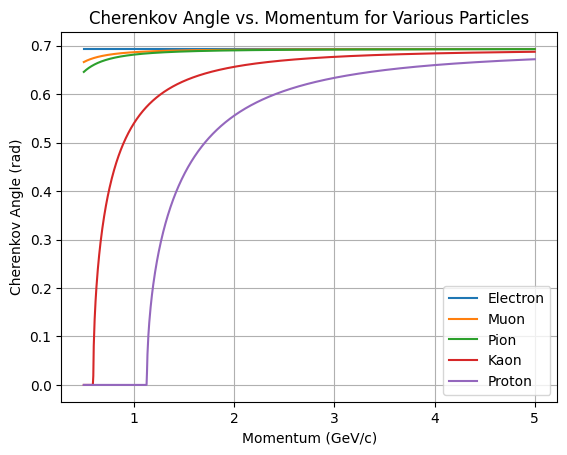

In [ ]:
p = np.linspace(.5, 5, 1000)[:, None]  # Reshape p to be a column vector for broadcasting
n = 1.3
MASS_ELECTRON = 0.000511
MASS_MUON = 0.1057
MASS_PION = 0.1396
MASS_KAON = 0.4937
MASS_PROTON = 0.9383
masses = np.array([MASS_ELECTRON, MASS_MUON, MASS_PION, MASS_KAON, MASS_PROTON])

p_lim = masses/np.sqrt(n**2 - 1)
p_squared = p ** 2
# The broadcasting here is correct, and will result in a (1000, 5) shape array
p_squared_plus_m_squared = p_squared + masses ** 2

p_mask = p > p_lim  # Broadcasting comparison
cos_theta_c_hyps = np.sqrt((p_squared_plus_m_squared)) / (p * n)
#theta_c_hyps = np.arccos(cos_theta_c_hyps)

print(f"{cos_theta_c_hyps.shape}")
theta_c_hyps = np.zeros_like(cos_theta_c_hyps)
theta_c_hyps[p_mask] = np.arccos(cos_theta_c_hyps[p_mask])
print(f"{theta_c_hyps.shape}")

import matplotlib.pyplot as plt
# Plotting
species_names = ['Electron', 'Muon', 'Pion', 'Kaon', 'Proton']
for i in range(theta_c_hyps.shape[1]):  # Loop over the number of species
    plt.plot(p.flatten(), theta_c_hyps[:, i], label=species_names[i])

plt.xlabel('Momentum (GeV/c)')
plt.ylabel('Cherenkov Angle (rad)')
plt.title('Cherenkov Angle vs. Momentum for Various Particles')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def assign_attributes_from_group(data_dict, group, key, index_particle):
    """Assign attributes from the HDF5 group to the corresponding data_dict."""
    #print(f" reading assign_attributes_from_group:  index_particle {index_particle } key {key} | FILL {group.attrs[key]}")
    data_dict[key][index_particle] = group.attrs[key]

    #assign_attributes_from_group(event_data_dict, group, key, index_in_event)

#assign_values_from_group(values_data_dict, group, key, index_particle, actual_length)

def assign_values_from_group(data_dict, group, key, index_particle, actual_length):
    """Assign values from the HDF5 group to the corresponding data_dict."""
    # print(f" reading assign_values_from_group:  index_particle {index_particle } key {key}")
    # print(f"Shape of data_dict[{key}]: {data_dict[key].shape}")
    # print(f"Shape of group[{key}]: {group[key].shape}")
    # Check if index_particle is within the bounds of the data_dict array
    if index_particle >= data_dict[key].shape[0]:
        raise ValueError(f"Index {index_particle} is out of bounds for data_dict[{key}] with shape {data_dict[key].shape}")

    # Assign the values
    try:
        data_dict[key][index_particle, :actual_length] = group[key][...]
    except Exception as e:
        #print(f"An error occurred while assigning values to data_dict[{key}]: {e}")
        raise

# assign_particle_dict(particle_dict, group, key, index_particle)


def assign_particle_dict(particle_dict, group, key, index_particle):
    #print(f" reading assign_particle_dict:  index_particle {index_particle } key {key}")
    particle_dict[key][index_particle] = group.attrs[key]


In [ ]:
from tensorflow.keras.callbacks import Callback

class GradualBatchSizeIncrease(Callback):
    def __init__(self, start_size=16, max_size=256, increase_factor=2, interval=20):
        super(GradualBatchSizeIncrease, self).__init__()
        self.batch_size = start_size
        self.max_size = max_size
        self.increase_factor = increase_factor
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0 and self.batch_size < self.max_size:
            self.batch_size = min(self.batch_size * self.increase_factor, self.max_size)
            self.model.batch_size = self.batch_size
            print(f"\nEpoch {epoch + 1}: Increasing batch size to {self.batch_size}.\n")


In [ ]:
#!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/dev_floatmap/helper_functions.py
#from helper_functions.py import print_points, plot_mapsm

In [ ]:

# Particle masses in GeV/c^2
MASS_ELECTRON = 0.000511
MASS_MUON = 0.1057
MASS_PION = 0.1396
MASS_KAON = 0.4937
MASS_PROTON = 0.9383
masses = np.array([MASS_ELECTRON, MASS_MUON, MASS_PION, MASS_KAON, MASS_PROTON])
masses = masses.reshape(1, 5)



def calc_ckov_hyp_arrays(event_data_dict):
		"""
		# Calculate the ckov hyps
		# shape : index_in_event, 5 || : 5 species
		theta_c_hyps = calc_ckov_hyp_arrays(momentums, ref_indexes)
		"""
		# fiels in event_data_dict
		#		'Momentum': np.zeros((mom_list_length, 1)),
		#		'RefractiveIndex': np.zeros((mom_list_length, 1)),
		# cos_theta_c = np.sqrt(p^2 + m^2)/(p*n)
		print(f"calc_ckov_hyp_arrays")

		CluCharge  = event_data_dict['CluCharge']#  # Flattening to 1D if necessary
		print(f" CluCharge  {CluCharge.flatten() } ")

		pdg  = event_data_dict['TrackPdg']#.flatten()  # Flattening to 1D if necessary
		print(f" pdg  {pdg.flatten()  } ")


		momentums = event_data_dict['Momentum']#.flatten()  # Flattening to 1D if necessary
		print(f" momentums {momentums.flatten()} ")

		refractive_indices = event_data_dict['RefractiveIndex']#.flatten()  # Flattening to 1D if necessary
		print(f" shape momentums {momentums.shape} | refractive_indices {refractive_indices.shape}")



		momentums = np.tile(momentums, (1, 5))
		refractive_indices = np.tile(refractive_indices, (1, 5))

		print(f" shape momentums {momentums.shape} | refractive_indices {refractive_indices.shape}")

		# to see ckov radiation per specie
		# if p > p_lim for a given specie : set mask to 0

		#print(f" refractive_indices {refractive_indices} ")

		p_lim = masses/np.sqrt(refractive_indices**2 - 1)

		masses_shaped =  np.tile(masses, (9, 1))

		#print(f"shape p_lim {p_lim.shape} | shape masses_shaped {masses_shaped.shape}")


		p_mask = momentums > p_lim
		#print(f"shape p_lim {p_lim.shape} | shape p_mask {p_mask.shape} | shape momentums {momentums.shape}")
		# the mask to check for radiation is now if p_mask is 1, if its 1 its radiation


		p_squared = momentums ** 2
		p_squared_plus_m_squared = p_squared + masses_shaped ** 2  # Broadcasting to shape (len(momentums), 5)
		#print(f"shape p_squared {p_squared.shape} | shape p_squared_plus_m_squared {p_squared_plus_m_squared.shape} ")

		# Calculate cos(theta_c) for all hypotheses
		cos_theta_c_hyps = np.sqrt(p_squared_plus_m_squared) / (momentums * refractive_indices)
		#print(f"shape p_squared {p_squared.shape} | shape cos_theta_c_hyps {cos_theta_c_hyps.shape} ")

		# Calculate theta_c from cos(theta_c)
		# Note: Where cos(theta_c) > 1 due to numerical issues, it implies no Cherenkov radiation is possible
		#
		# So we can clip the values to 1 to avoid NaNs from the arccos function

		theta_c_hyps = np.zeros_like(cos_theta_c_hyps)
		theta_c_hyps[p_mask] = np.arccos(cos_theta_c_hyps[p_mask])
		# print(f" momentums {momentums} ")
		# print(f" masses_shaped {masses_shaped} ")

		# print(f" theta_c_hyps {theta_c_hyps} ")
		# print(f" cos_theta_c_hyps {cos_theta_c_hyps} ")
		# print(f" p_mask {p_mask} ")

		return theta_c_hyps


def calc_species_prob(theta_c_hyps, sigma_ring_padded, theta_cer_padded, mip_mask):

		print(f"shape of mip_mask : {mip_mask.shape}")


		"""
		Calculate the species probability per photon per track, and also compute the
		likelihood per track and across all tracks.

		Args:
		theta_c_hyps (np.array): Cherenkov angles per species, shape (n_tracks_max, 5).
		sigma_ring_padded (np.array): Standard deviations, shape (max_length, 1).
		theta_cer_padded (np.array): Cherenkov angles, shape (max_length, 1).
		mip_mask : mask of size geq 3 AND charge geq 200



		Returns:
		tuple: A tuple containing:
				- p_specie_per_track: The probability of each species per photon per track,
															shape (n_tracks_max, max_length, 5).
				- L_track: The likelihood of each photon per track, shape (n_tracks_max, max_length).
				- L_all_tracks: The likelihood of each photon across all tracks, shape (max_length,).
		"""

		#momentums = np.tile(momentums, (1, 5))

		# Expand the dimensions of theta_c_hyps to broadcast across the max_length dimension
		theta_c_hyps_expanded = np.repeat(theta_c_hyps[:, np.newaxis, :], repeats=theta_cer_padded.shape[0], axis=1)  # (9, 550, 5)
		print(f"shape of theta_c_hyps_expanded : {theta_c_hyps_expanded.shape}")


		mip_mask = mip_mask.T
		mip_mask =  np.repeat(mip_mask[:, :, np.newaxis], repeats=theta_c_hyps.shape[1], axis=2) # shape will be (1, max_length, 1)

		print(f"shape of mip_mask : {mip_mask.shape}")


		sigma_ring_padded = sigma_ring_padded.T

		theta_cer_padded = theta_cer_padded.T
		print(f"shape of theta_cer_padded : {theta_cer_padded.shape}")


		## 		masses_shaped =  np.tile(masses, (9, 1))

		# Ensure sigma_ring_padded and theta_cer_padded are expanded to have a last dimension of 1 for broadcasting
		sigma_ring_padded_expanded =  np.repeat(sigma_ring_padded[:, :, np.newaxis], repeats=theta_c_hyps.shape[1], axis=2) # shape will be (1, max_length, 1)
		theta_cer_padded_expanded =  np.repeat(theta_cer_padded[:, :, np.newaxis], repeats=theta_c_hyps.shape[1], axis=2) # shape will be (1, max_length, 1)
		print(f"shape of theta_cer_padded_expanded : {theta_cer_padded_expanded.shape}")
		print(f"shape of sigma_ring_padded_expanded : {sigma_ring_padded_expanded.shape}")

		# Calculate the z-score
		num_tracks = sigma_ring_padded_expanded.shape[0]

		mip_mask =  np.repeat(mip_mask[:, :, :], repeats=num_tracks, axis=0) # shape will be (1, max_length, 1)
		print(f"shape of mip_mask : {mip_mask.shape}")


		theta_cer_padded_expanded =  np.repeat(theta_cer_padded[:, :, np.newaxis], repeats=theta_c_hyps.shape[1], axis=2) # shape will be (1, max_length, 1)


		#		# The shape of z will be (n_tracks, max_length, 5) after broadcasting

		#z_track_number[<number>, :] = # take sum of all other tracks
		# sum of [n_tracks, :, 5] # so sum over the 5 dimensions and the number of tracks !
		# also count the numbers
		#print(f"theta_c_hyps_expanded: {theta_c_hyps_expanded[:5,:10,:5]}")

		sigma_mask = (sigma_ring_padded_expanded > 0) & (sigma_ring_padded_expanded < 10)
		theta_mask = theta_cer_padded_expanded >= 0


		sigma_ring_padded_expanded[~sigma_mask] = 0
		theta_cer_padded_expanded[~theta_mask] = 0

		# Now z_sum_over_tracks_and_species will have the shape (max_length,)
		#print(f"theta_c_hyps_expanded: {theta_c_hyps_expanded[:5,:,:5]}")


		sigma_ring_padded_expanded = np.clip(sigma_ring_padded_expanded, 0, 0.02) #


		# shape : n_tracks x n_photons x n_species # n_species : 5
		# print(f"sigma_ring_padded_expandeds: {sigma_ring_padded_expanded[:5,:10,:5]}")
		# print(f"theta_cer_padded_expanded: {theta_cer_padded_expanded[:5,:10,:5]}")

		z = (theta_c_hyps_expanded[:num_tracks,:,:] - theta_cer_padded_expanded) / sigma_ring_padded_expanded  # Broadcasting

		# only accept +- 2 std-devs
		z_mask = (z < 2) & (z > -2)
		z[mip_mask == True] = 0

		z[z_mask == False] = 0
		print(f"shape of z-score array: {z.shape}")


		valid_counts_per_photon = np.count_nonzero(z, axis=(0, 2))
		print(f"SHAPE  Valid counts per photon: {valid_counts_per_photon.shape}")
		#print(f"Valid counts per photon:  {valid_counts_per_photon[:5]}")

		#HM = sum_i  1/(1/z_i) # harmomic mean
		# probability :
		# w_i = e^{-z_i} /(Sum_(i=1...n)e^{-z_j}) # weight

		from scipy.stats import norm
		# p-value from error-function of z-score

		#print(f"mip_mask array: {mip_mask[:5,:10,:5]}")

		#print(f"z-score array: {z[:5,:10,:5]}")

		# find related x-score med andre tracks
		p_value = norm.pdf(z)
		p_value[z_mask == False] = 0



		# sett p verdier til MIP til 0
		p_value[mip_mask == True] = 0



		#print(f"p_value-score array: {p_value[:5,:,:5]}")
		# Normalize these likelihoods to get the probability of each species within a track (p_specie)
		# (num_tracks, num_photons, num_species) -> (num_tracks, num_photons, num_species)
		p_specie_per_track = p_value / np.sum(p_value, axis=2, keepdims=True)
		#print(f"p_specie_per_track-score array: {p_specie_per_track[:5,:10,:5]}")


		# L_track : likelihood : sum of species-likelihood per track
		L_track = np.sum(p_value, axis=2)  # Shape: (num_tracks, num_photons)
		#print(f"L_track array: {L_track[:10,:5]}")

		# Sum L_track across all tracks for each photon:
		# This represents the total likelihood of each photon being part of any track
		L_all_tracks = np.sum(L_track, axis=0)  # Shape: (num_photons,)

		return p_specie_per_track, L_track, L_all_tracks

		# def	calc_species_prob(theta_c_hyps, sigma_ring_padded, theta_cer_padded)
		# 		"""
		# 				# max_length, index_in_event, 5 : probability per photon per track

		# 		"""
		# 		print(f"shape theta_c_hyps {theta_c_hyps.shape} |  sigma_ring_padded {sigma_ring_padded.shape} } |  theta_cer_padded {theta_cer_padded.shape} ")
		# 		z = (theta_c_hyps - theta_cer_padded) / sigma_ring_padded


def pad_and_stack2(sequences, max_length=None):
	try:
		# Try padding, if max_length is not None, pad or truncate to that length
		padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', dtype='float32')  # Changed dtype to 'floar32'
		#print("padded ok")
	except ValueError:
		# Fallback: manually pad with zeros
		max_len = max_length if max_length is not None else max(len(seq) for seq in sequences)
		padded_sequences = np.array([np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=0) for seq in sequences])
		#print("revert to other pad")

	return padded_sequences


def pad_and_stack3(sequences, max_length=None):
		# Check if sequences is a single numpy array and not a list of sequences.
		# If it's a single array, wrap it in a list.
		if isinstance(sequences, np.ndarray) and sequences.ndim == 1:
				sequences = [sequences]  # Wrap the single array in a list to create a list of sequences.

		try:
				# Try padding, if max_length is not None, pad or truncate to that length.
				padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', dtype='float32')  # dtype was corrected to 'float32'.
				#print("padded ok")
		except ValueError as e:
				print(f"pad_and_stack3 : ValueError: {e}")  # Print the error for debugging.
				# Fallback: manually pad with zeros if there's an error.
				max_len = max_length if max_length is not None else max(len(seq) for seq in sequences)
				padded_sequences = np.array([np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=0) for seq in sequences])
				#print("reverted to manual padding")

		if padded_sequences.shape[1] == max_length:
				padded_sequences = padded_sequences.transpose()


		return padded_sequences

import numpy as np
import numpy as np

def classify_candidates_with_pad_sequences2(other_tracks_dict, event_data_dict, values_data_dict, index_particle, index_in_event, max_length_nested):
		"""

		Dict to be filled :
		other_tracks_dict
							{
								'Momentum': np.zeros((num_particles, mom_list_length)),
										'RefractiveIndex': np.zeros((num_particles, mom_list_length)),
										'xRad': np.zeros((num_particles, mom_list_length)),
										'yRad': np.zeros((num_particles, mom_list_length)),
										'xMip': np.zeros((num_particles, mom_list_length)),
										'yMip': np.zeros((num_particles, mom_list_length)),
										'ThetaP': np.zeros((num_particles, mom_list_length)),
										'PhiP': np.zeros((num_particles, mom_list_length)),
										'CluCharge': np.zeros((num_particles, mom_list_length)),
										'CluSize': np.zeros((num_particles, mom_list_length)),
										'TrackPdg': np.zeros((num_particles, mom_list_length)),
										'ckovReconstructed': np.zeros((num_particles, mom_list_length))
								}


			# just tbs
			event_data_dict = {
					'Momentum': np.zeros((mom_list_length, 1)),
					'RefractiveIndex': np.zeros((mom_list_length, 1)),
					'xRad': np.zeros((mom_list_length, 1)),
					'yRad': np.zeros((mom_list_length, 1)),
					'xMip': np.zeros((mom_list_length, 1)),
					'yMip': np.zeros((mom_list_length, 1)),
					'ThetaP': np.zeros((mom_list_length, 1)),
					'PhiP': np.zeros((mom_list_length, 1)),
					'CluCharge': np.zeros((mom_list_length, 1)),
					'CluSize': np.zeros((mom_list_length, 1)),
					'TrackPdg': np.zeros((mom_list_length, 1)),
					'ckovReconstructed': np.zeros((mom_list_length, 1))
			}

		"""


#	classify_candidates_with_pad_sequences2(other_tracks_dict, event_data_dict, values_data_dict, index_particle, index_in_event, max_length_nested)


		# values_data_dict = {
		#     --> same for tracks :
		# 		'xValues': np.zeros((num_particles, max_length_nested)),
		# 		'yValues': np.zeros((num_particles, max_length_nested)),
		# 		'chi2Values': np.zeros((num_particles, max_length_nested)),
		# 		'qValues': np.zeros((num_particles, max_length_nested)),
		# 		'xeValues': np.zeros((num_particles, max_length_nested)),
		# 		'yeValues': np.zeros((num_particles, max_length_nested)),
		# 		'sizeClu': np.zeros((num_particles, max_length_nested))

		#     --> indivdual for tracks
		#     'candStatusValues': np.zeros((num_particles, max_length_nested)),
		# 		'phiCerValues': np.zeros((num_particles, max_length_nested)),
		# 		'thetaCerValues': np.zeros((num_particles, max_length_nested)),
		# 		'sigmaRingValues': np.zeros((num_particles, max_length_nested)),
		# }

		# Calculate the starting index for slicing


		index_start = index_particle - index_in_event

		# hvis index_in_event > 0 : pga python slicing
		index_end = index_particle + 1


		#print(f"other_tracks_dict some_key shape {np.array(other_tracks_dict['Momentum']).shape} | event_data_dict some_key shape {np.array(event_data_dict['Momentum']).shape}")
		print(f"classify_candidates_with_pad_sequences2  | : index_start: {index_start}, index_particle: {index_particle}, index_in_event: {index_in_event}")
		theta_c_hyps = calc_ckov_hyp_arrays(event_data_dict)
		print(f"theta_c_hyps {theta_c_hyps}")
		# Iterate over the keys in other_tracks_dict
		for key in other_tracks_dict:

				if key in event_data_dict:  # Check if the key exists in event_data_dict
						#other_tracks_dict[key][index_start:index_particle, :index_in_event] = event_data_dict[key]

						# Check the resulting shapes
						if index_start == index_particle and index_in_event == 0:
								# Check the shape before assignment
								#print(f"Shape of target: {other_tracks_dict[key][index_start, :].shape}")
								#print(f"Shape of data to assign: {event_data_dict[key].T.shape}")

								# Perform the assignment
								#print(f"Target slice before assignment: {other_tracks_dict[key][index_start, :]}")

								other_tracks_dict[key][index_start, :] = event_data_dict[key].T


								#print(f"To be assigned: {event_data_dict[key].T}")

								# After assignment
								#print(f"Target slice after assignment: {other_tracks_dict[key][index_start, :]}")


						elif index_start < index_particle and index_in_event > 0:
								# Check the shape before assignment
								#print(f"Shape of target: {other_tracks_dict[key][index_start:index_particle, :].shape}")
								#print(f"Shape of data to assign: {event_data_dict[key].T.shape}")

								# Perform the assignment
								#print(f"Target slice before assignment: {other_tracks_dict[key][index_start:index_particle, :]}")
								#print(f"To be assigned: {event_data_dict[key].T}")

								# Assignment operation
								other_tracks_dict[key][index_start:index_end, :] = event_data_dict[key].T

								# After assignment
								#print(f"Target slice after assignment: {other_tracks_dict[key][index_start:index_particle, :]}")
						else:
								print("Invalid indices for broadcasting.")
						# Before assignment


				else:
						print(f"Warning: Key {key} not found in event_data_dict.")

		# values_data_dict = {
		# 		'x_values': np.zeros((num_particles, max_length_nested)),
		# 		'y_values': np.zeros((num_particles, max_length_nested)),
		# 		'chi2_values': np.zeros((num_particles, max_length_nested)),
		# 		'q_values': np.zeros((num_particles, max_length_nested)),
		# 		'xe_values': np.zeros((num_particles, max_length_nested)),
		# 		'ye_values': np.zeros((num_particles, max_length_nested)),
		# 		'candStatusCkov_values': np.zeros((num_particles, max_length_nested)),
		# 		'phiCerValues': np.zeros((num_particles, max_length_nested)),
		# 		'thetaCerValues': np.zeros((num_particles, max_length_nested)),
		# 		'sigmaRingValues': np.zeros((num_particles, max_length_nested)),
		# 		'mSize_values': np.zeros((num_particles, max_length_nested))
		# }



		# Ensure x_values_data has the right dimension
		#if np.ndim(x_values_data) == 1:
		#	x_values_data = np.expand_dims(x_values_data, axis=-1)
		#print(f"classify_candidates_with_pad_sequences2 : Trying to pad values ... ")
		auto = values_data_dict['x_values'][index_start, :]
		x_padded, y_padded, q_padded, size_padded = (np.zeros((max_length_nested, 1)) for _ in range(4))
		#print(f"x_padded shape : {x_padded.shape}")
		#print(f"index_start: {index_start}, index_particle: {index_particle}, index_in_event: {index_in_event}")

		# Pad the sequences
		# these fields should be the same for all tracks from index_start to index_particle
		#print(f"Trying to pad : {values_data_dict['x_values'][index_start, :].shape}")

		x_padded = pad_and_stack3(values_data_dict['x_values'][index_start, :], max_length=max_length_nested)
		y_padded = pad_and_stack3(values_data_dict['x_values'][index_start, :], max_length=max_length_nested)
		q_padded = pad_and_stack3(values_data_dict['q_values'][index_start, :], max_length=max_length_nested)
		size_padded = pad_and_stack3(values_data_dict['mSize_values'][index_start, :], max_length=max_length_nested)


		#print(f"shape x_padded {x_padded.shape}")
		# print(f"shape y_padded {y_padded.shape}")
		# print(f"shape q_padded {q_padded.shape}")


		if index_in_event > 0:
				#print(f"Trying to pad : candStatus_padded {values_data_dict['candStatusCkov_values'][index_start:index_particle, :].shape}")


				print(f"candStatus_padded ")
				candStatus_padded = np.zeros((max_length_nested, index_in_event))
				print(f"candStatus_padded pad_and_stack3 ")

				candStatus_padded = pad_and_stack3(values_data_dict['candStatusCkov_values'][index_start:index_end, :], max_length=max_length_nested).astype(int)
				print(f"phi_cer_padded pad_and_stack3 ")

				phi_cer_padded = pad_and_stack3(values_data_dict['phiCerValues'][index_start:index_end, :], max_length=max_length_nested)
				print(f"theta_cer_padded pad_and_stack3 ")


				theta_cer_padded = pad_and_stack3(values_data_dict['thetaCerValues'][index_start:index_end, :], max_length=max_length_nested)

				print(f"sigma_ring_padded pad_and_stack3 ")

				sigma_ring_padded = pad_and_stack3(values_data_dict['sigmaRingValues'][index_start:index_end, :], max_length=max_length_nested)



				# for key in event_data_dict:
				#     print(f"event_data_dict : key : {key} { event_data_dict[key].flatten() }")


		else :
				print(f"candStatus_padded pad_and_stack3 ")

				#print(f"Trying to pad : candStatus_padded {values_data_dict['candStatusCkov_values'][index_start, :].shape}")
				candStatus_padded = np.zeros((max_length_nested, 1))

				print(f"candStatus_padded pad_and_stack3 ")


				# print(f"Trying to pad : candStatus_padded {values_data_dict['candStatus_padded'][index_start, :].shape}")



				candStatus_padded = pad_and_stack3(values_data_dict['candStatusCkov_values'][index_start, :], max_length=max_length_nested).astype(int)

				print(f"phi_cer_padded = event_data3 ")

				phi_cer_padded = pad_and_stack3(values_data_dict['phiCerValues'][index_start, :], max_length=max_length_nested)
				print(f"theta_cer_padded = event_data3 ")


				theta_cer_padded = pad_and_stack3(values_data_dict['thetaCerValues'][index_start, :], max_length=max_length_nested)

				print(f"sigma_ring_padded = event_data3 ")

				sigma_ring_padded = pad_and_stack3(values_data_dict['sigmaRingValues'][index_start, :], max_length=max_length_nested)
				print(f"size = event_data3 ")



		# check if MIP
		mip_mask_condition = (q_padded >= 200) & (size_padded >= 3)

		num_features = 7 # added phi theta sigma

		num_dims = candStatus_padded.shape[1]
		#print(f"num_dims num_dims {num_dims}")
		print(f"shape candStatus_padded {candStatus_padded.shape}")

		if num_dims != 1:

			condition_broadcasted = np.tile(mip_mask_condition, (1, num_dims))


			print(f"shape candStatus_padded {candStatus_padded.shape}")

			high_charge_size = np.zeros_like(candStatus_padded)
			high_charge_size[condition_broadcasted] = 1
			candStatus_padded[condition_broadcasted] = 1

			x_padded = np.tile(x_padded, (1, num_dims))
			y_padded = np.tile(y_padded, (1, num_dims))
			q_padded = np.tile(q_padded, (1, num_dims))
			size_padded = np.tile(size_padded, (1, num_dims))

			print(f"shape candStatus_padded {candStatus_padded.shape}")

		else :
			high_charge_size = np.zeros_like(candStatus_padded)
			high_charge_size[mip_mask_condition] = 1
			candStatus_padded[mip_mask_condition] = 1


		#candStatus_padded = pad_and_stack(candStatus_values_data, max_length=max_length_nested).astype(int)

		# ef : store info of high charge/size clusters to learn patterns about Feedback?
		#	candStatus_padded[(q_padded >= 150) & (size_padded >= 3)] = 1

	  # also use these to filter out other MIPs (also the ones that is not matched with track)



		# Modify candStatus based on charge and size threshold
		# candStatus_padded[outside_fiducial_zones] = 0

		# Define masks for different particle statuses
		proton_values = [2, 4, 6, 8]
		kaon_values = [3, 5, 7, 8]
		pion_values = [5, 6, 7, 8]


		#print(f"shape candStatus_padded {candStatus_padded.shape}")

		proton_mask = np.isin(candStatus_padded, proton_values)
		proton_mask = np.tile(proton_mask[:, :, np.newaxis], (1, 1, num_features))

		kaon_mask = np.isin(candStatus_padded, kaon_values)
		kaon_mask = np.tile(kaon_mask[:, :, np.newaxis], (1, 1, num_features))


		pion_mask = np.isin(candStatus_padded, pion_values)
		pion_mask = np.tile(pion_mask[:, :, np.newaxis], (1, 1, num_features))

		#print(f"shape protonmask {proton_mask.shape}")

		# Stack the data into a single array
		print(f"x_padded shape {x_padded.shape}")
		print(f"sigma_ring_padded shape {sigma_ring_padded.shape}")



		# Calculate the ckov hyps
		# shape : index_in_event, 5 || : 5 species

		# print(f"sigma_ring_padded shape {sigma_ring_padded.shape}")

		# q_padded_flat = q_padded.flatten()
		# fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

		# # First histogram (original data)
		# axs[0].hist(q_padded_flat, range=(1, 1000), bins=30, alpha=0.7, color='blue')
		# axs[0].set_title('Histogram of q_padded')
		# axs[0].set_xlabel('Value')
		# axs[0].set_ylabel('Frequency')

		# # Apply conditions for the second histogram
		# q = q_padded.copy()
		# if num_dims != 1:
		# 		q[condition_broadcasted == False] = 0
		# else:
		# 		q[mip_mask_condition == False] = 0

		# q_flat = q.flatten()

		# # Second histogram (conditioned data)
		# axs[1].hist(q_flat, range=(10, 1000), bins=30, alpha=0.7, color='blue')
		# axs[1].set_title('Histogram of q after conditions applied')
		# axs[1].set_xlabel('Value')
		# axs[1].set_ylabel('Frequency')
		# plt.show()


		# plt.hist(size_padded.flatten(), bins=13, alpha=0.7, color='blue')  # Adjust the number of bins as needed
		# plt.title('Histogram of size_padded')
		# plt.xlabel('Value')
		# plt.ylabel('Frequency')

		# # Show the plot
		# plt.show()


		# plt.hist(theta_cer_padded.flatten(),range = (0.1,0.9), bins=50, alpha=0.7, color='blue')  # Adjust the number of bins as needed
		# plt.title('Histogram of theta_cer_padded')
		# plt.xlabel('Value')
		# plt.ylabel('Frequency')

		# # Show the plot
		# plt.show()

		# fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

		# # Plot histogram for range -3.14 to -0.01
		# axs[0].hist(phi_cer_padded.flatten(), range=(-3.14, -0.01), bins=157, alpha=0.7, color='blue')
		# axs[0].set_title('Histogram of phi_cer_padded (-3.14 to -0.01)')
		# axs[0].set_xlabel('Value')
		# axs[0].set_ylabel('Frequency')

		# # Plot histogram for range 0.01 to 3.14
		# axs[1].hist(phi_cer_padded.flatten(), range=(0.01, 3.14), bins=157, alpha=0.7, color='blue')
		# axs[1].set_title('Histogram of phi_cer_padded (0.01 to 3.14)')
		# axs[1].set_xlabel('Value')
		# axs[1].set_ylabel('Frequency')
		# plt.show()




		# # Second histogram (conditioned data)
		# plt.hist(sigma_ring_padded.flatten(), range=(0.001, 0.025), bins=200, alpha=0.7, color='blue')
		# plt.title('Histogram of sigma_ring_padded')
		# plt.xlabel('Value')
		# plt.ylabel('Frequency')
		# plt.show()


		print(f"sending momentum {event_data_dict['Momentum'].flatten()}")


		# hypothetical ckov values #Shape = num_tracks x num_species
		theta_c_hyps = calc_ckov_hyp_arrays(event_data_dict)

		print(f"probs_species = calc_species_prob(theta_c_hyps, sigma_ring_padded, theta_cer_padded)")

		print(f"theta_c_hyps shape {theta_c_hyps.shape}")
		print(f"sigma_ring_padded shape {sigma_ring_padded.shape}")

		# max_length, index_in_event, 5 : probability per photon per track
		p_specie_per_track, L_track, L_all_tracks = calc_species_prob(theta_c_hyps, sigma_ring_padded, theta_cer_padded, mip_mask_condition)


		print(f"q_padded shape {q_padded.shape}")

		#print(f"q_padded shape {q_padded[:50,:]}")

		# max_length : padded, number of photons
		# - p_specie_per_track: The probability of each species per photon per track,
		#                       shape (n_tracks_max, max_length, 5).
		# - L_track: The likelihood of each photon per track, shape (n_tracks_max, max_length).
		# - L_all_tracks: The likelihood of each photon across all tracks, shape (max_length,).




		# find sum of z_score of all other tracks-spedies for the given photon in the track
		# also find number of tracks-species



		# num_photons, num_tracks, 7
		padded_data = np.stack([x_padded, y_padded, q_padded, size_padded, phi_cer_padded, theta_cer_padded, sigma_ring_padded], axis=-1)
		print(f"padded_data shape {padded_data.shape}")


		# lefthere : disse skal stores
		#p_specie_per_track # (n_tracks_max, max_length, n_speciesx)
		# L_track # (n_tracks_max, max_length)
		#theta_c_hyps # (n_tracks_max, n_speciesx)
		# L_all_tracks:(max_length,).
		# event_data_dict --: track info of all matches per event (mom_list_length, 1)
		# high_charge_size -- padded_data2 # (n_tracks_max, max_length, 4)

		L_all_tracks

		print(f"theta_c_hyps shape {theta_c_hyps.shape}")
		print(f"p_specie_per_track shape {p_specie_per_track.shape}")
		print(f"L_track shape {L_track.shape}")
		print(f"L_all_tracks shape {L_all_tracks.shape}")


		high_charge_size = high_charge_size
		high_charge_size = high_charge_size[:,:, np.newaxis]
		print(f"high_charge_size shape {high_charge_size.shape}") # (550, 2)


		padded_data2 = np.stack([x_padded, y_padded, q_padded, size_padded], axis=-1)
		print(f"padded_data2 shape {padded_data2.shape}") # (550, 2)


		high_charge_size_exp = np.tile(high_charge_size, (1, 1, 4))

		padded_data2[high_charge_size_exp==False] = 0

		print(f"padded_data shape {padded_data2.shape}")


		# må regne ut :
		# per index_start:index_particle : "normalisert" e.l. sannsylighet per specie:
		# for hver track:
		# 	hver photon:
		# 		z_specie = (eta_c - ckov_hyp_specie)/sigma # eta_c sigma for photon
		#
		#

		#print(f"managed to pad...")

		#print(f"shape padded_data {padded_data.shape}")


		# if num_dims != 1:
		# 	padded_data = np.tile(padded_data[:, :, np.newaxis], (1, num_dims, 1))

		#print(f"shape padded_data {padded_data.shape}")

		# Create masks for positive and non statuses
		positive_mask = (candStatus_padded > 0).astype(bool)
		#print(f"shape positive_mask {positive_mask.shape}")

		positive_mask = np.repeat(positive_mask[:, :, np.newaxis], num_features, axis=2)

		print(f"positive_mask shape {positive_mask.shape}")

		#print(f"shape positive_mask {positive_mask.shape}")

		non_mask = (candStatus_padded <= 1).astype(bool)
		non_mask = np.repeat(non_mask[:, :, np.newaxis], num_features, axis=2)

		# Populate particle candidates arrays
		pion_candidates = np.zeros_like(padded_data)
		kaon_candidates = np.zeros_like(padded_data)
		proton_candidates = np.zeros_like(padded_data)
		non_candidates = np.zeros_like(padded_data)

		pion_candidates[positive_mask & pion_mask] = padded_data[positive_mask & pion_mask]
		kaon_candidates[positive_mask & kaon_mask] = padded_data[positive_mask & kaon_mask]
		proton_candidates[positive_mask & proton_mask] = padded_data[positive_mask & proton_mask]
		non_candidates[non_mask] = padded_data[non_mask]

		return pion_candidates, kaon_candidates, proton_candidates, non_candidates, candStatus_padded


In [ ]:


from tensorflow.keras.callbacks import EarlyStopping

# create a callback
early_stopping = EarlyStopping(
	monitor='val_loss', # you can monitor 'val_loss' or 'val_accuracy'
	patience=20, # stop training if the monitored quantity does not improve for 50 epochs
	restore_best_weights=True, # restore model weights from the epoch with the best value
)

!git clone https://<TOKEN>@github.com/eflatlan/CNN_PID.git

!wget -O ParticleDataUtilsCp.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/ParticleDataUtils36.py
from ParticleDataUtilsCp import ParticleDataUtils, classify_candidates_with_pad_sequences

!git clone https://<TOKEN>@github.com/eflatlan/CNN_PID.git

!wget -O ParticleDataUtilsCp.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/ParticleDataUtils36.py
from ParticleDataUtilsCp import ParticleDataUtils, classify_candidates_with_pad_sequences

!wget -O misc_helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions8.py
from misc_helper_functions import build_species_layers, build_species_layers2, calculate_theta, filter_data, create_lr_scheduler,plot_lr, extract_neighborhood_map, create_cnn_model # plot_worst



# from plot_helper_functions import plot_hist

# from plot_helper_functions import plot_training_history
#from plot_helper_functions import plot_training_history#, plot_dist2mip_histograms, plot_maps


print(classify_candidates_with_pad_sequences)


/bin/bash: line 1: TOKEN: No such file or directory
--2023-11-13 16:09:03--  https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/ParticleDataUtils36.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21728 (21K) [text/plain]
Saving to: ‘ParticleDataUtilsCp.py’

ParticleDataUtilsCp 100%[===================>]  21.22K  --.-KB/s    in 0.002s  

2023-11-13 16:09:03 (13.1 MB/s) - ‘ParticleDataUtilsCp.py’ saved [21728/21728]

1000
/bin/bash: line 1: TOKEN: No such file or directory
--2023-11-13 16:09:04--  https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/ParticleDataUtils36.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com 

In [175]:

# create a callback
early_stopping = EarlyStopping(
    monitor='val_loss', # you can monitor 'val_loss' or 'val_accuracy'
    patience=100, # stop training if the monitored quantity does not improve for 50 epochs
    restore_best_weights=True, # restore model weights from the epoch with the best value
)

from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

import numpy as np

import numpy as np
MASS_PION = 0.1396
MASS_KAON = 0.4937
MASS_PROTON = 0.938

# Squared masses
MASS_PION_SQ = MASS_PION * MASS_PION
MASS_KAON_SQ = MASS_KAON * MASS_KAON
MASS_PROTON_SQ = MASS_PROTON * MASS_PROTON
REF_INDEX_FREON = 1.29  # Given refraction index
REF_INDEX_FREON_SQ = REF_INDEX_FREON * REF_INDEX_FREON

def threshold_momentum(pdg_code, p):
	"""
	Calculate the threshold momentum based on the given PDG code.

	:param pdg_code: PDG code of the particle.
	p : momentum of track
	(tbd : refindex)

	:return : boolean value for Cherenkov radiation.
	"""

	# Determine mass based on PDG code
	if abs(pdg_code) == 211:
		mass = MASS_PION
	elif abs(pdg_code) == 321:
		mass = MASS_KAON
	elif abs(pdg_code) == 2212:
		mass = MASS_PROTON
	else:
		raise ValueError(f"Unsupported PDG code: {pdg_code}")

	p_lim = mass/(np.sqrt(REF_INDEX_FREON_SQ-1))
	#print(f" p_lim {p_lim} p {p}")
	return p_lim < p



def pad_and_stack(sequences, max_length=None):
	# Your existing code
	try:
		# Try padding, if max_length is not None, pad or truncate to that length
		padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', dtype='float32')  # Changed dtype to 'floar32'
	except ValueError:
		# Fallback: manually pad with zeros
		max_len = max_length if max_length is not None else max(len(seq) for seq in sequences)
		padded_sequences = np.array([np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=0) for seq in sequences])

	return padded_sequences


def count_non_zero_charges_vectorized(datasets):
	return [np.count_nonzero(data[:, :, 3], axis=1) for data in datasets]

import numpy as np
import numpy as np

def classify_candidates_with_pad_sequences(x_values_data, y_values_data, q_values_data, mCluSize_lista, candStatus_values_data, max_length_nested, xmip_list, ymip_list, phiCervalues_lst_data_list, sigmaRing_lst_data_list, thetaCervalues_lst_data_list, ckovhough_list):

	# x_values_data shape: (4064, 550)

	print("x_values_data shape:", x_values_data.shape)
	print("y_values_data shape:", y_values_data.shape)
	print("q_values_data shape:", q_values_data.shape)
	print("mCluSize_lista shape:", mCluSize_lista.shape)
	print("candStatus_values_data shape:", candStatus_values_data.shape)
	print("max_length_nested:", max_length_nested)  # assuming this is a single value, not an array
	print("xmip_list shape:", xmip_list.shape)
	print("ymip_list shape:", ymip_list.shape)
	print("phiCervalues_lst_data_list shape:", phiCervalues_lst_data_list.shape)
	print("sigmaRing_lst_data_list shape:", sigmaRing_lst_data_list.shape)
	print("thetaCervalues_lst_data_list shape:", thetaCervalues_lst_data_list.shape)
	print("ckovhough_list shape:", ckovhough_list.shape)

	"""Classify the candidates based on the candidate_status
			Returns : pion - NumSamples x padded_length x 5 |
							  kaon
								proton
								none

	"""
	# TODO:
	# add matching w other tracks / photons in same chamber for the given event
	# add total "probability" of the zones in other tracks + other species



	print(f"classify_candidates_with_pad_sequences : x_values_data shape {x_values_data.shape}")
	non_zero_counts = np.count_nonzero(x_values_data, axis=1)
	unique_lengths = np.unique(non_zero_counts)

	first_elements_x = x_values_data[:, 0]
	unique_x = np.unique(first_elements_x)
	num_unique_x = len(unique_x)


	first_elements_y = y_values_data[:, 0]
	unique_y = np.unique(first_elements_y)
	num_unique_y = len(unique_y)

	first_elements_q = q_values_data[:, 0]
	unique_q = np.unique(first_elements_q)
	num_unique_q = len(unique_q)

	unique_lengths = np.unique(non_zero_counts)

	num_unique_lengths = len(unique_lengths)



	print(f"classify_candidates_with_pad_sequences : num_unique_lengths shape {num_unique_lengths}")
	print(f"classify_candidates_with_pad_sequences : unique_x shape {num_unique_x}")
	print(f"classify_candidates_with_pad_sequences : unique_y shape {num_unique_y}")
	print(f"classify_candidates_with_pad_sequences : unique_q shape {num_unique_q}")



	# classify_candidates_with_pad_sequences : x_values_data shape (750, 610)
	#non_zero_charges = np.count_nonzero(x_values_data[idx, :, 3])

  #num_candidates_per_event = x_values_data

	# Ensure x_values_data has the right dimension
	if np.ndim(x_values_data) == 1:
		x_values_data = np.expand_dims(x_values_data, axis=-1)

	# Pad the sequences

	max_length_nested = 1100
	x_padded = pad_and_stack(x_values_data, max_length=max_length_nested)
	y_padded = pad_and_stack(y_values_data, max_length=max_length_nested)
	q_padded = pad_and_stack(q_values_data, max_length=max_length_nested)
	size_padded = pad_and_stack(mCluSize_lista, max_length=max_length_nested)
	candStatus_padded = pad_and_stack(candStatus_values_data, max_length=max_length_nested).astype(int)

	# Modify candStatus based on charge and size threshold
	candStatus_padded[(q_padded >= 150) & (size_padded >= 3)] = 1
	# candStatus_padded[outside_fiducial_zones] = 0

	# Define masks for different particle statuses
	proton_values = [2, 4, 6, 8]
	kaon_values = [3, 4, 7, 8] # 3,5,7,8 ??
	pion_values = [5, 6, 7, 8]




	proton_mask = np.isin(candStatus_padded, proton_values)
	kaon_mask = np.isin(candStatus_padded, kaon_values)
	pion_mask = np.isin(candStatus_padded, pion_values)

	# Stack the data into a single array
	padded_data = np.stack([x_padded, y_padded, q_padded, size_padded], axis=-1)

	## ef added : 26/10
	# Stack the data into a single array
	padded_data = np.stack([x_padded, y_padded, q_padded, size_padded, candStatus_padded], axis=-1)

	# Create masks for positive and non statuses
	positive_mask = (candStatus_padded > 1).astype(bool)
	non_mask = (candStatus_padded <= 1).astype(bool)

	# Populate particle candidates arrays
	pion_candidates = np.zeros_like(padded_data)
	kaon_candidates = np.zeros_like(padded_data)
	proton_candidates = np.zeros_like(padded_data)
	non_candidates = np.zeros_like(padded_data)
	pion_candidates[positive_mask & pion_mask] = padded_data[positive_mask & pion_mask]
	kaon_candidates[positive_mask & kaon_mask] = padded_data[positive_mask & kaon_mask]
	proton_candidates[positive_mask & proton_mask] = padded_data[positive_mask & proton_mask]



	non_candidates[non_mask] = padded_data[non_mask]

	return pion_candidates, kaon_candidates, proton_candidates, non_candidates, candStatus_padded

import random


from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

import sys

print(sys.getrecursionlimit()) # Prints 1000

print_vals = False
from numpy.linalg import norm
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_recall_curve, confusion_matrix

from scipy.signal import find_peaks

import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, Lambda, Flatten, Dense, concatenate, BatchNormalization, MaxPooling2D, Dropout, LeakyReLU, Masking, Embedding

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt




class Constants:
	PION_MASS = 0.1396
	KAON_MASS = 0.4937
	PROTON_MASS = 0.938

np.set_printoptions(precision=4)

@staticmethod
def calculate_mass(momentum, refractiveIndex, ckov):
	""" args : momentum, refractiveIndex, ckov
		returns : mass
	"""
	mass = momentum * np.sqrt((refractiveIndex * np.cos(ckov))**2 - 1)
	return mass


class ParticleDataUtils:

	def __init__(self, filenames =  [], percentage_to_read = 100):
		self.filename = filenames
		self.percentage_to_read = percentage_to_read
		self.particle_vector = []
		self.load_data(filenames=filenames)

		#
		# jeg flyttet
		self.particle_info = self.process_data(self.particle_vector, self.percentage_to_read)
		self.num_particles = len(self.particle_info)


		# new scalers to be created :
		self.phi_scaler, self.phi_stats = self.create_scalar_scaler("phiP")
		self.theta_scaler, self.theta_stats = self.create_scalar_scaler("thetaP")
		self.refractive_index_scaler, self.refractive_index_stats = self.create_scalar_scaler("refractiveIndex")
		self.momentum_scaler, self.momentum_stats = self.create_scalar_scaler("momentum")
		self.mCluSize_scaler, self.mCluSize_stats = self.create_scalar_scaler("mCluSize")
		self.mCluCharge_scaler, self.mCluCharge_stats = self.create_scalar_scaler("mCluCharge")
		print("Created scaler for scalars")

		# 2D
		self.mip_scaler, self.mip_stats = self.create_2D_scaler("mip_position")
		self.rad_scaler, self.rad_stats = self.create_2D_scaler("rad_position")

		# # vector of 2D
		self.proton_scalers, self.proton_stats = self.create_vector_scaler("proton_candidates")
		self.kaon_scalers, self.kaon_stats = self.create_vector_scaler("kaon_candidates")
		self.pion_scalers, self.pion_stats = self.create_vector_scaler("pion_candidates")



		#self.ckov_scaler, self.ckov_stats = self.create_scaler("ckov")
		#self.distances_scaler, self.distances_stats = self.create_scaler("distances")def classify_candidates(candidates_data):


	class Candidate2:
		def __init__(self, x_values, y_values, chi2_values, q_values, xe_values, ye_values, candStatus_values):
			self.x_values = x_values
			self.y_values = y_values
			self.chi2_values = chi2_values
			self.q_values = q_values
			self.xe_values = xe_values
			self.ye_values = ye_values
			self.candStatus_values = candStatus_values


	class ParticleInfo: # p
		def __init__(self,  momentum, refractiveIndex, xRad, yRad, xMIP, yMIP, thetaP, phiP, mCluCharge, mCluSize, non_candidates, pion_candidates, kaon_candidates, proton_candidates, mTrackPdg, index, pion_flag, kaon_flag, proton_flag):
			self.momentum = momentum # this dhould be with
			self.refractiveIndex = refractiveIndex # with
			self.xRad = xRad # with
			self.yRad = yRad # with

			self.xMIP = xMIP # with
			self.yMIP = yMIP # with

			self.mCluCharge = mCluCharge # with
			self.mCluSize = mCluSize # with

			self.thetaP = thetaP# with
			self.phiP = phiP# with
			self.non_candidates = non_candidates # with the field candStatus is a int that is 0..7, please make it categorical
			self.rad_position = [xRad, yRad]
			self.mip_position = [xMIP, yMIP]


			self.pion_candidates = pion_candidates # pion_candidates = [1 if (int(candStatus) & 4) == 4 else 0 for candStatus in candsCombined]
			self.kaon_candidates = kaon_candidates # = kaon_candidates [1 if (int(candStatus) & 2) == 2 else 0 for candStatus in candsCombined]
			self.proton_candidates = proton_candidates # = proton_candidates[1 if (int(candStatus) & 1) == 1 else 0 for candStatus in candsCombined]


			self.pion_flag = pion_flag # pion_candidates = [1 if (int(candStatus) & 4) == 4 else 0 for candStatus in candsCombined]
			self.kaon_flag = kaon_flag # = kaon_candidates [1 if (int(candStatus) & 2) == 2 else 0 for candStatus in candsCombined]
			self.proton_flag = proton_flag # = proton_candidates[1 if (int(candStatus) & 1) == 1 else 0 for candStatus in candsCombined]

			self.mTrackPdg = mTrackPdg # with
			self.index_particle = index # with

			abs_mTrackPdg = abs(self.mTrackPdg)  # Take the absolute value

			# Set particleType based on absolute PDG code
			if abs_mTrackPdg == 211:
				self.particleType = 211#'pion'
			elif abs_mTrackPdg == 321:
				self.particleType = 321#'kaon'
			elif abs_mTrackPdg == 2212:
				self.particleType = 2212#'proton'
			else:
				self.particleType = -1
				#print(f"pdg type was other : {abs_mTrackPdg}")


		@staticmethod
		def infer_mass_category_from_ckov(momentum, refractiveIndex, ckov):
			mass = momentum * np.sqrt((refractiveIndex * np.cos(ckov))**2 - 1)

			mass_category = "unk_nown"
			if abs(mass - Constants.PION_MASS) < 1e-4:
				mass_category = "pion"
			elif abs(mass - Constants.KAON_MASS) < 1e-4:
				mass_category = "kaon"
			elif abs(mass - Constants.PROTON_MASS) < 1e-4:
				mass_category = "proton"
			if print_vals:
			  print(f"\ninfer_mass_category_from_ckov :  momentum = {momentum}|  mass_calc = {mass} |  mass_category={mass_category} | refractiveIndex = {refractiveIndex} | ckov = {ckov}")
			return mass_category

		@staticmethod
		def infer_mass_category(mass):
			if abs(mass - Constants.PION_MASS) < 1e-6:
				return "pion"
			elif abs(mass - Constants.KAON_MASS) < 1e-6:
				return "kaon"
			elif abs(mass - Constants.PROTON_MASS) < 1e-6:
				return "proton"
			else:
				return "unk_nown"

		def __str__(self):
			if print_vals:
			  return (f"ParticleInfo(momentum={self.momentum} | mass={self.mass} |  mass_category={self.mass_category} | "
					  f"refractiveIndex={self.refractiveIndex} | ckov={self.ckov} | rad_position={len(self.rad_position)}, "
					  f"mip_position={self.mip_position})")

	#  ''' def calculate_distances_to_mip(self):
	#       """Calculate Euclidean distances from all filled bins to MIP position"""
	#       filledBins_np = np.array(self.filledBins)
	#       mip_position_np = np.array(self.mip_position)

	#       distances = np.linalg.norm(filledBins_np - mip_position_np, axis=1)
	#       return distances'''


	def load_data(self, filenames):
			drive_path = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/'

			num_equal = 0
			num_particles = 0
			file_num = 0
			num_equal = 0
			mom_list_length = 0
			max_length_nested = 0
			n_events = 0
			for filename in filenames:
					file_path = os.path.join(drive_path, filename)
					lengths = []
					num_equals = []
					with h5py.File(file_path, 'r') as file:
							print(f"Reading file {filename}")

							group_names = list(file.keys())  # Get all group names
							i = 0  # Initialize loop counter

							while i < len(group_names):
									# Process the current track
									group_name = group_names[i]
									group = file[group_name]
									print(f"i {i} reading group {group_name}")

									t = group['y_values'][...]
									y1 = t[0]
									current_length = len(group['ye_values'][...])

									# Initialize for the next loop
									i += 1
									end_condition = False
									num_equal = 1  # Initialize with 1 since we have processed one group
									lengths.append(current_length)
									num_particles += 1
									while not end_condition and i < len(group_names):
											# Check for other tracks in the same event
											next_group_name = group_names[i]
											next_group = file[next_group_name]
											t_next = next_group['y_values'][...]
											y1_next = t_next[0]


											if (len(next_group['ye_values'][...]) == current_length) and (y1_next == y1):
													# Tracks are in the same event
													num_equal += 1
													i += 1  # Move to next track
													num_particles += 1

													lengths.append(len(next_group['ye_values'][...]))
											else:
													# Tracks are not in the same event
													if num_equal > mom_list_length:
															mom_list_length = num_equal
													end_condition = True
													n_events += 1
											if len(next_group['ye_values'][...]) > max_length_nested:
													max_length_nested = len(next_group['ye_values'][...])
									num_equals.append(num_equal)



									# Update variables for next iteration
									prev_length = current_length
									y_prev = y1

					#print(f"num_equals :  {num_equals[:30]}")
					# plt.hist(num_equals, bins='auto', edgecolor='black')
					# plt.xlabel('Length')
					# plt.ylabel('Frequency')
					# plt.title('Histogram of Lengths')
					# plt.show()

					# plt.hist(lengths, np.max(lengths), edgecolor='black')
					# plt.xlabel('lengths')
					# plt.ylabel('lengths')
					# plt.title('Histogram of lengths')
					# plt.show()

			print(f"==================== Finisyhed LOOP ===============")

			# Lists to store scalar and array-like attributes

			event_data_dict_dtype2 = np.dtype({
					'names': ['Momentum', 'RefractiveIndex', 'xRad', 'yRad', 'xMip', 'yMip', 'ThetaP', 'PhiP', 'CluCharge', 'CluSize', 'TrackPdg', 'ckovReconstructed'],
					'formats': [np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.int32, np.bool_],
					'shapes': [(mom_list_length, 1)] * 12
			})

			print(f"==================== Finisyhed all_events_data_dtype ===============")


			all_events_data_dtype = np.dtype([
					('p_specie_per_track', float, (mom_list_length, max_length_nested, 5)),
					('L_track', float, (mom_list_length, max_length_nested)),
					('L_all_tracks', float, (max_length_nested, )),
					('padded_data', float, (mom_list_length, max_length_nested, 7)),
					('high_charge_size', float, (mom_list_length, 1, 4)),
					('event_data_dict', event_data_dict_dtype2, (1,)),  # This adds event_data_dict as a sub-array
			])

			all_events_data = np.zeros(n_events, dtype=all_events_data_dtype)

			# these holds the info for a track to be reconstricted
			particle_dict = {
					'Momentum': np.zeros((num_particles, 1)),
					'RefractiveIndex': np.zeros((num_particles, 1)),
					'xRad': np.zeros((num_particles, 1)),
					'yRad': np.zeros((num_particles, 1)),
					'xMip': np.zeros((num_particles, 1)),
					'yMip': np.zeros((num_particles, 1)),
					'ThetaP': np.zeros((num_particles, 1)),
					'PhiP': np.zeros((num_particles, 1)),
					'CluCharge': np.zeros((num_particles, 1)),
					'CluSize': np.zeros((num_particles, 1)),
					'TrackPdg': np.zeros((num_particles, 1)),
					'ckovReconstructed': np.zeros((num_particles, 1)),

			}



			# må gjøres i loop
			other_tracks_dict = {
					'Momentum': np.zeros((num_particles, mom_list_length)),
					'RefractiveIndex': np.zeros((num_particles, mom_list_length)),
					'xRad': np.zeros((num_particles, mom_list_length)),
					'yRad': np.zeros((num_particles, mom_list_length)),
					'xMip': np.zeros((num_particles, mom_list_length)),
					'yMip': np.zeros((num_particles, mom_list_length)),
					'ThetaP': np.zeros((num_particles, mom_list_length)),
					'PhiP': np.zeros((num_particles, mom_list_length)),
					'CluCharge': np.zeros((num_particles, mom_list_length)),
					'CluSize': np.zeros((num_particles, mom_list_length)),
					'TrackPdg': np.zeros((num_particles, mom_list_length)),
					'ckovReconstructed': np.zeros((num_particles, mom_list_length))
			}



			# np arrs holding attributes per event

			# denne er ok



			# these holds the values per event individiually


			# denne er ok
			values_data_dict = {
					'x_values': np.zeros((num_particles, max_length_nested)),
					'y_values': np.zeros((num_particles, max_length_nested)),
					'chi2_values': np.zeros((num_particles, max_length_nested)),
					'q_values': np.zeros((num_particles, max_length_nested)),
					'xe_values': np.zeros((num_particles, max_length_nested)),
					'ye_values': np.zeros((num_particles, max_length_nested)),
					'candStatusCkov_values': np.zeros((num_particles, max_length_nested)),
					'phiCerValues': np.zeros((num_particles, max_length_nested)),
					'thetaCerValues': np.zeros((num_particles, max_length_nested)),
					'sigmaRingValues': np.zeros((num_particles, max_length_nested)),
					'mSize_values': np.zeros((num_particles, max_length_nested))
			}

			draw_something2212 = {
					'thetaCerValues': np.zeros((num_particles, max_length_nested)),
					'sigmaRingValues': np.zeros((num_particles, max_length_nested)),
					'ckovReconstructed': np.zeros((num_particles, 1)),
					'CluSize': np.zeros((num_particles, 1)),
					'CluCharge': np.zeros((num_particles, 1))
			}

			draw_something321 = {
					'thetaCerValues': np.zeros((num_particles, max_length_nested)),
					'sigmaRingValues': np.zeros((num_particles, max_length_nested)),
					'ckovReconstructed': np.zeros((num_particles, 1)),
					'CluSize': np.zeros((num_particles, 1)),
					'CluCharge': np.zeros((num_particles, 1))
			}

			draw_something = {
					'thetaCerValues': np.zeros((num_particles, max_length_nested)),
					'sigmaRingValues': np.zeros((num_particles, max_length_nested)),
					'ckovReconstructed': np.zeros((num_particles, 1)),
					'CluSize': np.zeros((num_particles, 1)),
					'CluCharge': np.zeros((num_particles, 1))
			}


			index_particle = 0

			def list_all_keys(h5_group, prefix=''):
				keys = []
				for key in h5_group:
						current_key = f"{prefix}/{key}"
						keys.append(current_key)
						if isinstance(h5_group[key], h5py.Group):
								keys.extend(list_all_keys(h5_group[key], current_key))
				return keys

				filenames = os.listdir(drive_path)

			all_keys = []
			ind = 0
			index_particle = 0
			#for filename in filenames:
			#		file_path = os.path.join(drive_path, filename)
			#		with h5py.File(file_path, 'r') as file:
			#				for i, group_name in enumerate(file):
			#						#print(group_name)  # This line will print the key name

			#				#ind = ind + 1

			print(f"\n 2nd LOOP ")
			indx_to_draw = 0
			for filename in filenames:
					file_path = os.path.join(drive_path, filename)
					with h5py.File(file_path, 'r') as file:
							print(f"reading file {filename}")

							group_names = list(file.keys())
							i = 0


							# list holding all teh photons values per track in event
							#list_of_values = []
							while i < len(group_names):
									group_name = group_names[i]
									group = file[group_name]
									print(f"i {i} reading group {group_name} index_particle {index_particle}")



									event_data_dict = {
											'Momentum': np.zeros((mom_list_length, 1)),
											'RefractiveIndex': np.zeros((mom_list_length, 1)),
											'xRad': np.zeros((mom_list_length, 1)),
											'yRad': np.zeros((mom_list_length, 1)),
											'xMip': np.zeros((mom_list_length, 1)),
											'yMip': np.zeros((mom_list_length, 1)),
											'ThetaP': np.zeros((mom_list_length, 1)),
											'PhiP': np.zeros((mom_list_length, 1)),
											'CluCharge': np.zeros((mom_list_length, 1)),
											'CluSize': np.zeros((mom_list_length, 1)),
											'TrackPdg': np.zeros((mom_list_length, 1)),
											'ckovReconstructed': np.zeros((mom_list_length, 1)),
									}

									# Reset for each new event
									index_in_event = 0

									print("assign_attributes_from_group")

									if group.attrs["TrackPdg"] == 211:
										if (group.attrs["Momentum"] < 2.8) & (group.attrs["Momentum"] > 2.7) :
											thetaCerValues = group['thetaCerValues'][...]
											sigmaRingValues = group['sigmaRingValues'][...]
											ckov = group.attrs["ckovReconstructed"]
											print(f"thetaCerValues {thetaCerValues}")

											actual_length = len(group["thetaCerValues"][...])




											assign_particle_dict(draw_something, group, "CluSize", indx_to_draw)
											assign_particle_dict(draw_something, group, "CluCharge", indx_to_draw)

											assign_values_from_group(draw_something, group, "thetaCerValues", indx_to_draw, actual_length)
											assign_values_from_group(draw_something, group, "sigmaRingValues", indx_to_draw, actual_length)


											assign_particle_dict(draw_something, group, "ckovReconstructed", indx_to_draw)
											indx_to_draw += 1
											print(f"fyllte {indx_to_draw}")

									if group.attrs["TrackPdg"] == 321:
										if (group.attrs["Momentum"] < 2.8) & (group.attrs["Momentum"] > 2.7) :
											thetaCerValues = group['thetaCerValues'][...]
											sigmaRingValues = group['sigmaRingValues'][...]
											ckov = group.attrs["ckovReconstructed"]
											print(f"thetaCerValues {thetaCerValues}")

											actual_length = len(group["thetaCerValues"][...])




											assign_particle_dict(draw_something321, group, "CluSize", indx_to_draw)
											assign_particle_dict(draw_something321, group, "CluCharge", indx_to_draw)

											assign_values_from_group(draw_something321, group, "thetaCerValues", indx_to_draw, actual_length)
											assign_values_from_group(draw_something321, group, "sigmaRingValues", indx_to_draw, actual_length)


											assign_particle_dict(draw_something321, group, "ckovReconstructed", indx_to_draw)
											indx_to_draw += 1
											print(f"fyllte {indx_to_draw}")


									if group.attrs["TrackPdg"] == 2212:
										if (group.attrs["Momentum"] < 2.8) & (group.attrs["Momentum"] > 2.7) :
											thetaCerValues = group['thetaCerValues'][...]
											sigmaRingValues = group['sigmaRingValues'][...]
											ckov = group.attrs["ckovReconstructed"]
											print(f"thetaCerValues {thetaCerValues}")

											actual_length = len(group["thetaCerValues"][...])




											assign_particle_dict(draw_something2212, group, "CluSize", indx_to_draw)
											assign_particle_dict(draw_something2212, group, "CluCharge", indx_to_draw)

											assign_values_from_group(draw_something2212, group, "thetaCerValues", indx_to_draw, actual_length)
											assign_values_from_group(draw_something2212, group, "sigmaRingValues", indx_to_draw, actual_length)


											assign_particle_dict(draw_something2212, group, "ckovReconstructed", indx_to_draw)
											indx_to_draw += 1
											print(f"fyllte {indx_to_draw}")

									i += 1



			# pion_candidates, kaon_candidates, proton_candidates, non_candidates, cand_combined = classify_candidates_with_pad_sequences(
			# 	x_values_data_list, y_values_data_list, size_clu_lst,
			# 	q_values_data_list, candStatus_values_data_list,
			# 	max_length_nested,xMIP_list, yMIP_list,
			# 	phiCervalues_lst_data_list, sigmaRing_lst_data_list,
			# 	thetaCervalues_lst_data_list,
			# 	ckovhough_list
			# )

			thetaCerValues_flat = draw_something['thetaCerValues'].flatten()
			sigmaRingValues_flat = draw_something['sigmaRingValues'].flatten()



			from scipy.stats import norm

			# Assuming thetaCerValues_flat is already defined and populated
			# Filter data to the specified range
			filtered_data = thetaCerValues_flat[(thetaCerValues_flat >= 0.655) & (thetaCerValues_flat <= 0.715)]
			#filtered_data = thetaCerValues_flat[(thetaCerValues_flat >= 0.6) & (thetaCerValues_flat <= 0.78)]

			# Fit a Gaussian to the filtered data
			mu, std = norm.fit(filtered_data)

			std_dev_text = f'σ = {std:.4f}'


			print(f" mu {mu} ")
			# Plot histogram
			plt.figure(1)
			plt.hist(filtered_data, bins=100, range=(0.655, 0.715), color='blue', alpha=0.7, density=True)
			plt.title(f'Single-photon Cherenkov angle {std_dev_text}')
			plt.xlabel('Angle [rad]')
			plt.ylabel('Frequency')

			# Plot Gaussian fit
			xmin, xmax = plt.xlim()
			x = np.linspace(xmin, xmax, 100)
			p = norm.pdf(x, mu, std)
			plt.plot(x, p, 'k', linewidth=2)

			# Display the standard deviation
			# plt.text(0.66+0.1, 3 * max(p)/4, std_dev_text)

			plt.show()


			plt.figure(5)
			plt.hist(thetaCerValues_flat, bins=2000, range = (0.01, 0.825), color='blue', alpha=0.7)
			plt.title('Single-photon Cherenkov angle')
			plt.xlabel('Angle [rad]')
			plt.ylabel('Frequency')


			# Plot for sigmaRingValues
			plt.figure(2)
			plt.hist(sigmaRingValues_flat, bins=200, range = (0.005, 0.025), color='green', alpha=0.7)
			plt.title(' Reconstructed angular resolution per cluster')
			plt.xlabel('Angle [rad]')
			plt.ylabel('Frequency')

			# Plot for ckovReconstructed
			plt.figure(3)
			plt.hist(draw_something['ckovReconstructed'], bins=1000, range = (0.01, 0.835), color='red', alpha=0.7)
			plt.title('Reconstructed track Cherenkov angle')


			plt.xlabel('Angle [rad]')
			plt.ylabel('Frequency')

			std = 0.0125

			mu = 0.6852369109033979 -0.0025

			st = mu - std

			e = mu + std

			ckovReconstructed = draw_something['ckovReconstructed']

			filtered_data_track = ckovReconstructed[(ckovReconstructed >= st) & (ckovReconstructed <= e )]

			# Fit a Gaussian to the filtered data
			mu, std = norm.fit(filtered_data_track)
			print(f" mu  {mu} ")

			# Plot histogram
			plt.figure(7)
			std_dev_text = f'σ = {std:.4f}'

			plt.hist(filtered_data_track, bins=30, range=(st, e), color='red', alpha=0.7, density=True)
			plt.title(f'Reconstructed track Cherenkov angle {std_dev_text}')
			plt.xlabel('Angle [rad]')
			plt.ylabel('Frequency')

			# Plot Gaussian fit
			xmin, xmax = plt.xlim()
			x = np.linspace(xmin, xmax, 100)
			p = norm.pdf(x, mu, std)
			plt.plot(x, p, 'k', linewidth=2)



			# Plot histogram
			plt.figure(8)
			std_dev_text = f'σ = {std:.4f}'

			plt.hist(filtered_data_track, bins=30, range=(st, e), color='red', alpha=0.7, density=True)
			plt.title(f'Reconstructed track Cherenkov angle {std_dev_text}')
			plt.xlabel('Angle [rad]')
			plt.ylabel('Frequency')

			# Plot Gaussian fit
			xmin, xmax = plt.xlim()
			x = np.linspace(xmin, xmax, 100)
			p = norm.pdf(x, mu, std)
			plt.plot(x, p, 'k', linewidth=2)



			# Display the standard deviation



			# plt.text(0.66, 3 * max(p)/4, std_dev_text)

			# mu_dev_text = f'σ = {mu:.4f}'
			# plt.text(0.66, max(p)/2, mu_dev_text)


			# Show the plots
			plt.show()


			print(f"LOOP2 finished!")

			plt.figure(figsize=(45, 10))

			# Plot for particle type 211
			plt.subplot(1, 3, 1)  # Changed to 1 row, 3 columns
			plt.hist(draw_something['CluSize'], range = (1, 11), color='blue', alpha=0.7)
			plt.title('Cluster Size Distribution for Particle 211')
			plt.xlabel('Cluster Size [units]')
			plt.ylabel('Frequency')

			# Plot for particle type 321
			plt.subplot(1, 3, 2)  # Changed to 1 row, 3 columns
			plt.hist(draw_something321['CluSize'], range = (1, 11), color='green', alpha=0.7)
			plt.title('Cluster Size Distribution for Particle 321')
			plt.xlabel('Cluster Size [units]')
			plt.ylabel('Frequency')

			# Plot for particle type 2212
			plt.subplot(1, 3, 3)  # Changed to 1 row, 3 columns
			plt.hist(draw_something2212['CluSize'], range = (1, 11), color='red', alpha=0.7)
			plt.title('Cluster Size Distribution for Particle 2212')
			plt.xlabel('Cluster Size [units]')
			plt.ylabel('Frequency')

			plt.tight_layout()
			plt.show()

			plt.figure(figsize=(45, 10))
			# Plot for particle type 211
			plt.subplot(1, 3, 1)  # Changed to 1 row, 3 columns
			plt.hist(draw_something['CluCharge'], bins=100, range = (50, 2000), color='blue', alpha=0.7)
			plt.title('Cluster Charge Distribution for Particle 211')
			plt.xlabel('Cluster Charge [units]')
			plt.ylabel('Frequency')

			# Plot for particle type 321
			plt.subplot(1, 3, 2)  # Changed to 1 row, 3 columns
			plt.hist(draw_something321['CluCharge'], bins=100, range = (50, 2000), color='green', alpha=0.7)
			plt.title('Cluster Charge Distribution for Particle 321')
			plt.xlabel('Cluster Charge [units]')
			plt.ylabel('Frequency')

			# Plot for particle type 2212
			plt.subplot(1, 3, 3)  # Changed to 1 row, 3 columns
			plt.hist(draw_something2212['CluCharge'], bins=100, range = (50, 2000), color='red', alpha=0.7)
			plt.title('Cluster Charge Distribution for Particle 2212')
			plt.xlabel('Cluster Charge [units]')
			plt.ylabel('Frequency')

			plt.tight_layout()
			plt.show()


	def process_data(self, particle_vector, percentage):

		# Calculate the number of particles based on the percentage
		num_particles = int(len(self.particle_vector) * (percentage / 100.0))
		# Slice the particle_vector to the desired percentage
		particle_vector = self.particle_vector[:num_particles]
		return particle_vector

	def create_scalar_scaler(self, feature):
		try:
				if feature in ["momentum", "refractiveIndex", "phiP", "thetaP", "mCluSize", "mCluCharge"]:  # added mCluSize and mCluCharge
					values = np.array([getattr(info, feature) for info in self.particle_info]).reshape(-1, 1)
					if values.size == 0:
						raise ValueError(f"Empty values array for feature: {feature}")
					scaler = StandardScaler()
					scaled_values = scaler.fit_transform(values)
					values = scaled_values

					stats = {
						"mean": scaler.mean_[0],
						"std": scaler.scale_[0]
					}
					return scaler, stats
				else:
					raise ValueError(f"Invalid feature: {feature}")

		except Exception as e:
				print(f"An error occurred in create_scalar_scaler: {e}")
				raise



	def create_2D_scaler(self, feature):
		try:
				if feature in ["mip_position", "rad_position"]:
						values = np.array([getattr(info, feature) for info in self.particle_info])
				if values.size == 0:
						raise ValueError(f"Empty values array for feature: {feature}")

				scaler_x = StandardScaler()
				scaler_y = StandardScaler()



				print(f"create_2D_scalervalues.shape : {values.shape}")

				n_samples, dim, r = values.shape
				print(f"create_2D_scalervalues.shape : {values[:, 0].shape}")

				feature_values_x = values[:, 0].reshape(n_samples, 1)
				scaled_values_x = scaler_x.fit_transform(feature_values_x).reshape(n_samples, 1)
				values[:, 0] = scaled_values_x

				feature_values_y = values[:, 1].reshape(n_samples, 1)
				scaled_values_y = scaler_y.fit_transform(feature_values_y).reshape(n_samples, 1)
				values[:, 1] = scaled_values_y


				# Store both the scalers
				scalers = {'x': scaler_x, 'y': scaler_y}
				stats = {
				'x': {
				"mean": scaler_x.mean_[0],
				"std": scaler_x.scale_[0]
				},
				'y': {
					"mean": scaler_y.mean_[0],
					"std": scaler_y.scale_[0]
					}
				}
				return scalers, stats
		except Exception as e:
			print(f"An error occurred in create_2D_scaler: {e}")
			raise

	def create_vector_scaler(self, feature):
		try:
			if feature in ["pion_candidates", "kaon_candidates", "proton_candidates"]:
				values = np.array([getattr(info, feature) for info in self.particle_info])
				if values.size == 0:
						raise ValueError(f"Empty values array for feature: {feature}")

				n_samples, n_clusters, n_features = values.shape
				scalers = []

				clip_min = -300.0  # Set your desired minimum clipping value
				clip_max = 300.0   # Set your desired maximum clipping value
				values = np.clip(values, clip_min, clip_max)

				for i in range(n_features):
					scaler = StandardScaler()
					feature_values = values[:, :, i].reshape(-1, 1)
					scaled_values = scaler.fit_transform(feature_values).reshape(n_samples, n_clusters)
					values[:, :, i] = scaled_values
					scalers.append(scaler)
				stats = []
				for scaler in scalers:
					stat = {
						"mean": scaler.mean_[0],
						"std": scaler.scale_[0]
				}
					stats.append(stat)

				return scalers, stats

		except Exception as e:
			print(f"An error occurred in create_vector_scaler: {e}")
			raise



1000


In [176]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Wedge

# Count non-zero charges
def count_non_zero_charges(datasets, idx, titles):
    non_zero_counts = {}
    for data, title in zip(datasets, titles):
        non_zero_charges = np.count_nonzero(data[idx, :, 3])
        non_zero_counts[title] = non_zero_charges
    return non_zero_counts

from matplotlib.patches import Rectangle

# def add_region(ax, xmin, xmax, color, alpha=0.2):
#     ymin, ymax = 0, 130
#     rect = Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, alpha=alpha)
#     ax.add_patch(rect)

# Plot individual types
def plot_individual_types(idx, x_pion, x_kaon, x_proton, x_non, MIP_charge, MIP_position, RAD_position, phi, theta, y_train, log_scale, X_index, regions):
    # X_pion_constr_min = regions["X_pion_constr_min"]
    # X_pion_constr_max = regions["X_pion_constr_max"]
    # X_kaon_constr_min = regions["X_kaon_constr_min"]
    # X_kaon_constr_max = regions["X_kaon_constr_max"]
    # X_proton_constr_min = regions["X_proton_constr_min"]
    # X_proton_constr_max = regions["X_proton_constr_max"]


    theta_val = theta[idx]
    phi_val = phi[idx]
    index_of_fig = X_index[idx]
    datasets = [x_pion, x_kaon, x_proton, x_non]
    titles = ["Pion", "Kaon", "Proton", "Non"]
    non_zero_counts = count_non_zero_charges(datasets, idx, titles)

    mip_charge = MIP_charge[idx]
    max_charge = np.max([np.max(data[idx, :, 3]) for data in datasets])
    fig, ax = plt.subplots(2, 2, figsize=(14, 14))
    ax = ax.flatten()
    xm, ym = MIP_position[idx]
    xr, yr = RAD_position[idx]
    label_type = y_train[idx]
    fig.suptitle(f"Index: {index_of_fig} - Type : {label_type} phiP: {float(phi_val):.4f}, thetaP: {float(theta_val):.4f} MIP {float(xm):.4f} {float(ym):.4f} RAD {float(xr):.4f} {float(yr):.4f}", fontsize=16)
    cmap = plt.get_cmap('viridis')







    if log_scale:
        norm = LogNorm(vmin=1, vmax=max_charge)

    # Calculate line end points from phi angle
    x_end_forward = xm + 50 * np.cos(phi[idx])  # 50 units in the direction of phi
    y_end_forward = ym + 50 * np.sin(phi[idx])
    x_end_backward = xm - 10 * np.cos(phi[idx])  # 10 units opposite to phi direction
    y_end_backward = ym - 10 * np.sin(phi[idx])

    for i, (data, title) in enumerate(zip(datasets, titles)):
        x = data[idx, :, 0]
        y = data[idx, :, 1]
        charge = data[idx, :, 3]
        # if title == "Pion":
        #     add_region(ax[i], X_pion_constr_min, X_pion_constr_max, 'lightblue')
        # elif title == "Kaon":
        #     add_region(ax[i], X_kaon_constr_min, X_kaon_constr_max, 'lightgreen')
        # elif title == "Proton":
        #     add_region(ax[i], X_proton_constr_min, X_proton_constr_max, 'lightpink')


        if log_scale:
            sc = ax[i].scatter(x, y, c=charge, cmap=cmap, norm=norm)
            plt.colorbar(sc, ax=ax[i], label='Charge (Log scale)', fraction=0.046, pad=0.04)
        else:
            sc = ax[i].scatter(x, y, c=charge, cmap=cmap, vmin=0, vmax=max_charge)
            plt.colorbar(sc, ax=ax[i], label='Charge', fraction=0.046, pad=0.04)

        ax[i].plot([x_end_backward, x_end_forward], [y_end_backward, y_end_forward], 'k-', lw=2)
        ax[i].scatter(xm, ym, color='green', marker='x', label='MIP_position')
        ax[i].scatter(xr, yr, color='black', marker='o', label='RAD_position')
        ax[i].set_title(f"{title}: {non_zero_counts[title]} non-zero candidates")
        ax[i].set_xlim([0, 130])
        ax[i].set_ylim([0, 130])
        ax[i].set_aspect('equal', adjustable='box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Draw pie for combined types
def draw_pie(ax, x, y, sizes, colors):
    total_size = sum(sizes)
    start_angle = 90
    for size, color in zip(sizes, colors):
        wedge = Wedge((x, y), 0.5, start_angle, start_angle + 360 * (size / total_size), color=color)
        ax.add_patch(wedge)
        start_angle += 360 * (size / total_size)


def plot_combined_types(i, x_pion, x_kaon, x_proton, x_non, MIP_position, RAD_position, phiP, thetaP, y_train, X_index, regions):
    # X_pion_constr_min = regions["X_pion_constr_min"]
    # X_pion_constr_max = regions["X_pion_constr_max"]
    # X_kaon_constr_min = regions["X_kaon_constr_min"]
    # X_kaon_constr_max = regions["X_kaon_constr_max"]
    # X_proton_constr_min = regions["X_proton_constr_min"]
    # X_proton_constr_max = regions["X_proton_constr_max"]

    index_of_fig = X_index[i]
    label_type = y_train[i]
    phiP_val = phiP[i]
    thetaP_val = thetaP[i]

    fig, ax = plt.subplots(1, 3, figsize=(22, 7))
    fig.suptitle(f"Index: {index_of_fig} - Type : {label_type}", fontsize=16)

    xm, ym = MIP_position[i]
    xr, yr = RAD_position[i]

    x_end_forward = xm + 50 * np.cos(phiP_val)
    y_end_forward = ym + 50 * np.sin(phiP_val)
    x_end_backward = xm - 10 * np.cos(phiP_val)
    y_end_backward = ym - 10 * np.sin(phiP_val)

    for x, label, color in zip([x_proton, x_pion, x_kaon, x_non], ['Proton', 'Pion', 'Kaon', 'Non'], ['r', 'g', 'b', 'y']):
        x_val = x[i, :, 0]
        y_val = x[i, :, 1]
        ax[0].scatter(x_val, y_val, c=color, alpha=0.5, label=label)

    ax[0].plot([x_end_backward, x_end_forward], [y_end_backward, y_end_forward], 'k-', lw=2)
    ax[0].scatter(xm, ym, color='green', marker='x', label='MIP_position')
    ax[0].scatter(xr, yr, color='black', marker='o', label='RAD_position')  # added RAD_position as red marker

    ax[0].set_title(f"All Values \nphiP: {float(phiP_val):.4f}, thetaP: {float(thetaP_val):.4f} MIP {float(xm):.4f} {float(ym):.4f} RAD {float(xr):.4f} {float(yr):.4f}")


    ax[0].set_xlim([0, 130])
    ax[0].set_ylim([0, 130])
    ax[0].set_aspect('equal', adjustable='box')

    charge_cut = 150
    for x, label, color in zip([x_proton, x_pion, x_kaon, x_non], ['Proton', 'Pion', 'Kaon', 'Non'], ['r', 'g', 'b', 'y']):
        x_val = x[i, :, 0]
        y_val = x[i, :, 1]
        charge = x[i, :, 3]
        size = x[i, :, 2]

        mask = (charge > charge_cut) & (size > 2)

        ax[1].scatter(x_val[mask], y_val[mask], c=color, alpha=0.5, label=label)

    ax[1].scatter(xm, ym, color='green', marker='x', label='MIP_position')
    ax[1].scatter(xr, yr, color='black', marker='o', label='RAD_position')  # added RAD_position as red marker
    ax[1].set_title(f"Values with Charge > {charge_cut} and Size > 2 \nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")
    ax[1].set_xlim([0, 130])
    ax[1].set_ylim([0, 130])
    ax[1].set_aspect('equal', adjustable='box')

    # 3rd subplot - 50x50 window with MIP at the center
    for x, label, color in zip([x_proton, x_pion, x_kaon, x_non], ['Proton', 'Pion', 'Kaon', 'Non'], ['r', 'g', 'b', 'y']):
        x_val = x[i, :, 0]
        y_val = x[i, :, 1]
        ax[2].scatter(x_val, y_val, c=color, alpha=0.5, label=label)

    ax[2].plot([x_end_backward, x_end_forward], [y_end_backward, y_end_forward], 'k-', lw=2)
    ax[2].scatter(xm, ym, color='green', marker='x', label='MIP_position')
    ax[2].scatter(xr, yr, color='black', marker='o', label='RAD_position')  # added RAD_position as red marker
    ax[2].set_title(f"50x50 Window with MIP at center")
    ax[2].set_xlim([xm-25, xm+25])
    ax[2].set_ylim([ym-25, ym+25])
    ax[2].set_aspect('equal', adjustable='box')


    # add_region(ax[0], X_pion_constr_min, X_pion_constr_max, 'lightblue')
    # add_region(ax[0], X_kaon_constr_min, X_kaon_constr_max, 'lightgreen')
    # add_region(ax[0], X_proton_constr_min, X_proton_constr_max, 'lightpink')

    # add_region(ax[1], X_pion_constr_min, X_pion_constr_max, 'lightblue')
    # add_region(ax[1], X_kaon_constr_min, X_kaon_constr_max, 'lightgreen')
    # add_region(ax[1], X_proton_constr_min, X_proton_constr_max, 'lightpink')

    # add_region(ax[2], X_pion_constr_min, X_pion_constr_max, 'lightblue')
    # add_region(ax[2], X_kaon_constr_min, X_kaon_constr_max, 'lightgreen')
    # add_region(ax[2], X_proton_constr_min, X_proton_constr_max, 'lightpink')

    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


In [177]:
import matplotlib.pyplot as plt
import numpy as np  # Make sure to import numpy
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list("", ["green", "red"])

def plot_first_instance(i, X_pion, X_kaon, X_proton, X_non, MIP_charge, MIP_position, RAD_position, phiP, thetaP, y):
    mip_charge = MIP_charge[i]
    Pions = X_pion[i]
    Kaons = X_kaon[i]
    X_proton = X_proton[i]
    Non = X_non[i]


    pdg = y[i] # one hot encoded -- 1 0
    if y[i,0] == 1:
      type = "pion"
      XYp = X_pion[i]

    elif y[i,1] == 1:
      type = "kaon"
      XYp = X_kaon[i]

    else :
      type = "proton"
      XYp = X_proton[i]

    # plot istedet hver type segmentert?

    phiP_val = phiP[i]
    thetaP_val = thetaP[i]



    #XYp = X_pion[i]
    Xp = XYp[:, 0]  # X-coordinate
    Yp = XYp[:, 1]  # Y-coordinate
    Charge = XYp[:, 3]  # Charge
    Size = XYp[:, 2]  # Size

    fig, ax = plt.subplots(1, 3, figsize=(21, 7))
    fig.suptitle(f"{type} - MIP Charge: {mip_charge:.2f}", fontsize=16)
    plt.tight_layout()  # Automatic layout adjustment

    # Plot using charge without log scale
    sc0 = ax[0].scatter(Xp, Yp, c=Charge, cmap=cmap, label='X_pion')
    cbar0 = plt.colorbar(sc0, ax=ax[0], label='Charge', fraction=0.046, pad=0.04)
    ax[0].set_title(f"Charge as Color\nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")

    # Plot using charge on a log scale for color
    sc1 = ax[1].scatter(Xp, Yp, c=np.log1p(Charge), cmap=cmap, label='X_pion')
    cbar1 = plt.colorbar(sc1, ax=ax[1], label='Log(Charge)', fraction=0.046, pad=0.04)
    ax[1].set_title(f"Log-Scale Charge as Color\nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")

    # Plot using Size for color with a linear color map
    sc2 = ax[2].scatter(Xp, Yp, c=Size, cmap=cmap, label='X_pion')
    cbar2 = plt.colorbar(sc2, ax=ax[2], label='Size', fraction=0.046, pad=0.04)
    ax[2].set_title(f"Size as Color\nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")

    xm, ym = MIP_position[i]
    xr, yr = RAD_position[i]

    # Plot MIP_position and RAD_position on all plots
    i = 1
    for a in ax:
        if i == 2:
          a.scatter(xm, ym, color='green', marker='x', label='MIP_position')
          a.scatter(xr, yr, color='orange', marker='x', label='RAD_position')
          a.legend()
        i += 1
        # Set x and y limits for the plot
        a.set_xlim([0, 130])
        a.set_ylim([0, 130])

        # Set aspect ratio to be equal
        a.set_aspect('equal', adjustable='box')

    plt.show()


In [178]:
import numpy as np
class CherenkovHypothesisCalculator:
    def __init__(self, p, n, n_constraint, k_n):
        self.p = p
        self.n = n
        self.n_constraint = n_constraint
        self.k_n = k_n  # number of points to form polygon
        self.mass_Pion = 0.1396
        self.mass_Kaon = 0.4937
        self.mass_Proton = 0.938
        self.mass_Pion_sq = self.mass_Pion * self.mass_Pion
        self.mass_Kaon_sq = self.mass_Kaon * self.mass_Kaon
        self.mass_Proton_sq = self.mass_Proton * self.mass_Proton

    def calcCherenkovHyp(self):
        len_pion = len(self.p)

        std_dev = 0.01

        X_pion_min_ckov = np.zeros((len_pion, self.k_n))
        X_pion_max_ckov = np.zeros((len_pion, self.k_n))
        X_kaon_min_ckov = np.zeros((len_pion, self.k_n))
        X_kaon_max_ckov = np.zeros((len_pion, self.k_n))
        X_proton_min_ckov = np.zeros((len_pion, self.k_n))
        X_proton_max_ckov = np.zeros((len_pion, self.k_n))

        n_min = self.n - self.n_constraint
        n_max = self.n + self.n_constraint

        p_sq = self.p * self.p

        # Calculations for min_ckov using n_min
        cos_ckov_denom_min = self.p * n_min
        cos_ckov_Pion_min = np.sqrt(p_sq + self.mass_Pion_sq) / cos_ckov_denom_min - std_dev
        cos_ckov_Kaon_min = np.sqrt(p_sq + self.mass_Kaon_sq) / cos_ckov_denom_min - std_dev
        cos_ckov_Proton_min = np.sqrt(p_sq + self.mass_Proton_sq) / cos_ckov_denom_min - std_dev



        # Calculations for max_ckov using n_max
        cos_ckov_denom_max = self.p * n_max
        cos_ckov_Pion_max = np.sqrt(p_sq + self.mass_Pion_sq) / cos_ckov_denom_max + std_dev
        cos_ckov_Kaon_max = np.sqrt(p_sq + self.mass_Kaon_sq) / cos_ckov_denom_max + std_dev
        cos_ckov_Proton_max = np.sqrt(p_sq + self.mass_Proton_sq) / cos_ckov_denom_max + std_dev

        X_pion_min_ckov[:, :] = np.arccos(cos_ckov_Pion_min).reshape(-1, 1)
        X_kaon_min_ckov[:, :] = np.arccos(cos_ckov_Kaon_min).reshape(-1, 1)

        X_pion_max_ckov[:, :] = np.arccos(cos_ckov_Pion_max).reshape(-1, 1)
        X_kaon_max_ckov[:, :] = np.arccos(cos_ckov_Kaon_max).reshape(-1, 1)

        X_proton_max_ckov[:, :] = np.arccos(cos_ckov_Proton_max).reshape(-1, 1)
        X_proton_min_ckov[:, :] = np.arccos(cos_ckov_Proton_min).reshape(-1,1)

        print(f"Pion Min {np.mean(X_pion_min_ckov[:, 0]):.3f} Max {np.mean(X_pion_max_ckov[:, 0]):.3f}")
        print(f"Kaon Min {np.mean(X_kaon_min_ckov[:, 0]):.3f} Max {np.mean(X_kaon_max_ckov[:, 0]):.3f}")
        print(f"Proton Min {np.mean(X_proton_min_ckov[:, 0]):.3f} Max {np.mean(X_proton_max_ckov[:, 0]):.3f}")

        return X_pion_min_ckov, X_pion_max_ckov, X_kaon_min_ckov, X_kaon_max_ckov, X_proton_min_ckov, X_proton_max_ckov





# Helping class and imports


In [179]:
#resolution = 4

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

import sys

print(sys.getrecursionlimit()) # Prints 1000

print_vals = False
from numpy.linalg import norm
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_recall_curve, confusion_matrix

from scipy.signal import find_peaks

from __future__ import print_function
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, Lambda, Flatten, Dense, concatenate, BatchNormalization, MaxPooling2D, Dropout, LeakyReLU, Masking, Embedding

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


from tensorflow.keras.callbacks import EarlyStopping

1000


In [180]:
from tensorflow.keras.losses import categorical_crossentropy

def custom_loss(y_true, y_pred):
    base_loss = categorical_crossentropy(y_true, y_pred)
    print("y_true shape:", y_true.shape)
    print("y_pred shape:", y_pred.shape)
    # Assuming the order of classes in y_pred is pion, kaon, and proton.

    # Extract flags from y_true (assuming they are appended after the original one-hot encoded labels)
    pion_flag = y_true[:, 3]
    kaon_flag = y_true[:, 4]
    proton_flag = y_true[:, 5]

    # Calculate the penalty for each class.
    # The penalty increases when the predicted probability for a class is high and the flag for that class is set.
    pion_penalty = pion_flag * y_pred[:, 0]
    kaon_penalty = kaon_flag * y_pred[:, 1]
    proton_penalty = proton_flag * y_pred[:, 2]

    total_penalty = pion_penalty + kaon_penalty + proton_penalty

    # Add the penalties to the base loss.
    return base_loss + total_penalty
#


# Model

In [181]:

class MassClassifier:
  def __init__(self, percentage_to_read = 10, resolution = 4):
      self.model = None
      self.utils = None
      self.percentage_to_read = percentage_to_read
      self.resolution = resolution
      self.particle_vector = None


  def load_data(self, filenames):

      print(f"MassClassifier __ load_data")

      self.utils = ParticleDataUtils(filenames, percentage_to_read = self.percentage_to_read) # specify percentage of particles to read..
      # when init on ParticleDataUtils is called, it calls its member function function         self.particle_vector = self.load_data(filename)
      if  self.particle_vector is None :
        print(f"self.particle_vector is None")

        self.particle_vector = self.utils.particle_vector

        np.random.shuffle( self.particle_vector)

      else :
        print(f"self.particle_vector is not None")
        self.particle_vector.extend(self.utils.particle_vector)

      y = np.array([info.particleType  for info in self.particle_vector])
      pion_candidates_list =[info.pion_candidates for info in self.particle_vector]
      kaon_candidates_list = ([info.kaon_candidates for info in self.particle_vector])
      proton_candidates_list = ([info.proton_candidates for info in self.particle_vector])
      proton_candidates_list = ([info.proton_candidates for info in self.particle_vector])

      for info in self.particle_vector:
        n_pion = np.count_nonzero(info.pion_candidates)/4
        n_kaon = np.count_nonzero(info.kaon_candidates)/4
        n_proton = np.count_nonzero(info.proton_candidates)/4
        type_p = info.particleType

        #print(f" type_p: {type_p} n_pion: {n_pion} n_kaon: {n_kaon} n_proton: {n_proton}")


      print(f"Number of particles: {len(self.particle_vector)}")

  def preprocess_data(self, k_n):
      particle_info = self.utils.particle_info
      particle_info = self.particle_vector
      # random.shuffle(particle_info)
      np.random.shuffle(particle_info)

      from tensorflow.keras.preprocessing.sequence import pad_sequences

      # Convert pion_candidates, kaon_candidates, proton_candidates to lists
      pion_candidates_list =[info.pion_candidates for info in particle_info]
      kaon_candidates_list = ([info.kaon_candidates for info in particle_info])
      proton_candidates_list = ([info.proton_candidates for info in particle_info])
      non_candidates_list = ([info.non_candidates for info in particle_info])


      def find_min_max_replace_nan(my_list):
          # Convert list to numpy array for easier NaN handling
          arr = np.array(my_list)

          # Find min and max while ignoring NaNs
          min_val = np.nanmin(arr)
          max_val = np.nanmax(arr)

          # Print min and max values
          print(f"Min Value: {min_val} Max Value: {max_val}")

          # Replace NaNs with 0
          arr[np.isnan(arr)] = 0


          for i in  range(4):


            min_val = np.nanmin(arr[:,:,i])
            max_val = np.nanmax(arr[:,:,i])

            # Print min and max values
            print(f"Min Value: {min_val} Max Value: {max_val} i {i}")

          return arr.tolist()


      print("pion_Cndidates : ")
      pion_candidates_list = find_min_max_replace_nan(pion_candidates_list)

      print("kaon_Cndidates : ")

      kaon_candidates_list = find_min_max_replace_nan(kaon_candidates_list)

      print("proton_Cndidates : ")

      proton_candidates_list = find_min_max_replace_nan(proton_candidates_list)

      print("non_Cndidates : ")

      non_candidates_list = find_min_max_replace_nan(non_candidates_list)





      #plot_function(X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta)
      print("Fields in the first vector of X_train:")
      print("pion_candidates_list shape:",  np.array(pion_candidates_list).shape)
      print("kaon_candidates_list shape:",  np.array(kaon_candidates_list).shape)
      print("proton_candidates_list shape:",  np.array(proton_candidates_list).shape)


      # Pad the lists to the longest vector per dimension
      X_pion_candidates =  np.array(pion_candidates_list).astype(np.float32)#pad_sequences(pion_candidates_list, padding='post')
      X_kaon_candidates =  np.array(kaon_candidates_list).astype(np.float32)#pad_sequences(kaon_candidates_list, padding='post')
      X_proton_candidates = np.array(proton_candidates_list).astype(np.float32)# pad_sequences(proton_candidates_list, padding='post')
      X_non_candidates = np.array(non_candidates_list).astype(np.float32)# pad_sequences(proton_candidates_list, padding='post')



      print(f"PADDED \n:")
      print("X_pion_candidates shape:", X_pion_candidates.shape)
      print("X_kaon_candidates shape:", X_kaon_candidates.shape)
      print("X_proton_candidates shape:", X_proton_candidates.shape)


      print("NaN in X_pion_candidates:", np.isnan(X_pion_candidates).any())
      print("NaN in X_kaon_candidates:", np.isnan(X_kaon_candidates).any())
      print("NaN in X_proton_candidates:", np.isnan(X_proton_candidates).any())
      print("NaN in X_non_candidates:", np.isnan(X_non_candidates).any())


      # scalars
      X_momentum = np.array([info.momentum for info in particle_info])#.reshape(-1, 32, 32, 1)
      X_refractive_index = np.array([info.refractiveIndex for info in particle_info])#.reshape(-1, 32, 32, 1)

      print("NaN in X_refractive_index:", np.isnan(X_refractive_index).any())
      print("NaN in X_momentum:", np.isnan(X_momentum).any())

      # this should not be included? :
      print(f"PADDED \n:")

      X_phi = np.array([particle.phiP for particle in particle_info])      #
      X_theta = np.array([particle.thetaP for particle in particle_info])  #

      X_phi = np.array([particle.phiP for particle in particle_info])      #
      X_theta = np.array([particle.thetaP for particle in particle_info])  #



      X_index_particle = np.array([particle.index_particle for particle in particle_info])  # new

      X_pion_flag = np.array([particle.pion_flag for particle in particle_info])  # new
      X_kaon_flag = np.array([particle.kaon_flag for particle in particle_info])  # new
      X_proton_flag = np.array([particle.proton_flag for particle in particle_info])  # new


      # x,y pairs (2,1) :
      X_mip_position = np.array([info.mip_position for info in particle_info]) # was already
      X_rad_position = np.array([info.rad_position for info in particle_info]) # new

      X_mCluCharge = np.array([info.mCluCharge for info in particle_info]) # was already
      X_mCluSize = np.array([info.mCluSize for info in particle_info]) # new

      print(np.asarray(X_proton_candidates, dtype=object).shape)

      len_proton = np.asarray(X_proton_candidates, dtype = object).shape[1]



      print("NaN in X_index_particle:", np.isnan(X_index_particle).any())
      print("NaN in X_mip_position:", np.isnan(X_mip_position).any())
      print("NaN in X_rad_positiX_phion:", np.isnan(X_phi).any())
      print("NaN in X_theta:", np.isnan(X_theta).any())


      # Prepare the outputs
      y = np.array([info.particleType  for info in particle_info])
      y_cp = np.array([info.particleType  for info in particle_info])
      print(f"y_cp {y_cp[:10]}")

      # if pdg == 211 -- pion 321 kaon 2212 proton else "other"
      #lb = LabelBinarizer()
      #lb.classes_ = np.array(['pion', 'kaon', 'proton'])
      #y_one_hot = lb.transform(y)


      from sklearn.preprocessing import OneHotEncoder

      encoder = OneHotEncoder(sparse=False)
      y = encoder.fit_transform(y.reshape(-1, 1))

      # Split the data into train and test sets
      map_size = nb_size = 50

      # ef :TODO fix this back again
      X_map_pion = extract_neighborhood_map(candidate_positions = X_pion_candidates, mip_positions = X_mip_position, neighborhood_size = nb_size, map_size = map_size)
      X_map_kaon =extract_neighborhood_map(candidate_positions = X_kaon_candidates, mip_positions = X_mip_position, neighborhood_size = nb_size, map_size = map_size)
      X_map_proton =extract_neighborhood_map(candidate_positions = X_proton_candidates, mip_positions = X_mip_position, neighborhood_size = nb_size, map_size = map_size)


      print("X_map_pion shape:", X_map_pion.shape)
      print("X_map_kaon shape:", X_map_kaon.shape)
      print("y shape: ", y.shape)
      print("y_cp shape: ", y_cp.shape)

      #for i in range(100):
      #    #print(f"Pair {i+1}:")
      #    #print(f"y: {y[i]}")
      #    #print(f"y_cp: {y_cp[i]}\n")
      print("NaN in X_map_pion:", np.isnan(X_map_pion).any())
      print("NaN in X_map_kaon:", np.isnan(X_map_kaon).any())
      print("NaN in X_map_proton:", np.isnan(X_map_proton).any())

      print("NaN in y:", np.isnan(y).any())
      print("NaN in y_cp:", np.isnan(y_cp).any())




      TEST_SIZE = 0.4
      X_train_mCluCharge, X_test_mCluCharge = train_test_split(X_mCluCharge, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_mCluSize, X_test_mCluSize = train_test_split(X_mCluSize, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_pion_candidates, X_test_pion_candidates = train_test_split(X_pion_candidates, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_kaon_candidates, X_test_kaon_candidates = train_test_split(X_kaon_candidates, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_proton_candidates, X_test_proton_candidates = train_test_split(X_proton_candidates, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_non_candidates, X_test_non_candidates = train_test_split(X_non_candidates, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_momentum, X_test_momentum = train_test_split(X_momentum, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_refractive_index, X_test_refractive_index = train_test_split(X_refractive_index, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_phi, X_test_phi = train_test_split(X_phi, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_theta, X_test_theta = train_test_split(X_theta, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_mip_position, X_test_mip_position = train_test_split(X_mip_position, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_rad_position, X_test_rad_position = train_test_split(X_rad_position, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_map_pion, X_test_map_pion = train_test_split(X_map_pion, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_map_kaon, X_test_map_kaon = train_test_split(X_map_kaon, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_map_proton, X_test_map_proton = train_test_split(X_map_proton, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_pion_flag, X_test_pion_flag = train_test_split(X_pion_flag, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_kaon_flag, X_test_kaon_flag = train_test_split(X_kaon_flag, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_proton_flag, X_test_proton_flag = train_test_split(X_proton_flag, test_size=TEST_SIZE, random_state=27, shuffle=True)
      X_train_index_particle, X_test_index_particle = train_test_split(X_index_particle, test_size=TEST_SIZE, random_state=27, shuffle=True)
      y_train, y_test = train_test_split(y, test_size=TEST_SIZE, random_state=27, shuffle=True)


      #X_pion_candidates, X_pion_constr_min, X_pion_constr_max, X_kaon_candidates, X_kaon_constr_min,\
      #X_kaon_constr_max, X_proton_candidates, X_proton_constr_min, X_proton_constr_max = segmenter.do_segment()

      datasets = {
          'mCluCharge': X_mCluCharge,
          'mCluSize': X_mCluSize,
          'pion_candidates': X_pion_candidates,
          'kaon_candidates': X_kaon_candidates,
          'proton_candidates': X_proton_candidates,
          'non_candidates': X_non_candidates,
          'momentum': X_momentum,
          'refractive_index': X_refractive_index,
          'phi': X_phi,
          'theta': X_theta,
          'mip_position': X_mip_position,
          'rad_position': X_rad_position,
          'map_pion': X_map_pion,
          'map_kaon': X_map_kaon,
          'map_proton': X_map_proton,
          'pion_flag': X_pion_flag,
          'kaon_flag': X_kaon_flag,
          'proton_flag': X_proton_flag,
          'index_particle': X_index_particle,
          'y_cp': y_cp
      }


      regions = 2

      # add them to all the dictionaries :
      import copy
      X_train = {
        "X_train_index_particle": X_train_index_particle,
          "X_train_momentum": X_train_momentum,
          "X_train_refractive_index": X_train_refractive_index,
          "X_train_phi": X_train_phi,
          "X_train_theta": X_train_theta,
          "X_train_mip_position": X_train_mip_position,
          "X_train_rad_position": X_train_rad_position,
          "X_train_pion_candidates": X_train_pion_candidates,
          "X_train_kaon_candidates": X_train_kaon_candidates,
          "X_train_proton_candidates": X_train_proton_candidates,
          "X_train_non_candidates": X_train_non_candidates,
          "X_train_map_pion": X_train_map_pion,
          "X_train_map_kaon": X_train_map_kaon,
          "X_train_map_proton": X_train_map_proton,
          "X_train_mCluCharge": X_train_mCluCharge,  # New addition
          "X_train_mCluSize": X_train_mCluSize       # New addition
      }

      X_test = {
          "X_test_index_particle": X_test_index_particle,
          "X_test_momentum": X_test_momentum,
          "X_test_refractive_index": X_test_refractive_index,
          "X_test_phi": X_test_phi,
          "X_test_theta": X_test_theta,
          "X_test_mip_position": X_test_mip_position,
          "X_test_rad_position": X_test_rad_position,
          "X_test_pion_candidates": X_test_pion_candidates,
          "X_test_kaon_candidates": X_test_kaon_candidates,
          "X_test_proton_candidates": X_test_proton_candidates,
          "X_test_non_candidates" : X_test_non_candidates,
          "X_test_map_pion": X_test_map_pion,
          "X_test_map_kaon": X_test_map_kaon,
          "X_test_map_proton": X_test_map_proton,
          "X_test_mCluCharge": X_test_mCluCharge,  # New addition
          "X_test_mCluSize": X_test_mCluSize        # New addition
      }
      X_train["X_train_pion_flag"] = X_train_pion_flag
      X_train["X_train_kaon_flag"] = X_train_kaon_flag
      X_train["X_train_proton_flag"] = X_train_proton_flag

      X_test["X_test_pion_flag"] = X_test_pion_flag
      X_test["X_test_kaon_flag"] = X_test_kaon_flag
      X_test["X_test_proton_flag"] = X_test_proton_flag

      X_train_unscaled = copy.deepcopy(X_train)
      X_test_unscaled = copy.deepcopy(X_test)

      def log_scaler_pion_size(X):
          return np.log1p(X)  # log(x + 1)

      def log_scaler_pion_charge(X):
          return np.log(X + 1e-5)  # log(x + small constant)
      from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, RobustScaler

      log_transformer_pion_size = FunctionTransformer(func=np.vectorize(log_scaler_pion_size), validate=True)
      log_transformer_pion_charge = FunctionTransformer(func=np.vectorize(log_scaler_pion_charge), validate=True)

      min_scaler = MinMaxScaler()
      std_scaler = StandardScaler()
      robust_scaler = RobustScaler()

      n_features = 4

      for i in range(n_features):
          if i < 2:
              scaler = min_scaler
          elif i == 2:  # size: peak around 2-- exp decr
              scaler = log_transformer_pion_size
          else:  # charge ; peak at 0 decr exp
              scaler = log_transformer_pion_charge

          X_train_pion_candidates[:, :, i] = scaler.fit_transform(X_train_pion_candidates[:, :, i])
          X_test_pion_candidates[:, :, i] =scaler.transform(X_test_pion_candidates[:, :, i])
          X_train_kaon_candidates[:, :, i] = scaler.fit_transform(X_train_kaon_candidates[:, :, i])
          X_test_kaon_candidates[:, :, i] = scaler.transform(X_test_kaon_candidates[:, :, i])
          X_train_proton_candidates[:, :, i] = scaler.fit_transform(X_train_proton_candidates[:, :, i])
          X_test_proton_candidates[:, :, i] =scaler.transform(X_test_proton_candidates[:, :, i])


          X_train_non_candidates[:, :, i] = scaler.fit_transform(X_train_non_candidates[:, :, i])
          X_test_non_candidates[:, :, i] =scaler.transform(X_test_non_candidates[:, :, i])

      # print(X_train_rad_position.shape)




      X_train_rad_position[:, 0] = min_scaler.fit_transform(X_train_rad_position[:, 0])
      X_train_rad_position[:, 1] = min_scaler.fit_transform(X_train_rad_position[:, 1])

      X_test_rad_position[:, 0] = min_scaler.transform(X_test_rad_position[:, 0])
      X_test_rad_position[:, 1] = min_scaler.transform(X_test_rad_position[:, 1])

      X_train_mip_position[:, 0] = min_scaler.fit_transform(X_train_mip_position[:, 0])
      X_train_mip_position[:, 1] = min_scaler.fit_transform(X_train_mip_position[:, 1])

      X_test_mip_position[:, 0] = min_scaler.transform(X_test_mip_position[:, 0])
      X_test_mip_position[:, 1] = min_scaler.transform(X_test_mip_position[:, 1])

      X_train_momentum = robust_scaler.fit_transform(X_train_momentum.reshape(-1, 1)).flatten()
      X_test_momentum = robust_scaler.transform(X_test_momentum.reshape(-1, 1)).flatten()

      # For phi
      X_train_phi = robust_scaler.fit_transform(X_train_phi.reshape(-1, 1)).flatten()
      X_test_phi = robust_scaler.transform(X_test_phi.reshape(-1, 1)).flatten()

      # For theta
      X_train_theta = robust_scaler.fit_transform(X_train_theta.reshape(-1, 1)).flatten()
      X_test_theta = robust_scaler.transform(X_test_theta.reshape(-1, 1)).flatten()

      # For refractive index
      X_train_refractive_index = self.utils.refractive_index_scaler.fit_transform(X_train_refractive_index.reshape(-1, 1)).flatten()
      X_test_refractive_index = self.utils.refractive_index_scaler.transform(X_test_refractive_index.reshape(-1, 1)).flatten()

      # For mCluCharge
      X_train_mCluCharge =robust_scaler.fit_transform(X_train_mCluCharge.reshape(-1, 1)).flatten()  # Assumes you've created mCluCharge_scaler
      X_test_mCluCharge = robust_scaler.transform(X_test_mCluCharge.reshape(-1, 1)).flatten()

      # For mCluSize
      X_train_mCluSize = robust_scaler.fit_transform(X_train_mCluSize.reshape(-1, 1)).flatten()  # Assumes you've created mCluSize_scaler
      X_test_mCluSize = robust_scaler.transform(X_test_mCluSize.reshape(-1, 1)).flatten()


      # aldos to thse dicts
      X_train = {
          "X_train_index_particle": X_train_index_particle,
          "X_train_momentum": X_train_momentum,
          "X_train_refractive_index": X_train_refractive_index,
          "X_train_phi": X_train_phi,
          "X_train_theta": X_train_theta,
          "X_train_mip_position": X_train_mip_position,
          "X_train_rad_position": X_train_rad_position,
          "X_train_pion_candidates": X_train_pion_candidates,
          "X_train_kaon_candidates": X_train_kaon_candidates,
          "X_train_proton_candidates": X_train_proton_candidates,
          "X_train_non_candidates" : X_train_non_candidates,
          "X_train_map_pion": X_train_map_pion,
          "X_train_map_kaon": X_train_map_kaon,
          "X_train_map_proton": X_train_map_proton,
          "X_train_mCluCharge": X_train_mCluCharge,  # New addition
          "X_train_mCluSize": X_train_mCluSize       # New addition
      }

      X_test = {
          "X_test_index_particle": X_test_index_particle,
          "X_test_momentum": X_test_momentum,
          "X_test_refractive_index": X_test_refractive_index,
          "X_test_phi": X_test_phi,
          "X_test_theta": X_test_theta,
          "X_test_mip_position": X_test_mip_position,
          "X_test_rad_position": X_test_rad_position,
          "X_test_pion_candidates": X_test_pion_candidates,
          "X_test_kaon_candidates": X_test_kaon_candidates,
          "X_test_proton_candidates": X_test_proton_candidates,
          "X_test_non_candidates" : X_test_non_candidates,
          "X_test_map_pion": X_test_map_pion,
          "X_test_map_kaon": X_test_map_kaon,
          "X_test_map_proton": X_test_map_proton,
          "X_test_mCluCharge": X_test_mCluCharge,  # New addition
          "X_test_mCluSize": X_test_mCluSize        # New addition
      }
      X_train["X_train_pion_flag"] = X_train_pion_flag
      X_train["X_train_kaon_flag"] = X_train_kaon_flag
      X_train["X_train_proton_flag"] = X_train_proton_flag

      X_test["X_test_pion_flag"] = X_test_pion_flag
      X_test["X_test_kaon_flag"] = X_test_kaon_flag
      X_test["X_test_proton_flag"] = X_test_proton_flag

      print(f"  return (X_train, X_test, y_train, y_test) \n:")
      return (datasets ,X_train, X_test, X_train_unscaled, X_test_unscaled, y_train, y_test, regions)



  def build_model(self, input_sequence_length = None, X_train = None, X_test = None, y_train = None, y_test = None, mask = None, epochs = None, include_cnn = False, units = None, units2 = None, final_concat_units = None, CNN_units = None):

      dropout = 0.35
      alpha = 0.05

      #map_shape = (None, None, 1)  # Variable shape for the map input
      #X_train_photon_ckov_segmented shape : (1955, 3, 74)

      X_train_pion_candidates = X_train["X_train_pion_candidates"]
      X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
      X_train_proton_candidates = X_train["X_train_proton_candidates"]

      X_train_non_candidates = X_train["X_train_non_candidates"]
      X_train_momentum = X_train["X_train_momentum"]
      X_train_refractive_index = X_train["X_train_refractive_index"]
      X_train_phi = X_train["X_train_phi"]
      X_train_theta = X_train["X_train_theta"]
      X_train_mip_position = X_train["X_train_mip_position"]
      X_train_rad_position = X_train["X_train_rad_position"]
      X_train_map_pion = X_train["X_train_map_pion"]
      X_train_map_kaon = X_train["X_train_map_kaon"]
      X_train_map_proton = X_train["X_train_map_proton"]

      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_non_candidates = X_test["X_test_non_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]
      X_test_map_pion = X_test["X_test_map_pion"]
      X_test_map_kaon = X_test["X_test_map_kaon"]
      X_test_map_proton = X_test["X_test_map_proton"]

      X_train_mCluCharge = X_train["X_train_mCluCharge"]
      X_train_mCluSize = X_train["X_train_mCluSize"]
      X_test_mCluCharge = X_test["X_test_mCluCharge"]
      X_test_mCluSize = X_test["X_test_mCluSize"]



      X_train_pion_flag = X_train["X_train_pion_flag"]
      X_train_kaon_flag = X_train["X_train_kaon_flag"]
      X_train_proton_flag = X_train["X_train_proton_flag"]

      X_test_pion_flag = X_test["X_test_pion_flag"]
      X_test_kaon_flag = X_test["X_test_kaon_flag"]
      X_test_proton_flag = X_test["X_test_proton_flag"]


      X_test_map_pion = tf.expand_dims(X_test_map_pion, axis=-1)
      X_test_map_kaon = tf.expand_dims(X_test_map_kaon, axis=-1)
      X_test_map_proton = tf.expand_dims(X_test_map_proton, axis=-1)


      X_train_map_pion = tf.expand_dims(X_train_map_pion, axis=-1)
      X_train_map_kaon = tf.expand_dims(X_train_map_kaon, axis=-1)
      X_train_map_proton = tf.expand_dims(X_train_map_proton, axis=-1)



      #plot_function(X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta)
      print("Fields in the first vector of X_train:")
      print("X_train_pion_candidates shape:", X_train_pion_candidates.shape)
      print("X_train_kaon_candidates shape:", X_train_kaon_candidates.shape)
      print("X_train_proton_candidates shape:", X_train_proton_candidates.shape)
      print("X_train_momentum shape:", X_train_momentum.shape)
      print("X_train_refractive_index shape:", X_train_refractive_index.shape)
      print("X_train_phi shape:", X_train_phi.shape)
      print("X_train_theta shape:", X_train_theta.shape)
      print("X_train_mip_position shape:", X_train_mip_position.shape)
      print("X_train_rad_position shape:", X_train_rad_position.shape)
      print("X_train_map_pion shape:", X_train_map_pion.shape)
      print("X_train_map_kaon shape:", X_train_map_kaon.shape)
      print("X_train_map_proton shape:", X_train_map_proton.shape)

      print("\nFields in the first vector of X_test:")
      print("X_test_pion_candidates shape:", X_test_pion_candidates.shape)
      print("X_test_kaon_candidates shape:", X_test_kaon_candidates.shape)
      print("X_test_proton_candidates shape:", X_test_proton_candidates.shape)
      print("X_test_momentum shape:", X_test_momentum.shape)
      print("X_test_refractive_index shape:", X_test_refractive_index.shape)
      print("X_test_phi shape:", X_test_phi.shape)
      print("X_test_theta shape:", X_test_theta.shape)
      print("X_test_mip_position shape:", X_test_mip_position.shape)
      print("X_test_rad_position shape:", X_test_rad_position.shape)
      print("X_test_map_pion shape:", X_test_map_pion.shape)
      print("X_test_map_kaon shape:", X_test_map_kaon.shape)
      print("X_test_map_proton shape:", X_test_map_proton.shape)

      #for i in range(1,5):
      #  print("X_train_pion_candidates[0,0,i]", X_train_pion_candidates[0,0,i])

      #print(X_train_pion_candidates[:3])

      X_train_pion_candidates = np.array(X_train_pion_candidates, dtype='float32')
      X_train_kaon_candidates = np.array(X_train_kaon_candidates, dtype='float32')
      X_train_proton_candidates = np.array(X_train_proton_candidates, dtype='float32')
      X_train_non_candidates = np.array(X_train_non_candidates, dtype='float32')


      X_train_pion_candidates = np.array(X_train_pion_candidates, dtype='float32')
      X_train_kaon_candidates = np.array(X_train_kaon_candidates, dtype='float32')
      X_train_proton_candidates = np.array(X_train_proton_candidates, dtype='float32')
      X_test_non_candidates = np.array(X_test_non_candidates, dtype='float32')
      # # For train data
      # train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates,
      #                   X_train_momentum, X_train_refractive_index, X_train_phi, X_train_theta,
      #                   X_train_mip_position, X_train_rad_position,
      #                    X_train_map_pion, X_train_map_kaon, X_train_map_proton,
      #                    X_train_mCluCharge, X_train_mCluSize]



      # train_labels = ['Train Pion Candidates', 'Train Kaon Candidates', 'Train Proton Candidates',
      #                 'Train Momentum', 'Train Refractive Index', 'Train Phi', 'Train Theta',
      #                 'Train MIP Position', 'Train Rad Position',
      #                 'Train Map Pion','Train Map Kaon', 'Train Map Proton',
      #                 'Train mCluCharge', 'Train mCluSize']

      # for label, variable in zip(train_labels, train_variables):
      #     print(f"{label}: {variable.dtype}")



      # test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_non_candidates,
      #                   X_test_momentum, X_test_refractive_index, X_test_phi, X_test_theta,
      #                   X_test_mip_position, X_test_rad_position,
      #                   X_test_map_pion, X_test_map_kaon, X_test_map_proton,
      #                   X_test_mCluCharge, X_test_mCluSize]

      # test_labels = ['Test Pion Candidates', 'Test Kaon Candidates', 'Test Proton Candidates',
      #               'Test Momentum', 'Test Refractive Index', 'Test Phi', 'Test Theta',
      #               'Test MIP Position', 'Test Rad Position',
      #               'Test Map Pion','Test Map Kaon', 'Test Map Proton',
      #               'Test mCluCharge', 'Test mCluSize']


      # TODO: evaluer hva som er best !
      # 1. sende inn X_test_cand_status_encoded, X_test_cand_pos som det er naa
      # 2. bare sende inn de som har status != 0
      # 3 splitte til pion, proton, kaon candidates og sende disse inn


      len_pion = np.asarray(X_test_pion_candidates, dtype = object).shape[1]
      len_kaon = np.asarray(X_test_kaon_candidates, dtype = object).shape[1]
      len_proton = np.asarray(X_test_proton_candidates, dtype = object).shape[1]

      num_clu_vars = X_test_non_candidates.shape[2]
      pion_ip = Input(shape=(len_pion, num_clu_vars), name="pion_ip")
      kaon_ip = Input(shape=(len_kaon, num_clu_vars), name="kaon_ip")
      proton_ip = Input(shape=(len_proton, num_clu_vars), name="proton_ip")
      none_ip = Input(shape=(len_proton, num_clu_vars), name="none_ip")

      map_size = nb_size = 50
      pion_ip_map =Input(shape=(map_size, map_size, 1), name="pion_ip_map")
      kaon_ip_map  = Input(shape=(map_size, map_size, 1), name="kaon_ip_map")
      proton_ip_map  =Input(shape=(map_size, map_size, 1), name="proton_ip_map")

      # pion_ip = Input(shape=(len_pion, 2), name="pion_ip")
      # kaon_ip = Input(shape=(len_kaon, 2), name="kaon_ip")
      # proton_ip = Input(shape=(len_proton, 2), name="proton_ip")

      none_ip_mask = Masking(mask_value=0.)(none_ip)

      pion_ip_mask = Masking(mask_value=0.)(pion_ip)
      kaon_ip_mask = Masking(mask_value=0.)(kaon_ip)
      proton_ip_mask = Masking(mask_value=0.)(proton_ip)

      prev_pion = pion_ip_mask # NB change back to mask
      prev_kaon = kaon_ip_mask
      prev_proton = proton_ip_mask
      prev_none = none_ip_mask




      # Grid search parameters
      # Grid search parameters
      filter_sizes = [5]  # Filter sizes to test
      num_filters = [32]#[16, 32]  # Number of filters to test
      strides = [(2, 2)]#[(1, 1), (2, 2)]  # Strides to test
      pool_sizes = [(2, 2)]  # Max pooling sizes to test
      fc1_units = [64]#, 128]  # Number of units in fc1 to test
      fc2_units = [32]#, 32]  # Number of units in fc2 to test

      dropouts = [0.225, 0.3, 0.35, 0.4]
      best_accuracy = 0
      best_model = None
      alphas = [0.05, 0.1] # 0.05 var bra ca 81%

      #
      #
      #35s 171ms/step - loss: 0.7475 - accuracy: 0.8152 - val_loss: 1.1083 - val_accuracy: 0.7360 - lr: 9.8639e-05 0.05
      #loss: 0.7370 - accuracy: 0.8106 - val_loss: 1.1769 - val_accuracy: 0.7280 - lr: 9.8639e-05 0.1

      l1l2_weights_mip = [
          [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.03, 0.03, 0.03), (0.04, 0.04, 0.04), (0.05, 0.05, 0.05),
          (0.06, 0.06, 0.06), (0.07, 0.07, 0.07), (0.08, 0.08, 0.08), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
      ]
      l1l2_weights_mip = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_mip]

      l1l2_weights_ref_index = [
          [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.03, 0.03, 0.03), (0.04, 0.04, 0.04), (0.05, 0.05, 0.05),
          (0.06, 0.06, 0.06), (0.07, 0.07, 0.07), (0.08, 0.08, 0.08), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
      ]
      l1l2_weights_ref_index = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_ref_index]


      l1l2_weights_pos = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_ref_index]

      l1l2_weights_hadrons = [
          [(0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),
         (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),
          (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1)]
      ]
      l1l2_weights_hadrons = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_hadrons]

      l1l2_weights_momentum = [
          [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1),
          (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
      ]
      l1l2_weights_momentum = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_momentum]



      scale = 2
      # Assigning a constant regularization weight for all sublists, with the same scale
      l1l2_weights_mip = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_mip]
      l1l2_weights_ref_index = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_ref_index]
      l1l2_weights_momentum = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_rad = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_phi = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_theta = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_cand_pos = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_cand_status = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_pos = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]


      print(f"l1l2_weights_mip shape {np.array(l1l2_weights_mip, dtype =object).shape}")




      momentum_shape = refractive_index_shape = phi_shape = theta_shape = energy_shape = (1, )


      pion_flag_ip = kaon_flag_ip = proton_flag_ip  = (1, )


      #momentum_shape = refractive_index_shape = phi_shape = theta_shape = energy_shape = (len_proton, 1)

      # add the flag inputs here
      pion_flag_input = Input(shape=pion_flag_ip, name="pion_flag_input")
      kaon_flag_input = Input(shape=kaon_flag_ip, name="kaon_flag_input")
      proton_flag_input = Input(shape=proton_flag_ip, name="proton_flag_input")

      mip_charge_input  = Input(shape=phi_shape, name="mip_charge_input")
      mip_size_input  = Input(shape=phi_shape, name="mip_size_input")

      phi_input = Input(shape=phi_shape, name="phi_shape")
      theta_input = Input(shape=theta_shape, name="theta_shape")
      momentum_input = Input(shape=momentum_shape, name="momentum_input")
      refractive_index_input = Input(shape=refractive_index_shape, name="refractive_index_input")
      mip_position_shape = rad_position_shape = (2,)
      #mip_position_shape = rad_position_shape = (len_proton, 2)

      rad_position_input = Input(shape=rad_position_shape, name="rad_position_input")
      mip_position_input = Input(shape=mip_position_shape, name="mip_position_input")

      print("mapplying inputs")

      # For training data
      # For train data



      print("now create ip shapes pion_input_shape")



      # CNN
      # pion_input_shape = (map_size[0], map_size[1], 1)
      # kaon_input_shape = (map_size[0], map_size[1], 1)
      # proton_input_shape = (map_size[0], map_size[1], 1)


      a = 1
      if include_cnn == True:
          inputs = [pion_ip_mask, kaon_ip_mask, proton_ip_mask,none_ip_mask, phi_input, theta_input, refractive_index_input, momentum_input, rad_position_input, mip_position_input, mip_charge_input, mip_size_input, pion_ip_map, kaon_ip_map, proton_ip_map]

          train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates, X_train_phi, X_train_theta, X_train_refractive_index, X_train_momentum, X_train_rad_position, X_train_mip_position, X_train_mCluCharge, X_train_mCluSize, X_train_map_pion, X_train_map_kaon, X_train_map_proton]

          train_labels = ['Train Pion Candidates', 'Train Kaon Candidates', 'Train Proton Candidates', 'Train Phi', 'Train Theta', 'Train Refractive Index', 'Train Momentum', 'Train Rad Position', 'Train MIP Position', 'Train mCluCharge', 'Train mCluSize', 'Train Map Pion','Train Map Kaon', 'Train Map Proton']

          # Likewise, for the test data
          test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_non_candidates, X_test_phi, X_test_theta, X_test_refractive_index, X_test_momentum, X_test_rad_position, X_test_mip_position, X_test_mCluCharge, X_test_mCluSize, X_test_map_pion, X_test_map_kaon, X_test_map_proton]

          test_labels = ['Test Pion Candidates', 'Test Kaon Candidates', 'Test Proton Candidates', 'Test Phi', 'Test Theta', 'Test Refractive Index', 'Test Momentum', 'Test Rad Position', 'Test MIP Position','Test mCluCharge', 'Test mCluSize', 'Test Map Pion','Test Map Kaon', 'Test Map Proton']

      elif a == 1:
          inputs = [pion_ip_mask, kaon_ip_mask, proton_ip_mask, none_ip_mask, phi_input, theta_input, refractive_index_input, momentum_input, rad_position_input, mip_position_input, mip_charge_input, mip_size_input]

          train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates, X_train_phi, X_train_theta, X_train_refractive_index, X_train_momentum, X_train_rad_position, X_train_mip_position, X_train_mCluCharge, X_train_mCluSize]

          train_labels = ['Train Pion Candidates', 'Train Kaon Candidates', 'Train Proton Candidates', 'Train Phi', 'Train Theta', 'Train Refractive Index', 'Train Momentum', 'Train Rad Position', 'Train MIP Position', 'Train mCluCharge', 'Train mCluSize']

          # Likewise, for the test data
          test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_non_candidates, X_test_phi, X_test_theta, X_test_refractive_index, X_test_momentum, X_test_rad_position, X_test_mip_position, X_test_mCluCharge, X_test_mCluSize]

          test_labels = ['Test Pion Candidates', 'Test Kaon Candidates', 'Test Proton Candidates', 'Test Phi', 'Test Theta', 'Test Refractive Index', 'Test Momentum', 'Test Rad Position', 'Test MIP Position','Test mCluCharge', 'Test mCluSize']

      else:
          inputs = [pion_ip_mask, kaon_ip_mask, proton_ip_mask, mip_position_input]

          train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_mip_position]

          train_labels = ['Train Pion Candidates', 'Train Kaon Candidates', 'Train Proton Candidates', 'Train Phi', 'Train Theta', 'Train Refractive Index', 'Train Momentum', 'Train Rad Position', 'Train MIP Position', 'Train mCluCharge', 'Train mCluSize']

          test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_mip_position]
          test_labels = ['Test Pion Candidates', 'Test Kaon Candidates', 'Test Proton Candidates', 'Test Phi', 'Test Theta', 'Test Refractive Index', 'Test Momentum', 'Test Rad Position', 'Test MIP Position','Test mCluCharge', 'Test mCluSize']

      d=1
      for input_layer in inputs:
          print(f"input{d} = {input_layer}, input_shape = {input_layer.shape}")
          d = d+1
      num_filters = strides = 1




      # print the number of nan
      #print(f"Number of nan values in pion_candidates_test = {nan_count}")
      pion_ip_mask = Masking(mask_value=0.)(pion_ip)
      kaon_ip_mask = Masking(mask_value=0.)(kaon_ip)
      proton_ip_mask = Masking(mask_value=0.)(proton_ip)
      none_ip_mask = Masking(mask_value=0.)(none_ip)


      for i in range(1, len(units)):
          unit = int(units[i])

          # For pion
          dense_pion_i = Dense(unit, name=f"dense_pion_{i}{dropout}", kernel_initializer='he_normal',
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_pion)

          bn_pion_i = BatchNormalization(name=f"bn_pion_{i}{dropout}")(dense_pion_i)
          leakyrelu_pion_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_pion_{i}{dropout}")(bn_pion_i)
          dropout_pion_i = Dropout(dropout, name=f"dropout_pion_{i}{dropout}")(leakyrelu_pion_i)
          prev_pion = dropout_pion_i

          # For kaon
          dense_kaon_i = Dense(unit, name=f"dense_kaon_{i}{dropout}", kernel_initializer='he_normal',
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_kaon)

          bn_kaon_i = BatchNormalization(name=f"bn_kaon_{i}{dropout}")(dense_kaon_i)
          leakyrelu_kaon_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_kaon_{i}{dropout}")(bn_kaon_i)
          dropout_kaon_i = Dropout(dropout, name=f"dropout_kaon_{i}{dropout}")(leakyrelu_kaon_i)
          prev_kaon = dropout_kaon_i

          # For proton
          dense_proton_i = Dense(unit, name=f"dense_proton_{i}{dropout}", kernel_initializer='he_normal',
                                kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                                bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_proton)

          bn_proton_i = BatchNormalization(name=f"bn_proton_{i}{dropout}")(dense_proton_i)
          leakyrelu_proton_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_proton_{i}{dropout}")(bn_proton_i)
          dropout_proton_i = Dropout(dropout, name=f"dropout_proton_{i}{dropout}")(leakyrelu_proton_i)
          prev_proton = dropout_proton_i


          # For none
          dense_none_i = Dense(unit, name=f"dense_none_{i}{dropout}", kernel_initializer='he_normal',
                                kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                                bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_none)

          bn_non_i = BatchNormalization(name=f"bn_nonn_{i}{dropout}")(dense_none_i)
          leakyrelu_non_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_non_{i}{dropout}")(bn_non_i)
          dropout_non_i = Dropout(dropout, name=f"dropout_non_{i}{dropout}")(leakyrelu_non_i)
          prev_non = dropout_non_i


      prev_momentum = momentum_input
      prev_momentum = tf.identity(prev_momentum, name="prev_momentum")

      prev_ref_index = refractive_index_input
      prev_ref_index = tf.identity(prev_ref_index, name="prev_ref_index")

      prev_mip = mip_position_input
      prev_mip = tf.identity(prev_mip, name="prev_mip")

      prev_rad = rad_position_input
      prev_rad = tf.identity(prev_rad, name="prev_rad")

      prev_phi = phi_input
      prev_phi = tf.identity(prev_phi, name="prev_phi")

      prev_theta = theta_input
      prev_theta = tf.identity(prev_theta, name="prev_theta")

      prev_mCluCharge = mip_charge_input
      prev_mCluCharge = tf.identity(prev_mCluCharge, name="prev_mCluCharge")

      prev_mCluSize = mip_size_input
      prev_mCluSize = tf.identity(prev_mCluSize, name="prev_mCluSize")


      for i in range(1, len(units2)):
          step = int(units2[i])
          unit = int(units2[i])

          #### REFRACTIVE INDEX #####
          dense_ref_index_i = Dense(step, name=f"dense_ref_index_{i}{dropout}", kernel_initializer='he_normal',
                                    kernel_regularizer=regularizers.L1L2(l1l2_weights_ref_index[0][i - 1][0], l1l2_weights_ref_index[0][i - 1][1]),
                                    bias_regularizer=regularizers.L1(l1l2_weights_ref_index[0][i - 1][2]))(prev_ref_index)

          bn_ref_index_i = BatchNormalization(name=f"bn_ref_index_{i}{dropout}")(dense_ref_index_i)
          leakyrelu_ref_index_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_ref_index_{i}{dropout}")(bn_ref_index_i)
          dropout_ref_index_i = Dropout(dropout, name=f"dropout_ref_index_{i}{dropout}")(leakyrelu_ref_index_i)

          #### MOMENTUM #####
          dense_momentum_i = Dense(step, name=f"dense_momentum_{i}{dropout}", kernel_initializer='he_normal', kernel_regularizer=regularizers.L1L2(l1l2_weights_momentum[0][i - 1][0], l1l2_weights_momentum[0][i - 1][1]), bias_regularizer=regularizers.L1(l1l2_weights_momentum[0][i - 1][2]))(prev_momentum)
          bn_momentum_i = BatchNormalization(name=f"bn_momentum_{i}{dropout}")(dense_momentum_i)
          leakyrelu_momentum_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_momentum_{i}{dropout}")(bn_momentum_i)
          dropout_momentum_i = Dropout(dropout, name=f"dropout_momentum_{i}{dropout}")(leakyrelu_momentum_i)

          # PHI
          dense_phi_i = Dense(step, name=f"dense_phi_{i}{dropout}", kernel_initializer='he_normal',
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_phi[0][i - 1][0], l1l2_weights_phi[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_phi[0][i - 1][2]))(prev_phi)
          bn_phi_i = BatchNormalization(name=f"bn_phi_{i}{dropout}")(dense_phi_i)
          leakyrelu_phi_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_phi_{i}{dropout}")(bn_phi_i)
          dropout_phi_i = Dropout(dropout, name=f"dropout_phi_{i}{dropout}")(leakyrelu_phi_i)

          # THETA
          dense_theta_i = Dense(step, name=f"dense_theta_{i}{dropout}", kernel_initializer='he_normal',
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_theta[0][i - 1][0], l1l2_weights_theta[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_theta[0][i - 1][2]))(prev_theta)
          bn_theta_i = BatchNormalization(name=f"bn_theta_{i}{dropout}")(dense_theta_i)
          leakyrelu_theta_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_theta_{i}{dropout}")(bn_theta_i)
          dropout_theta_i = Dropout(dropout, name=f"dropout_theta_{i}{dropout}")(leakyrelu_theta_i)

          # RAD_POSITION
          dense_rad_position_i = Dense(step, name=f"dense_rad_position_{i}{dropout}", kernel_initializer='he_normal',
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_rad[0][i - 1][0], l1l2_weights_rad[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_rad[0][i - 1][2]))(prev_rad)
          bn_rad_position_i = BatchNormalization(name=f"bn_rad_position_{i}{dropout}")(dense_rad_position_i)
          leakyrelu_rad_position_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_rad_position_{i}{dropout}")(bn_rad_position_i)
          dropout_rad_position_i = Dropout(dropout, name=f"dropout_rad_position_{i}{dropout}")(leakyrelu_rad_position_i)


          #### MIP POS #####
          dense_mip_pos_i = Dense(step/2, name=f"dense_mip_pos_{i}{dropout}", kernel_initializer='he_normal',
                                  kernel_regularizer=regularizers.L1L2(l1l2_weights_mip[0][i - 1][0], l1l2_weights_mip[0][i - 1][1]),
                                  bias_regularizer=regularizers.L1(l1l2_weights_mip[0][i - 1][2]))(prev_mip)

          bn_mip_pos_i = BatchNormalization(name=f"bn_mip_pos_{i}{dropout}")(dense_mip_pos_i)
          leakyrelu_mip_pos_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_mip_pos_{i}{dropout}")(bn_mip_pos_i)
          dropout_mip_pos_i = Dropout(dropout, name=f"dropout_mip_pos_{i}{dropout}")(leakyrelu_mip_pos_i)


          prev_mip = dropout_mip_pos_i
          prev_rad = dropout_rad_position_i

          prev_momentum = dropout_momentum_i
          prev_ref_index = dropout_ref_index_i
          prev_phi = dropout_phi_i
          prev_theta = dropout_theta_i
          #### mClucharge #####
          dense_mClucharge_i = Dense(step, name=f"dense_mClucharge_{i}{dropout}", kernel_initializer='he_normal',
                                     kernel_regularizer=regularizers.L1L2(l1l2_weights_theta[0][i - 1][0], l1l2_weights_theta[0][i - 1][1]),
                                     bias_regularizer=regularizers.L1(l1l2_weights_theta[0][i - 1][2]))(prev_mCluCharge)
          bn_mClucharge_i = BatchNormalization(name=f"bn_mClucharge_{i}{dropout}")(dense_mClucharge_i)
          leakyrelu_mClucharge_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_mClucharge_{i}{dropout}")(bn_mClucharge_i)
          dropout_mClucharge_i = Dropout(dropout, name=f"dropout_mClucharge_{i}{dropout}")(leakyrelu_mClucharge_i)

          #### mCluSize #####
          dense_mCluSize_i = Dense(step, name=f"dense_mCluSize_{i}{dropout}", kernel_initializer='he_normal',
                                   kernel_regularizer=regularizers.L1L2(l1l2_weights_theta[0][i - 1][0], l1l2_weights_theta[0][i - 1][1]),
                                   bias_regularizer=regularizers.L1(l1l2_weights_theta[0][i - 1][2]))(prev_mCluSize)
          bn_mCluSize_i = BatchNormalization(name=f"bn_mCluSize_{i}{dropout}")(dense_mCluSize_i)
          leakyrelu_mCluSize_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_mCluSize_{i}{dropout}")(bn_mCluSize_i)
          dropout_mCluSize_i = Dropout(dropout, name=f"dropout_mCluSize_{i}{dropout}")(leakyrelu_mCluSize_i)

          prev_mCluCharge  = dropout_mClucharge_i
          prev_mCluSize = dropout_mCluSize_i
          #  do the same as for the others for mClucharge and mCluSize




      epochs = epochs
      lr = create_lr_scheduler(num_epochs=epochs)

      # concat_layers should have same ordeR :

      print("now concat scalar 2D")


      #  add  mClucharge and mCluSize :
      pre_dense_layer = tf.keras.layers.Concatenate(name="concat_scalars_2D")([prev_mip])

      pre_dense_layer = tf.keras.layers.Concatenate(name="concat_scalars_2D")([prev_phi, prev_theta, prev_ref_index, prev_momentum, prev_rad, prev_mip, prev_mCluCharge, prev_mCluSize])
      # can i flatten something here to make the dimensions match? :

      flat_pion = Flatten(name = "flatpion")(prev_pion)
      flat_kaon = Flatten(name = "flatkaon")(prev_kaon)
      flat_proton = Flatten(name = "flatproton")(prev_proton)
      flat_non = Flatten(name = "flat_non")(prev_non)


      print("now call extract_neighborhood_map")


      filters = [64*2, 128*2, 256*2]
      stride_arr = [2,2,2]
      filter_sizes = [3,5,7]

      do = 0.375
      l1 = 0.001
      l2 = 0.001
      flat_mapPion = build_species_layers(pion_ip_map, filters, filter_sizes, stride_arr, alpha, do, l1,l2)
      flat_mapKaon = build_species_layers(kaon_ip_map, filters, filter_sizes, stride_arr, alpha, do, l1, l2)
      flat_mapProton = build_species_layers(proton_ip_map, filters, filter_sizes, stride_arr, alpha, do, l1, l2)

      print("now concat_cnn done ")
      concat_layers = [flat_pion, flat_kaon, flat_proton]#, flat_non]
      concat_layers = [flat_pion, flat_kaon, flat_proton, flat_non]

      dense_comb = Dense(16)(pre_dense_layer)
      leaky_dense_comb = LeakyReLU(alpha=alpha)(dense_comb)
      dropout_comb = Dropout(dropout)(leaky_dense_comb)


      if include_cnn:
        concat_cnn = tf.keras.layers.Concatenate(name="ConcatCNN")([flat_mapPion, flat_mapKaon, flat_mapProton])



        un = [128, 64, 16]
        for i in un:
          dense_cnn = Dense(i, kernel_initializer='he_normal')(concat_cnn)

          # Then apply BatchNormalization
          bn_dense_cnn = BatchNormalization()(dense_cnn)

          # Then apply Activation (LeakyReLU)
          leaky_dense_cnn = LeakyReLU(alpha=alpha)(bn_dense_cnn)

          # Finally apply Dropout
          dropout_cnn = Dropout(dropout)(leaky_dense_cnn)


        print("now concat all")
        final_concat_layer = tf.keras.layers.Concatenate(name="concat_scalars_all")(concat_layers  +  [pre_dense_layer]  + [dropout_cnn])

        if final_concat_units is None:
          final_concat_units = [128, 64, 16]
        for i in final_concat_units:
          dense_final = Dense(i, kernel_initializer='he_normal')(final_concat_layer)
          bn_final = BatchNormalization()(dense_final)
          leaky_final = LeakyReLU(alpha=alpha)(bn_final)
          final_concat_layer = Dropout(dropout)(leaky_final)
          num_labels = np.array(y_test).shape[1]


          d = 1
          # for layer in final_concat_layer:
          #     print(f"concat_layers{d} : layer = {layer}, output_shape = {layer.shape}, layer_name = {layer.name}")
          #     d = d + 1
          # print("\n")

          output = Dense(num_labels, activation='softmax')(final_concat_layer) # NB LEGG MERKE TIL AT DENNE ER ENDRET FRA FC2
      else :
        final_concat_layer = tf.keras.layers.Concatenate(name="concat_scalars_all")(concat_layers + [pre_dense_layer] )


        if final_concat_units is None:
          final_concat_units = [128, 64, 16]
        for i in final_concat_units:
          dense_final = Dense(i)(final_concat_layer)
          bn_final = BatchNormalization()(dense_final)
          leaky_final = LeakyReLU(alpha=alpha)(bn_final)
          final_concat_layer = Dropout(dropout)(leaky_final)

          num_labels = np.array(y_test).shape[1]


          d = 1
          # for layer in final_concat_layer:
          #     print(f"concat_layers{d} : layer = {layer}, output_shape = {layer.shape}, layer_name = {layer.name}")
          #     d = d + 1
          # print("\n")
          output = Dense(num_labels, activation='softmax')(final_concat_layer) # NB LEGG MERKE TIL AT DENNE ER ENDRET FRA FC2



      # for kun å evaluere en hvis type IPs
      #inputs, concat_layers, x_input_test, x_input_train = [], [], [], []
      #x_input_train_ev = [pion_candidates_train_tf, kaon_candidates_train_tf, proton_candidates_train_tf, X_train["X_train_refractive_index"],X_train["X_train_momentum"], X_train["X_train_mip_position"]]
      #x_input_test_ev = [pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf, X_test["X_test_refractive_index"],X_test["X_test_momentum"], X_test["X_test_mip_position"]]


      # senere : for å kun ta med en hvis type parametere :
      # for index in range(len(inputs_ev)):
      #   if mask[index] == 1:
      #     inputs.append(inputs_ev[index])
      #     concat_layers.append(concat_layers_ev[index])
      #     x_input_train.append(x_input_train_ev[index])
      #     x_input_test.append(x_input_test_ev[index])

      print("Concatenating layers by : concat = concatenate(concat_layers)")
      concat = concatenate(concat_layers)



      ## number of op typs : other pion kaon proton
      # changed to 3 outputs -- ie no noncandidate
      print(f"y_test.shape : {np.array(y_test).shape}")



      #x_input_train = [pion_candidates_train_tf, kaon_candidates_train_tf, proton_candidates_train_tf]
      #x_input_test = [pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf]

      x_input_train = train_variables
      x_input_test = test_variables
      # for i, array in enumerate(x_input_train):
      #     if np.isnan(array).any():
      #         print(f"Array at index {i} contains NaN values.")
      #     else:
      #         print(f"Array at index {i} is valid.")
      # for i, array in enumerate(x_input_train):
      #     if np.any(np.isnan(array)):
      #         print(f"Array at index {i} contains NaN values.")
      #     else:
      #         print(f"Array at index {i} does not contain NaN values.")
      # d = 1
      # for input_layer in inputs:
      #     print(f"input{d} = {input_layer}, input_shape = {input_layer.shape}, input_name = {input_layer.name}")
      #     d = d + 1

      # d = 1
      # for layer in concat_layers:
      #     print(f"concat_layers{d} : layer = {layer}, output_shape = {layer.shape}, layer_name = {layer.name}")
      #     d = d + 1


      # for i, input in enumerate(inputs):
      #   print(f"input{i} = {input} || inputname ={input.name}")
      #   print(f"output{i} = {concat_layers[i]} | output_shape = {concat_layers[i].name}")
      #   try:
      #     print(f"x_input_train_shape{i} = {np.asarray(np.asarray(x_input_train[i]), dtype=object).shape}")
      #   except Exception as e:
      #     print(f"x_input_train_shape failed w {e}")

      model = Model(inputs = inputs, outputs=output)



      y_train_with_flags = np.concatenate([y_train, X_train["X_train_pion_flag"], X_train["X_train_kaon_flag"], X_train["X_train_proton_flag"]], axis=1)

      y_test_with_flags = np.concatenate([y_test, X_test["X_test_pion_flag"], X_test["X_test_kaon_flag"], X_test["X_test_proton_flag"]], axis=1)

      #model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
      model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])


      batch_size_callback = GradualBatchSizeIncrease(start_size=128, max_size=256, increase_factor=2, interval=5)

      history = model.fit(
          x=train_variables,
          y=y_train,
          validation_data=(
              test_variables,
              y_test
          ),
          batch_size=128, # will be scheduled by GradualBatchSizeIncrease
          epochs=epochs,
          verbose=1,
          callbacks=[lr, tensorboard_callback, early_stopping]#, batch_size_callback]
      )

      variables = [train_variables, y_train, test_variables, y_test]

      #   # plotting the worst cases?:
      #   #y_pred_test = model.predict([X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_mip_position"]])
      #   #plot_worst(model, y_test, X_test_map, X_test_momentum, X_test_refractive_index, X_test_ckov, X_test_mip_position, y_pred):
      #   print("Shape of y_test: ", y_test.shape)
      #   #print("Shape of X_test_map: ", X_test["X_test_map"].shape)
      # # print("Shape of X_test_windows: ", X_test["X_test_windows"].shape)
      #   print("Shape of X_test_momentum: ", X_test["X_test_momentum"].shape)
      #   print("Shape of X_test_refractive_index: ", X_test["X_test_refractive_index"].shape)
      #   #print("Shape of X_test_ckov: ", X_test["X_test_ckov"].shape)
      #   print("Shape of X_test_mip_position: ", X_test["X_test_mip_position"].shape)
      #   #print("Shape of y_pred_test: ", y_pred_test.shape)
      #   # try: # NB! commented out this line
      #   #   #plot_worst_(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], y_pred_test)
      #   #   #plot_worst_(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], self.resolution)
      #   # except Exception as e:
      #   #   print(f"skip plot_worst_ due to error: {e}")

      # Evaluate the model

      # x_ip_test = [pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf,
      #         X_test["X_test_refractive_index"], X_test["X_test_momentum"], X_test["X_test_mip_position"]]
      x_ip_test = x_input_test
      _, accuracy = model.evaluate( x= x_ip_test,y=y_test,verbose=1 )



      # Check if the current model configuration is better
      if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_model = model

      # Set the best model as the final model
      self.model = best_model
      return model, history, variables


  def train_model(self, X_train, X_test, y_train, y_test):
      # Compile the model

      X_train_pion_candidates = X_train["X_train_pion_candidates"]
      X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
      X_train_proton_candidates = X_train["X_train_proton_candidates"]
      X_train_momentum = X_train["X_train_momentum"]
      X_train_refractive_index = X_train["X_train_refractive_index"]
      X_train_phi = X_train["X_train_phi"]
      X_train_theta = X_train["X_train_theta"]
      X_train_mip_position = X_train["X_train_mip_position"]
      X_train_rad_position = X_train["X_train_rad_position"]

      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]

      print("Fields in the first vector of X_train:")
      print("X_train_pion_candidates shape:", X_train_pion_candidates.shape)
      print("X_train_kaon_candidates shape:", X_train_kaon_candidates.shape)
      print("X_train_proton_candidates shape:", X_train_proton_candidates.shape)
      print("X_train_momentum shape:", X_train_momentum.shape)
      print("X_train_refractive_index shape:", X_train_refractive_index.shape)
      print("X_train_phi shape:", X_train_phi.shape)
      print("X_train_theta shape:", X_train_theta.shape)
      print("X_train_mip_position shape:", X_train_mip_position.shape)
      print("X_train_rad_position shape:", X_train_rad_position.shape)

      print("\nFields in the first vector of X_test:")
      print("X_test_pion_candidates shape:", X_test_pion_candidates.shape)
      print("X_test_kaon_candidates shape:", X_test_kaon_candidates.shape)
      print("X_test_proton_candidates shape:", X_test_proton_candidates.shape)
      print("X_test_momentum shape:", X_test_momentum.shape)
      print("X_test_refractive_index shape:", X_test_refractive_index.shape)
      print("X_test_phi shape:", X_test_phi.shape)
      print("X_test_theta shape:", X_test_theta.shape)
      print("X_test_mip_position shape:", X_test_mip_position.shape)
      print("X_test_rad_position shape:", X_test_rad_position.shape)

      self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss="categorical_crossentropy", metrics=["accuracy"])



      # Print the first element of y_train
      print("First element of y_train:", y_train[0])

      # Train the model
      history = self.model.fit( x=[X_train], y=y_train,validation_data=( [X_test],y_test), batch_size=16,epochs=10,verbose=1)
      return history

  def evaluate_model(self, X_test, y_test):


      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]
      loss, accuracy = self.model.evaluate(x=X_test, y=y_test,verbose=0)
      print(f"Test Loss: {loss:.4f}")
      print(f"Test Accuracy: {accuracy:.4f}")


  def train(self, X_train, X_test, y_train, y_test, mask, num_epochs, include_cnn = True, units = None, units2 = None, final_concat_units = None, CNN_units = None):

      #X_ckov_segm = X_train["X_train_photon_ckov_segmented"]
      #print(f"X_train_photon_ckov_segmented shape = {np.asarray(X_ckov_segm, dtype = object).shape}")
      X_train_photon_ckov_segmented = 0# np.asarray(X_train["X_train_photon_ckov_segmented"])



      #print(f" in  def train(self, filename) : X_train_photon_ckov_segmented shape : {X_train_photon_ckov_segmented.shape}")
      #X_train_dist2mip = X_train_dist2mip.reshape(X_train_dist2mip.shape[0], X_train_dist2mip.shape[1],, 1)
      #for dist in X_train_dist2mip:
      #  print(f"dist = {dist}")


      input_sequence_length = 0# len(max(X_train_photon_ckov_segmented, key=len))

      model, history, variables = self.build_model(input_sequence_length = input_sequence_length, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, mask = mask, epochs = num_epochs , include_cnn = include_cnn, units = units, units2 = units2, CNN_units = CNN_units)



      try:
        history = self.train_model(X_train, X_test, y_train, y_test)
        self.evaluate_model(X_test, y_test)
      except Exception as e:
        print("    def train(self, filename) failed at history = self.train_model bc of error : {e} ")

      return model, history, variables #       variables = [train_variables, y_train, test_variables, y_test]

      #plot_training_history(self, history, vector_of_weights, vector_of_weights2, dropout):
      #self.plot_training_history(history)




# Usage

Streaming output truncated to the last 5000 lines.
   0.8948 -13.     -13.       0.8825 -13.     -13.     -13.     -13.
 -13.     -13.     -13.     -13.     -13.     -13.     -13.     -13.
 -13.       0.8188 -13.     -13.     -13.     -13.       0.8646   0.8712
   0.8391 -13.     -13.     -13.       0.8335 -13.     -13.     -13.
 -13.     -13.     -13.     -13.     -13.     -13.     -13.     -13.
 -13.     -13.     -13.     -13.     -13.     -13.     -13.     -13.
 -13.     -13.     -13.     -13.     -13.     -13.     -13.    ]
fyllte 1585
i 16 reading group Particle23 index_particle 0
assign_attributes_from_group
thetaCerValues [-13.     -13.     -13.     -13.       0.8581 -13.     -13.     -13.
 -13.     -13.     -13.     -13.       0.6784   0.6699   0.6894   0.7059
   0.6697   0.6738   0.7112 -13.     -13.     -13.     -13.       0.8436
   0.7967   0.8187   0.3086   0.3302   0.3945 -13.       0.8365   0.5009
   0.8347 -13.     -13.     -13.     -13.     -13.     -13.     -13.
 -13. 

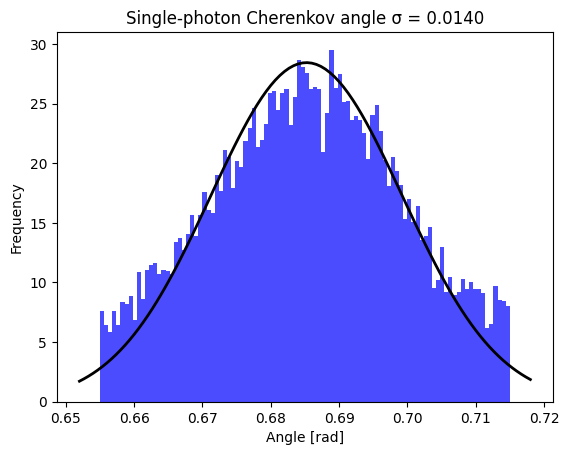

 mu  0.6821580710107169 


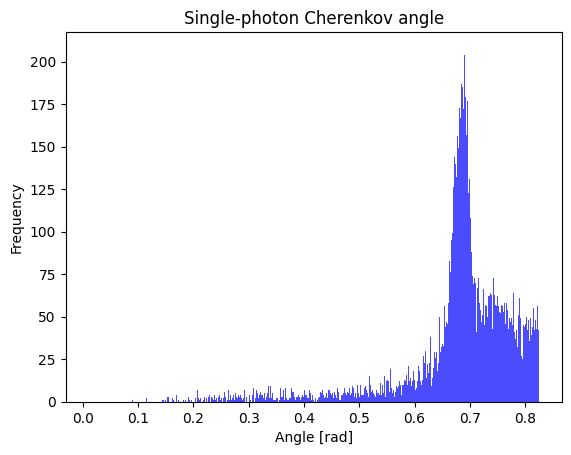

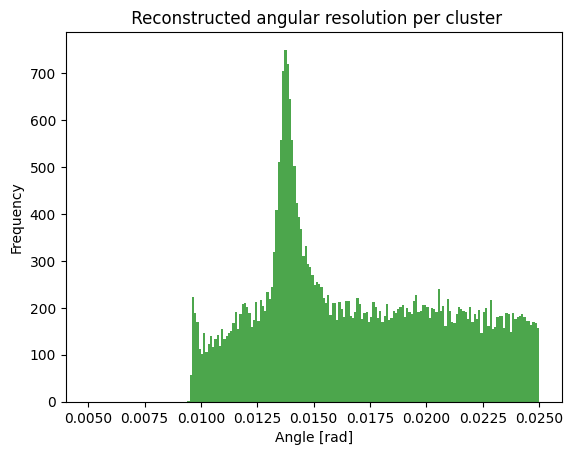

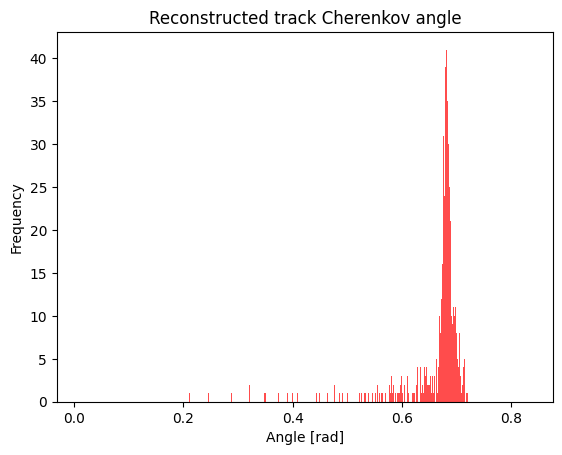

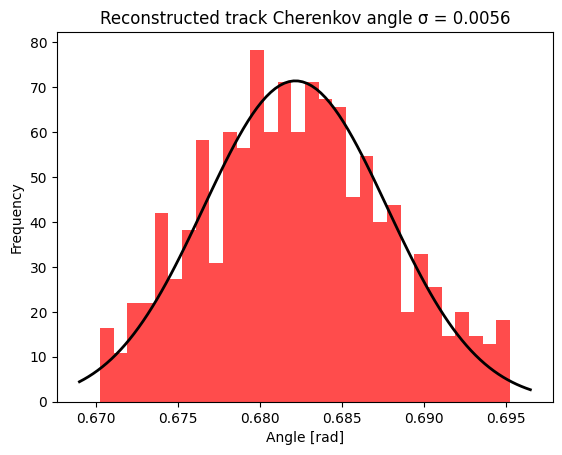

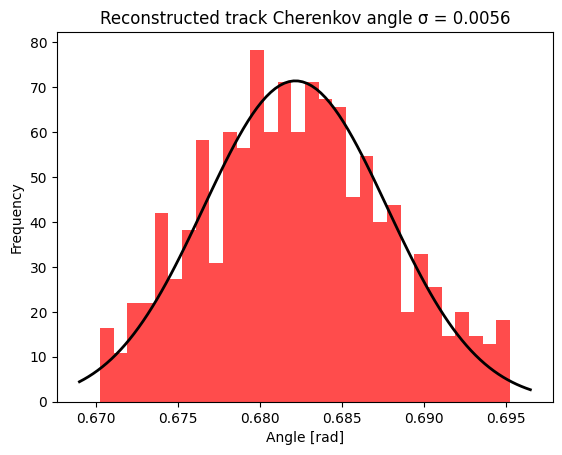

LOOP2 finished!


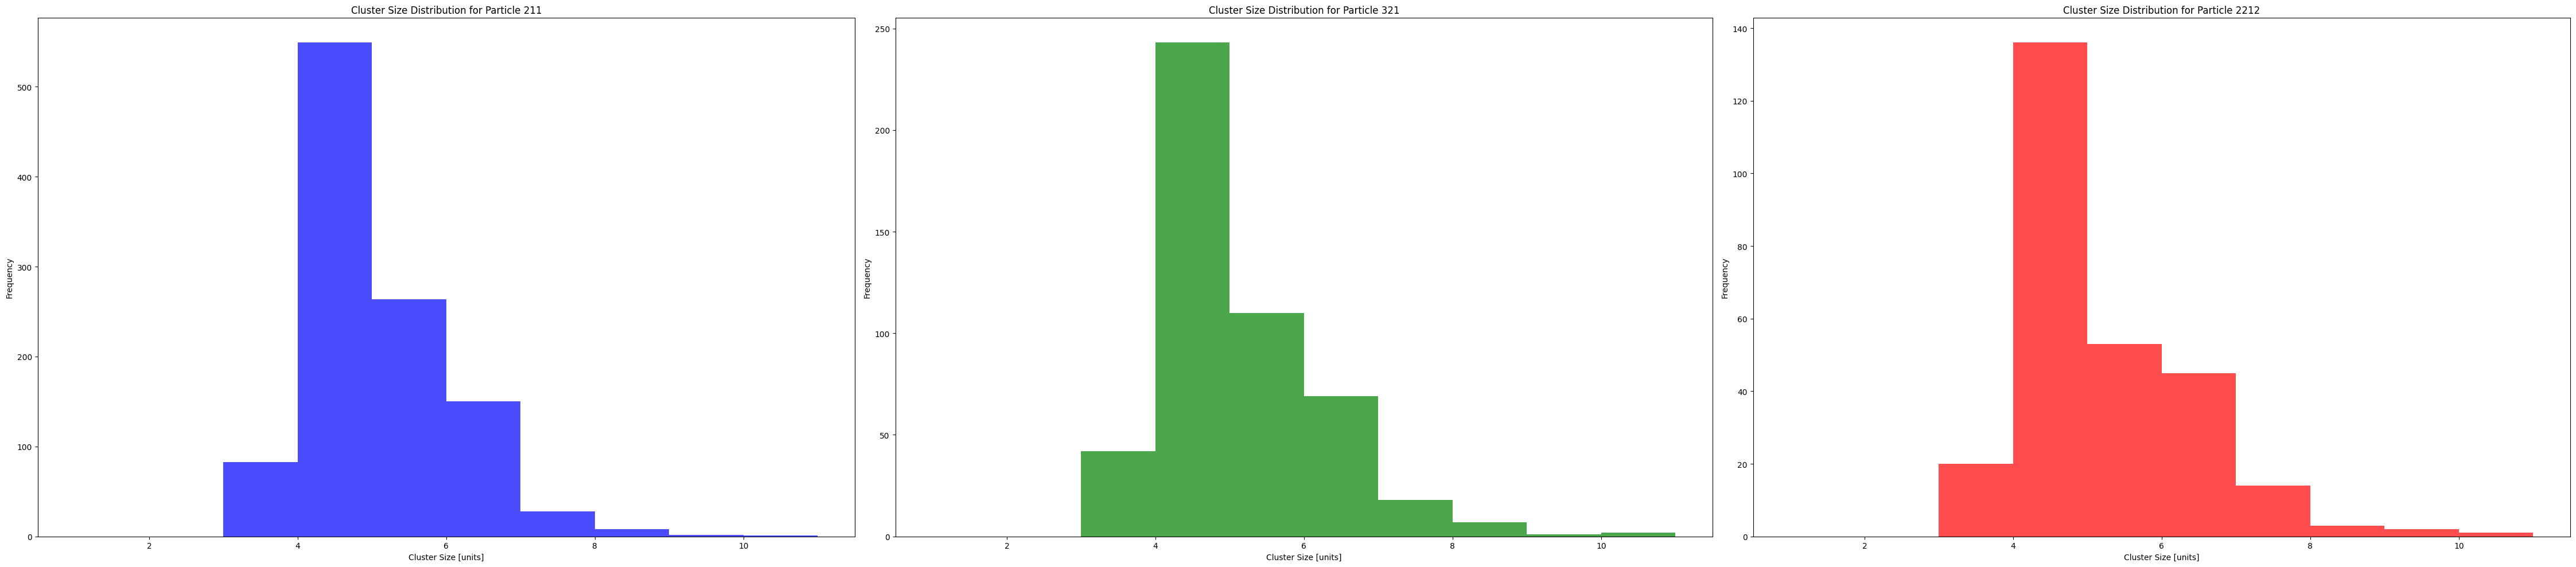

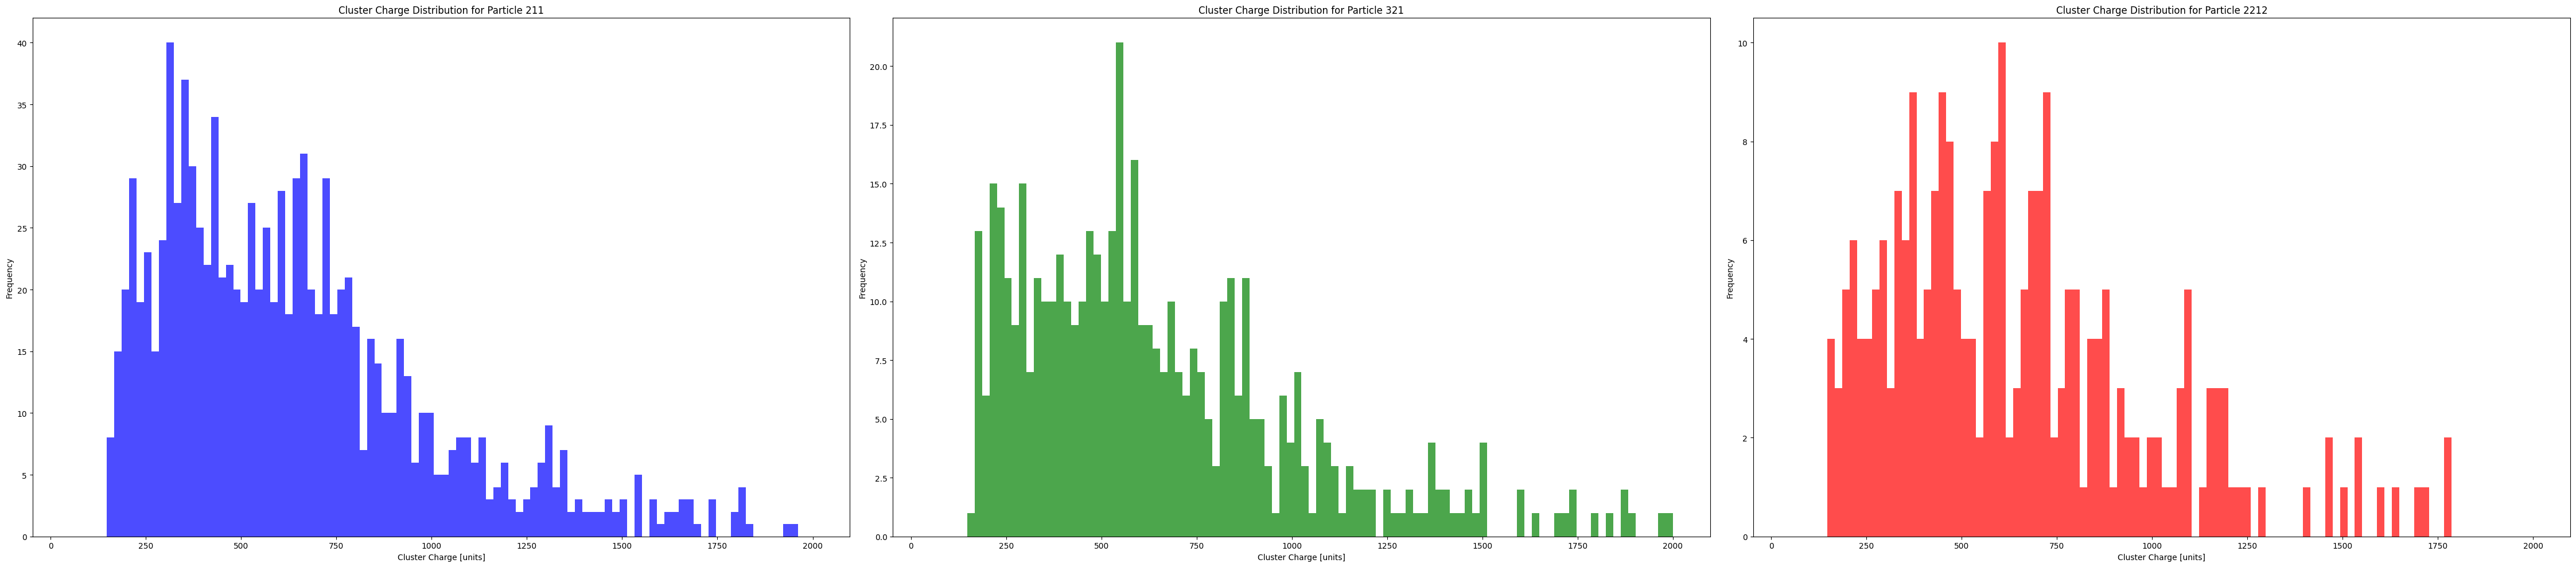

An error occurred in create_scalar_scaler: Empty values array for feature: phiP
Empty values array for feature: phiP


In [182]:


print("classifier = MassClassifier(percentage_to_read = 100, resolution = 4) # pass percentage of dataset to read")
classifier = MassClassifier(percentage_to_read = 100, resolution = 4) # pass percentage of dataset to read

file_to_read = "test/diffLandSegm/ParticleInfoPb20k.h5" # PbPB 2STD, 20k particles



import glob
drive_path = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/'



files_to_read = glob.glob(drive_path  +  "NewSegment/RR/" + "*321**1725*h5") # ok
files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/RR/" + "*211**1725*h5") # ok


files_to_read = glob.glob(drive_path  +  "NewSegment/mCkov/" + "*1725*h5") # ok
files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/pp/AApr/" + "*1725*h5") # ok
files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/" + "*full*h5") # ok
files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/pp/" + "*1725*h5") # ok


files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/pp/kk2/" + "*1725*h5") # ok

files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/pp/pp3/" + "*1725*h5") # ok



files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/pp/pion__/" + "*1725*h5") # ok
#files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/pp/pion/" + "*1725*h5") # problem med denne nå ?
files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/pp/kaon/" + "*1725*h5") # ok



files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/pp/doesWork?Kaon/" + "*1725*h5") # ok





# alle over er med boxgun = 30


# 50
files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/pp/pion??/" + "*1725*h5") # ok
files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/pp/pion??2/" + "*1725*h5") # ok

# 90

files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/pp/kaon?/" + "*1725*h5") # ok

files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/pp/kaon?2/" + "*1725*h5") # ok



files_to_read2 = glob.glob(drive_path  +  "NewSegment/mCkov/pp/proton?/" + "*1725*h5") # ok?
files_to_read2 = files_to_read2 + glob.glob(drive_path  +  "NewSegment/mCkov/pp/proton?2/" + "*1725*h5") # ok

#files_to_read = files_to_read + glob.glob(drive_path  +  "NewSegment/mCkov/pp/kaon?????/" + "*h5") # denne har ikke sigmaRingValues, phiCerValues...


files_to_read2 = files_to_read2 + glob.glob(drive_path  +  "NewSegment/mCkov/pp/kaon?????/" + "*h5") # denne har ikke sigmaRingValues, phiCerValues...

files_to_read3 =  glob.glob(drive_path  +  "NewSegment/mCkov/pp/proton?????/" + "*h5") # denne har ikke sigmaRingValues, phiCerValues...


files_to_read3 = files_to_read3 + glob.glob(drive_path  +  "NewSegment/mCkov/pp/kaon10/" + "*h5") # denne har ikke sigmaRingValues, phiCerValues...


files_to_read3 = files_to_read3 + glob.glob(drive_path  +  "NewSegment/mCkov/pp/Proton/" + "*h5") # denne har ikke sigmaRingValues, phiCerValues...


files_to_read3 = files_to_read3# + glob.glob(drive_path  +  "NewSegment/mCkov/pp/Proton/" + "*h5") # denne har ikke sigmaRingValues, phiCerValues...

# 3
files_to_read4 = glob.glob(drive_path  +  "NewSegment/mCkov/pp/kaon__/" + "*h5") # denne har ikke sigmaRingValues, phiCerValues...
files_to_read5 = glob.glob(drive_path  +  "NewSegment/mCkov/pp/pionN/" + "*h5") # denne har ikke sigmaRingValues, phiCerValues...

directory = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/tt/'

# 5:
files_to_read6 = glob.glob(directory + "*h5") # denne har ikke sigmaRingValues, phiCerValues...




directory = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/pions/'
# 5:
files_to_read7 = glob.glob(directory + "*h5") # denne har ikke sigmaRingValues, phiCerValues...



files_to_read1 = glob.glob(drive_path + "NewSegment/RR/" + "*321**1725*h5")

files_to_read2 = glob.glob(drive_path + "NewSegment/RR/" + "*211**1725*h5")

files_to_read3 = glob.glob(drive_path + "NewSegment/mCkov/" + "*1725*h5")

files_to_read4 = glob.glob(drive_path + "NewSegment/mCkov/pp/AApr/" + "*1725*h5")

files_to_read5 = glob.glob(drive_path + "NewSegment/mCkov/" + "*full*h5")

files_to_read6 = glob.glob(drive_path + "NewSegment/mCkov/pp/" + "*1725*h5")

files_to_read7 = glob.glob(drive_path + "NewSegment/mCkov/pp/kk2/" + "*1725*h5")

files_to_read8 = glob.glob(drive_path + "NewSegment/mCkov/pp/pp3/" + "*1725*h5")

files_to_read9 = glob.glob(drive_path + "NewSegment/mCkov/pp/pion__/" + "*1725*h5")

# Skipped problematic line as per your instructions
# files_to_read10 = glob.glob(drive_path + "NewSegment/mCkov/pp/pion/" + "*1725*h5")

files_to_read10 = glob.glob(drive_path + "NewSegment/mCkov/pp/kaon/" + "*1725*h5")

files_to_read11 = glob.glob(drive_path + "NewSegment/mCkov/pp/doesWork?Kaon/" + "*1725*h5")

files_to_read12 = glob.glob(drive_path + "NewSegment/mCkov/pp/pion??/" + "*1725*h5")

files_to_read13 = glob.glob(drive_path + "NewSegment/mCkov/pp/pion??2/" + "*1725*h5")

files_to_read14 = glob.glob(drive_path + "NewSegment/mCkov/pp/kaon?/" + "*1725*h5")

files_to_read15 = glob.glob(drive_path + "NewSegment/mCkov/pp/kaon?2/" + "*1725*h5")

files_to_read16 = glob.glob(drive_path + "NewSegment/mCkov/pp/proton?/" + "*1725*h5")

files_to_read17 = glob.glob(drive_path + "NewSegment/mCkov/pp/proton?2/" + "*1725*h5")

files_to_read18 = glob.glob(drive_path + "NewSegment/mCkov/pp/kaon?????/" + "*h5")

files_to_read19 = glob.glob(drive_path + "NewSegment/mCkov/pp/proton?????/" + "*h5")

files_to_read20 = glob.glob(drive_path + "NewSegment/mCkov/pp/kaon10/" + "*h5")

files_to_read21 = glob.glob(drive_path + "NewSegment/mCkov/pp/Proton/" + "*h5")

files_to_read22 = glob.glob(drive_path + "NewSegment/mCkov/pp/kaon__/" + "*h5")

files_to_read23 = glob.glob(drive_path + "NewSegment/mCkov/pp/pionN/" + "*h5")

directory_tt = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/tt/'
files_to_read24 = glob.glob(directory_tt + "*h5")

directory_pions = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/pions2/'
files_to_read25 = glob.glob(directory_pions + "*h5")

all_files_to_read = [files_to_read3, files_to_read4, files_to_read5,
                     files_to_read6, files_to_read7, files_to_read8, files_to_read9, files_to_read10,
                     files_to_read11, files_to_read12, files_to_read13, files_to_read14, files_to_read15,
                     files_to_read16, files_to_read17, files_to_read18, files_to_read19, files_to_read20,
                     files_to_read21, files_to_read22, files_to_read23, files_to_read24, files_to_read25]

all_files_to_read = [files_to_read3]


mask = [1, 1, 1, 1]
k_n = 40
import pickle

# Move saved files to destination directory
!mv /content/dataPions{i+1}.npz "/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/"
#!mv /content/data{i+1}.pkl "/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/"


# Loop through the list of files_to_read variables
for i, files in enumerate(all_files_to_read):
    try:
      print("Attempting to open:", files)

      # Initialize MassClassifier and load data

      classifier = MassClassifier(percentage_to_read=100, resolution=4)
      classifier.load_data(files)
      print(files)
      # Preprocess data
      datasets, X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test, regions = classifier.preprocess_data(k_n)

      # Save data as pickle
      #with open(f'data{i+1}.pkl', 'wb') as f:
      #    pickle.dump((datasets, X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test, regions), f)

      # Save data as npz
      np.savez(f'data_extended{i+1}.npz', datasets=datasets, X_train_scaled=X_train_scaled, X_test_scaled=X_test_scaled,
              X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, regions=regions)

      # Move saved files to destination directory
      !mv /content/data_extended{i+1}.npz "/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/"
      #!mv /content/data{i+1}.pkl "/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/"
    except Exception as e : print(e)

In [183]:
!mv /content/dataPions{1}.npz "/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/"

mv: cannot stat '/content/dataPions1.npz': No such file or directory


In [184]:




X_mCluCharge = datasets['mCluCharge']
X_mCluSize = datasets['mCluSize']
X_pion_candidates = datasets['pion_candidates']
X_kaon_candidates = datasets['kaon_candidates']
X_proton_candidates = datasets['proton_candidates']
X_non_candidates = datasets['non_candidates']
X_momentum = datasets['momentum']
X_refractive_index = datasets['refractive_index']
X_phi = datasets['phi']
X_theta = datasets['theta']
X_mip_position = datasets['mip_position']
X_rad_position = datasets['rad_position']
X_map_pion = datasets['map_pion']
X_map_kaon = datasets['map_kaon']
X_map_proton = datasets['map_proton']
X_pion_flag = datasets['pion_flag']
X_kaon_flag = datasets['kaon_flag']
X_proton_flag = datasets['proton_flag']
X_index_particle = datasets['index_particle']
y = datasets['y_cp']


#X_pion_constr_min = regions["X_pion_constr_min"]
#X_pion_constr_max = regions["X_pion_constr_max"]
#X_kaon_constr_min = regions["X_kaon_constr_min"]
#X_kaon_constr_max = regions["X_kaon_constr_max"]
#X_proton_constr_min = regions["X_proton_constr_min"]
#X_proton_constr_max = regions["X_proton_constr_max"]


NameError: ignored

In [ ]:

with open('data4.pkl', 'wb') as f:
    pickle.dump((datasets, X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test, regions), f)


import numpy as np

np.savez('data4.npz', datasets=datasets, X_train_scaled=X_train_scaled, X_test_scaled=X_test_scaled,
         X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, regions=regions)


#data = np.load('data3.npz', allow_pickle=True)
#datasets = data['datasets']
#X_train_scaled = data['X_train_scaled']




In [ ]:


#!mv /content/data3.npz "/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/"
#!mv /content/data3.pkl "/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/"

#!mv /content/data.pkl "/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/"

#!mv /content/data.npz "/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/"


In [ ]:
from google.colab import files


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Plotting histograms of Training Versus Test Sets

In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions.py
from misc_helper_functions import *

In [ ]:
# print("===== Evaluating Training Data =====")
# for feature, data in X_train.items():
#     print(f"Evaluating feature: {feature}")
#     eval_data(np.array(data))  # Assuming your function is designed to work with numpy arrays
#     print("---------------------------")

# # Loop through test_data dictionary
# print("===== Evaluating Test Data =====")
# for feature, data in X_test.items():
#     print(f"Evaluating feature: {feature}")
#     eval_data(np.array(data))  # Assuming your function is designed to work with numpy arrays
#     print("---------------------------")

In [ ]:
# plot_hist(X_train=X_train, X_test=X_test, description = "Unscaled")


# Plot samples

In [ ]:

X_train_pion_candidates = X_train["X_train_pion_candidates"]
X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
X_train_proton_candidates = X_train["X_train_proton_candidates"]
X_train_non_candidates = X_train["X_train_non_candidates"]
X_train_non_candidates = X_train["X_train_non_candidates"]

X_train_momentum = X_train["X_train_momentum"]
X_train_refractive_index = X_train["X_train_refractive_index"]
X_train_phi = X_train["X_train_phi"]
X_train_theta = X_train["X_train_theta"]

X_train_mip_position = X_train["X_train_mip_position"]
X_train_rad_position = X_train["X_train_rad_position"]


X_test_non_candidates = X_test["X_test_non_candidates"]

X_test_pion_candidates = X_test["X_test_pion_candidates"]
X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
X_test_proton_candidates = X_test["X_test_proton_candidates"]
X_test_momentum = X_test["X_test_momentum"]
X_test_refractive_index = X_test["X_test_refractive_index"]
X_test_phi = X_test["X_test_phi"]
X_test_theta = X_test["X_test_theta"]
X_test_mip_position = X_test["X_test_mip_position"]
X_test_rad_position = X_test["X_test_rad_position"]

below_zero_indexes = np.where(X_train_phi < 0)[0]
n = 10
first_n_below_zero_indexes = below_zero_indexes[:n]

print(first_n_below_zero_indexes)
#ef : TODO fix this again


# PDG of train vs test

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# for i in range(1,5):
#   print(y_test[i])



# # Counting occurrences in the training set



print(f"shape : y_test {y_test.shape}")
print(f"shape : y_train {y_train.shape}")




train_pion_count = np.sum(y_train[:, 0])
test_pion_count = np.sum(y_test[:, 0])
print(f"Train counts - Pion: {train_pion_count},  | Test counts - Pion: {test_pion_count}")


train_kaon_count = np.sum(y_train[:, 1])
train_proton_count = np.sum(y_train[:, 2])

# # Counting occurrences in the test set
test_kaon_count = np.sum(y_test[:, 0])
test_proton_count = np.sum(y_test[:, 2])

# print(f'Train : pion_count {train_pion_count}  kaon_count {train_kaon_count} proton_count {train_proton_count}')
# print(f'Test : pion_count {test_pion_count}  kaon_count {test_kaon_count} proton_count {test_proton_count}')

# # Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# # Training set histogram
axs[0].bar(['Pion', 'Kaon', 'Proton'], [train_pion_count, train_kaon_count, train_proton_count])
axs[0].set_title('Training Set')
axs[0].set_xlabel('Particle Type')
axs[0].set_ylabel('Frequency')

# # Test set histogram
axs[1].bar(['Pion', 'Kaon', 'Proton'], [test_pion_count, test_kaon_count, test_proton_count])
axs[1].set_title('Test Set')
axs[1].set_xlabel('Particle Type')
axs[1].set_ylabel('Frequency')

plt.show()


print(f"Train counts - Pion: {train_pion_count}, Kaon: {train_kaon_count}, Proton: {train_proton_count} | Test counts - Pion: {test_pion_count}, Kaon: {test_kaon_count}, Proton: {test_proton_count}")


In [ ]:
#plot_first_instance(1, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates,\
#                    X_train_non_candidates,X_train_mCluSize, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta, y_train)



In [ ]:
#plot_combined_types(1, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates)
# plot_individual_types(5, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates)

X_train_index_particle = X_train["X_train_index_particle"]
X_test_index_particle = X_test["X_test_index_particle"]

index = 2
X_train_mCluCharge = X_train["X_train_mCluCharge"]
X_train_mCluSize = X_train["X_train_mCluSize"]
X_test_mCluCharge = X_test["X_test_mCluCharge"]
X_test_mCluSize = X_test["X_test_mCluSize"]

#print(f"X_test_mCluCharge shape {X_test_mCluCharge[1]}")

#print(f"X_test_rad_position  {X_test_rad_position[0,:,:]}")

#print(f"X_test_mip_position  {X_test_mip_position[0,:,:]}")

#def plot_individual_types(idx, x_pion, x_kaon, x_proton, x_non, MIP_charge, MIP_position, RAD_position, y_train, log_scale):


#print(X_test_refractive_index[:10])

# X_train_pion_candidates = X_train["X_train_pion_candidates"]
# X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
# X_train_proton_candidates = X_train["X_train_proton_candidates"]
# X_train_momentum = X_train["X_train_momentum"]
# X_train_refractive_index = X_train["X_train_refractive_index"]
# X_train_phi = X_train["X_train_phi"]
# X_train_theta = X_train["X_train_theta"]
# X_train_mip_position = X_train["X_train_mip_position"]
# X_train_rad_position = X_train["X_train_rad_position"]

# X_test_pion_candidates = X_test["X_test_pion_candidates"]
# X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
# X_test_proton_candidates = X_test["X_test_proton_candidates"]
# X_test_momentum = X_test["X_test_momentum"]
# X_test_refractive_index = X_test["X_test_refractive_index"]
# X_test_phi = X_test["X_test_phi"]
# X_test_theta = X_test["X_test_theta"]
# X_test_mip_position = X_test["X_test_mip_position"]
# X_test_rad_position = X_test["X_test_rad_position"]

def process_and_plot(datasets, index, regions):
    x_pion = datasets['pion_candidates']
    x_kaon = datasets['kaon_candidates']
    x_proton = datasets['proton_candidates']
    x_non = datasets['non_candidates']
    MIP_charge = datasets['mCluCharge']
    MIP_position = datasets['mip_position']
    RAD_position = datasets['rad_position']
    phi = datasets['phi']
    y_train = datasets['y_cp']
    X_index = datasets['index_particle']
    thetaP = datasets['theta']

    plot_individual_types(idx=index, x_pion=x_pion, x_kaon=x_kaon, x_proton=x_proton, x_non=x_non,
                          MIP_charge=MIP_charge, MIP_position=MIP_position, RAD_position=RAD_position,
                          phi=phi, theta = thetaP, y_train=y_train, log_scale=True, X_index=X_index, regions=regions)

    plot_combined_types(index, x_pion, x_kaon, x_proton, x_non, MIP_position, RAD_position, phi, thetaP, y_train=y_train, X_index=X_index, regions=regions)


# Usage
for index in range(10):
    process_and_plot(datasets=datasets, index=index, regions=regions)

#plot_combined_types3(index, X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_non_candidates,X_test_mip_position, X_test_rad_position, X_test_phi, X_test_theta, y_test)



In [ ]:

def count_non_zero_charges(datasets, idx, titles):
    non_zero_counts = {}
    for data, title in zip(datasets, titles):
        non_zero_charges = np.count_nonzero(data[idx, :, 3])
        non_zero_counts[title] = non_zero_charges
    return non_zero_counts
def count_non_zero_charges_vectorized(datasets):
    return [np.count_nonzero(data[:, :, 3], axis=1) for data in datasets]

datasets = [X_pion_candidates, X_kaon_candidates, X_proton_candidates]
non_zero_counts = count_non_zero_charges_vectorized(datasets)

fig, ax = plt.subplots(2, 2, figsize=(15, 10), tight_layout=True)

# Determine global bin range for consistency
max_count = max(np.max(counts) for counts in non_zero_counts)
bins = np.linspace(0, max_count, 50)  # or adjust the number of bins as desired

titles = ["Pion", "Kaon", "Proton", "Non"]
colors = ['r', 'g', 'b', 'y']

for i, (counts, title, color) in enumerate(zip(non_zero_counts, titles, colors)):
    row, col = divmod(i, 2)
    ax[row, col].hist(counts, bins=bins, color=color, alpha=0.7, label=title)
    ax[row, col].set_title(title)
    ax[row, col].set_xlabel('Number of Non-Zero Charges')
    ax[row, col].set_ylabel('Frequency')

plt.show()
def get_max_non_zero_counts(datasets, titles):
    max_counts = {}
    for data, title in zip(datasets, titles):
        # Count the non-zero charges for each sequence in the dataset
        non_zero_counts_per_sequence = np.count_nonzero(data[:, :, 3], axis=1)
        # Get the maximum count for the dataset
        max_counts[title] = np.max(non_zero_counts_per_sequence)
    return max_counts

titles = ["Pion", "Kaon", "Proton"]
max_non_zero_counts = get_max_non_zero_counts(datasets, titles)

print(max_non_zero_counts)


In [ ]:

def count_non_zero_charges(datasets, idx, titles):
    non_zero_counts = {}
    for data, title in zip(datasets, titles):
        non_zero_charges = np.count_nonzero(data[idx, :, 3])
        non_zero_counts[title] = non_zero_charges
    return non_zero_counts

datasets = [x_pion, x_kaon, x_proton, x_non]
titles = ["Pion", "Kaon", "Proton", "Non"]
non_zero_counts = count_non_zero_charges(datasets, idx, titles)

def get_lengths_and_global_max(sequences):
  def last_non_zero_index(seq):
      non_zero_indices = np.where(np.any(seq != 0, axis=1))[0]
      return non_zero_indices[-1] + 1 if len(non_zero_indices) > 0 else 0

  lengths = [last_non_zero_index(seq) for seq in sequences]
  return lengths, max(lengths)

# Extract lengths and max lengths
pion_lengths, pion_global_max_length = get_lengths_and_global_max(X_pion_candidates)
kaon_lengths, kaon_global_max_length = get_lengths_and_global_max(X_kaon_candidates)
proton_lengths, proton_global_max_length = get_lengths_and_global_max(X_proton_candidates)



# Plotting
fig, ax = plt.subplots(2, 2, figsize=(15, 10), tight_layout=True)
bins = range(100, max(pion_global_max_length, kaon_global_max_length, proton_global_max_length) + 5, 5)

ax[0, 0].hist(pion_lengths, bins=bins, color='r', alpha=0.7, label='Pion')
ax[0, 0].set_title('Pion')
ax[0, 0].set_xlabel('Length')
ax[0, 0].set_ylabel('Frequency')

ax[0, 1].hist(kaon_lengths, bins=bins, color='g', alpha=0.7, label='Kaon')
ax[0, 1].set_title('Kaon')
ax[0, 1].set_xlabel('Length')
ax[0, 1].set_ylabel('Frequency')

ax[1, 0].hist(proton_lengths, bins=bins, color='b', alpha=0.7, label='Proton')
ax[1, 0].set_title('Proton')
ax[1, 0].set_xlabel('Length')
ax[1, 0].set_ylabel('Frequency')

# Training the model


In [ ]:





!wget -O ParticleDataUtilsCp.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/ParticleDataUtils21.py
from ParticleDataUtilsCp import ParticleDataUtils, classify_candidates_with_pad_sequences

!wget -O misc_helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions5.py
from misc_helper_functions import build_species_layers, calculate_theta, filter_data, create_lr_scheduler,plot_lr, extract_neighborhood_map, create_cnn_model # plot_worst

!wget -O helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/helper_functions.py
!wget -O plot_helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions22.py



from plot_helper_functions import plot_hist, plot_training_history, plot_confusion_matrix


print(classify_candidates_with_pad_sequences)


In [ ]:
# plot_helper_functions.plot_hist(X_train=X_train, X_test=X_test, description = "Unscaled")


In [ ]:
mask = [1,1,1,1]




fc1_unit = 64
units = [fc1_unit * i for i in [8,4, 2, 2, 1,1,1]]
units2 = [fc1_unit * i for i in [8,4, 2, 2, 1,1,1,]]
# units = [fc1_unit * i for i in [2,  1]]
# units2 = [fc1_unit * i for i in [2, 1]]

final_concat_units = [128, 32, 16 * i for i in [1]]

# units = [fc1_unit * i for i in [16, 8, 4, 2, 2, 1]]
# units2 = [fc1_unit * i for i in [16, 8, 4, 2, 2, 1]]

CNN_units =  [8, 4, 2, 2, 1]
n_epochs = 200


#datasets , X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test, regions = classifier.preprocess_data(k_n)


model, history, variables = classifier.train(X_train = X_train_scaled, X_test = X_test_scaled, y_train = y_train, y_test = y_test, mask = mask, num_epochs=n_epochs, include_cnn = True, units = units, units2 = units2, final_concat_units = final_concat_units, CNN_units = CNN_units)

#model, history, variables = classifier.train(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, mask = mask, num_epochs=n_epochs, include_cnn = True, units = units, units2 = units2, final_concat_units = final_concat_units, CNN_units = CNN_units)

model.summary()

#

# weight_list = [layer.get_weights()[0] for layer in model.layers if len(layer.get_weights()) > 0]
# import matplotlib.pyplot as plt

# for i, w in enumerate(weight_list):
#     plt.hist(w.flatten(), bins=50)
#     plt.title(f"Layer {i} Weight Distribution")
#     plt.show()

# import seaborn as sns

# for i, w in enumerate(weights):
#     if len(w.shape) == 2:  # Ensure it's a 2D matrix
#         plt.figure(figsize=(10, 10))
#         sns.heatmap(w, cmap='viridis')
#         plt.title(f"Layer {i} Weight Heatmap")
#         plt.show()


# import matplotlib.pyplot as plt
# import numpy as np

# for index, weights in enumerate(weight_list):
#     plt.figure(figsize=(10, 5))

#     # You can take the absolute value if you're interested in magnitude
#     # Otherwise, just remove np.abs
#     plt.imshow(np.abs(weights), cmap='hot', interpolation='nearest')

#     plt.colorbar()
#     plt.title(f'Layer {index} Weights Intensity')
#     plt.show()


In [ ]:

%reload_ext tensorboard

%tensorboard --logdir logs/fit

In [ ]:
X_train_pion_candidates = X_train["X_train_pion_candidates"]
X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
X_train_proton_candidates = X_train["X_train_proton_candidates"]


X_train_non_candidates = X_train["X_train_non_candidates"]
X_train_momentum = X_train["X_train_momentum"]
X_train_refractive_index = X_train["X_train_refractive_index"]
X_train_phi = X_train["X_train_phi"]
X_train_theta = X_train["X_train_theta"]
X_train_mip_position = X_train["X_train_mip_position"]
X_train_rad_position = X_train["X_train_rad_position"]
X_train_map_pion = X_train["X_train_map_pion"]
X_train_map_kaon = X_train["X_train_map_kaon"]
X_train_map_proton = X_train["X_train_map_proton"]






X_test_pion_candidates = X_test["X_test_pion_candidates"]
X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
X_test_proton_candidates = X_test["X_test_proton_candidates"]
X_test_non_candidates = X_test["X_test_non_candidates"]
X_test_momentum = X_test["X_test_momentum"]
X_test_refractive_index = X_test["X_test_refractive_index"]
X_test_phi = X_test["X_test_phi"]
X_test_theta = X_test["X_test_theta"]
X_test_mip_position = X_test["X_test_mip_position"]
X_test_rad_position = X_test["X_test_rad_position"]
X_test_map_pion = X_test["X_test_map_pion"]
X_test_map_kaon = X_test["X_test_map_kaon"]
X_test_map_proton = X_test["X_test_map_proton"]

X_train_mCluCharge = X_train["X_train_mCluCharge"]
X_train_mCluSize = X_train["X_train_mCluSize"]
X_test_mCluCharge = X_test["X_test_mCluCharge"]
X_test_mCluSize = X_test["X_test_mCluSize"]


train_variables = variables[0]
y_train = variables[1]
test_variables = variables[2]
y_test = variables[3]


In [ ]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score

def plot_confusion_matrix(ax, cm, title="Confusion Matrix"):
    """Utility function to plot the confusion matrix."""
    ax.imshow(cm, cmap='Blues', interpolation='nearest')
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels(['Pion', 'Kaon', 'Proton'])
    ax.set_yticklabels(['Pion', 'Kaon', 'Proton'])
    ax.set_title(title)
    for x in range(3):
        for y in range(3):
            percent = cm[x, y] / np.sum(cm[x, :]) * 100
            ax.text(y, x, f"{cm[x, y]} ({percent:.1f}%)", ha='center', va='center', color='red')

def plot_training_history(history, y_pred_train, y_pred_test, y_train_true, y_test_true):
    fig2, axs2 = plt.subplots(1, 2, figsize=(25, 6))
    cm_train = confusion_matrix(y_train_true.argmax(axis=1), y_pred_train.argmax(axis=1))
    cm_test = confusion_matrix(y_test_true.argmax(axis=1), y_pred_test.argmax(axis=1))
    plot_confusion_matrix(axs2[0], cm_train, title="Train Confusion Matrix")
    plot_confusion_matrix(axs2[1], cm_test, title="Validation Confusion Matrix")
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(16, 18))
    axs[0].plot(history.history["loss"], label="Train Loss")
    axs[0].plot(history.history["val_loss"], label="Validation Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(history.history["accuracy"], label="Train Accuracy")
    axs[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    class_labels = ['Pion', 'Kaon', 'Proton']
    fig, axs = plt.subplots(1, 3, figsize=(36, 12))

    # Train P-R Curve and F1 Score
    y_train_bin = label_binarize(y_train_true, classes=[0, 1, 2])
    for i in range(3):
        precision_train, recall_train, _ = precision_recall_curve(y_train_bin[:, i], y_pred_train[:, i])
        axs[0].plot(recall_train, precision_train, lw=2, label=f"Train {class_labels[i]}", linestyle='--', color=f'C{i}')
        f1_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)
        axs[2].plot(recall_train, f1_train, lw=2, label=f"Train {class_labels[i]}", linestyle='--', color=f'C{i}')

    # Validation P-R Curve and F1 Score
    y_test_bin = label_binarize(y_test_true, classes=[0, 1, 2])
    for i in range(3):
        precision_test, recall_test, _ = precision_recall_curve(y_test_bin[:, i], y_pred_test[:, i])
        axs[1].plot(recall_test, precision_test, lw=2, label=f"Validation {class_labels[i]}", color=f'C{i}')
        f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
        axs[2].plot(recall_test, f1_test, lw=2, label=f"Validation {class_labels[i]}", color=f'C{i}')

    axs[0].set_title("P-R Curve for Training Data")
    axs[1].set_title("P-R Curve for Validation Data")
    axs[2].set_title("F1 Score Curve")
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.show()

In [ ]:
import warnings

#train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates, X_train_momentum, X_train_refractive_index, X_train_phi, X_train_theta, X_train_mip_position, X_train_rad_position, X_train_mCluCharge, X_train_mCluSize]
#test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_non_candidates, X_test_momentum, X_test_refractive_index, X_test_phi, X_test_theta, X_test_mip_position, X_test_rad_position, X_test_mCluCharge, X_test_mCluSize]




y_pred_train = model.predict(train_variables)
y_pred_test = model.predict(test_variables)
# First function call with 'self'
try:
    plot_training_history(history=history, y_pred_train=y_pred_train, y_pred_test=y_pred_test, y_train_true=y_train, y_test_true=y_test)
except Exception as e:
    warnings.warn(f"Exception caught during first function call: {e}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_histograms(X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, y_train):
    labels = ['piontrack', 'kaontrack', 'protontrack']
    segments = ['pionsegm', 'kaonsegm', 'protonsegm']

    # Extract and store data
    data_matrix = {}
    for track in labels:
        data_matrix[track] = {}
        for segm in segments:
            data_matrix[track][segm] = {'charge': [], 'size': []}

    for idx, track in enumerate(labels):
        mask = np.all(y_train == np.eye(3)[idx], axis=1)

        data_matrix[track]['pionsegm']['charge'].extend(X_train_pion_candidates[mask, :, 3].ravel())
        data_matrix[track]['pionsegm']['size'].extend(X_train_pion_candidates[mask, :, 2].ravel())
        data_matrix[track]['kaonsegm']['charge'].extend(X_train_kaon_candidates[mask, :, 3].ravel())
        data_matrix[track]['kaonsegm']['size'].extend(X_train_kaon_candidates[mask, :, 2].ravel())
        data_matrix[track]['protonsegm']['charge'].extend(X_train_proton_candidates[mask, :, 3].ravel())
        data_matrix[track]['protonsegm']['size'].extend(X_train_proton_candidates[mask, :, 2].ravel())

    # Helper function to plot
    def generate_plot(filtered_charge=0, filtered_size=0, plot_type="all"):
        fig_hist, ax_hist = plt.subplots(3, 3, figsize=(15, 15))

        for i, track_type in enumerate(labels):
            for j, segm_type in enumerate(segments):
                charges = [c for c in data_matrix[track_type][segm_type]['charge'] if c > filtered_charge]
                sizes = [s for s in data_matrix[track_type][segm_type]['size'] if s > filtered_size]

                if plot_type == "charge":
                    ax_hist[i, j].set_yscale('log')
                    ax_hist[i, j].hist(charges, bins=125, range=(0, 250), edgecolor='black', alpha=0.6)
                    ax_hist[i, j].set_title(f"{track_type}, {segm_type} - Charge")

                elif plot_type == "size":
                    ax_hist[i, j].hist(sizes, bins=6, range=(0, 6), edgecolor='black', alpha=0.6)
                    ax_hist[i, j].set_yscale('log')
                    ax_hist[i, j].set_title(f"{track_type}, {segm_type} - Size")

                elif plot_type == "2d":
                    valid_charges = [c for idx, c in enumerate(data_matrix[track_type][segm_type]['charge']) if c > filtered_charge and data_matrix[track_type][segm_type]['size'][idx] > filtered_size]
                    valid_sizes = [s for idx, s in enumerate(data_matrix[track_type][segm_type]['size']) if data_matrix[track_type][segm_type]['charge'][idx] > filtered_charge and s > filtered_size]

                    hist = ax_hist[i, j].hist2d(valid_charges, valid_sizes, bins=(25, 6), range=[[0, 250], [0, 6]], cmin=1, norm=LogNorm())
                    plt.colorbar(hist[3], ax=ax_hist[i, j])
                    ax_hist[i, j].set_title(f"{track_type}, {segm_type} - 2D Charge vs Size")

        plt.tight_layout()
        plt.show()

    # Generate the plots
    generate_plot(plot_type="size")
    generate_plot(plot_type="charge")
    generate_plot(plot_type="2d")
    generate_plot(filtered_size=1, plot_type="size")
    generate_plot(filtered_charge=10, plot_type="charge")
    generate_plot(filtered_charge=10, filtered_size=1, plot_type="2d")



In [ ]:

y_train = variables[1]#, test_variables = variables[2], y_test = variables[3]

plot_histograms(X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, y_train)

In [ ]:

def freedman_diaconis_bins(data):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # Assuming data is 1D array
    data_range = np.nanmax(data) - np.nanmin(data)
    iqr = np.subtract(*np.percentile(data, [75, 25]))
    bin_width = 2 * iqr * (len(data) ** -0.33)
    return int(data_range / bin_width) if bin_width > 0 else 1

def check_nan_inf(arr):
    """Check if array contains NaN or Inf values."""
    return np.isnan(arr).any(), np.isinf(arr).any()




def plot_hist(X_train=None, X_test=None, y_train = None, y_test = None, description=None):
    try:

        def plot_specialized_histograms(data, y_data, title):


          try:

              fig, axs = plt.subplots(3, 4, figsize=(25, 12))
              fig.suptitle(f"{title}", fontsize=20)

              # Separate data based on y-labels
              pion_indices = np.where(y_data == np.array([1, 0, 0]))[0]
              kaon_indices = np.where(y_data == np.array([0, 1, 0]))[0]
              proton_indices = np.where(y_data == np.array([0, 0, 1]))[0]
              print(y_data.shape)
              data_map = {
              'Pion': pion_indices,
              'Kaon': kaon_indices,
              'Proton': proton_indices
              }





              for idx, (particle, indices) in enumerate(data_map.items()):
                  clu_size = data['mCluSize'][indices]
                  clu_charge = data['mCluCharge'][indices]


                  clu_size = clu_size.reshape(-1)
                  clu_charge = clu_charge.reshape(-1)

                  print(f"np.any(np.isnan(clu_size)) {np.any(np.isnan(clu_size))}")

                  print(f"np.any(np.isnan(clu_charge)) {np.any(np.isnan(clu_charge))}")
                  print(f"np.any(np.isinf(clu_size)) {np.any(np.isinf(clu_size))}")
                  print(f"np.any(np.isinf(clu_charge)) {np.any(np.isinf(clu_charge))}")



                  print(f"len(clu_size) {len(clu_size)}")
                  print(f"len(clu_charge) {len(clu_charge)}")
                  print(f"pion_indices.shape {pion_indices.shape}")
                  print(f"kaon_indices.shape {kaon_indices.shape}")
                  print(f"proton_indices.shape {proton_indices.shape}")


                  # 1D histograms
                  axs[idx, 0].hist(clu_size, bins=9, range=(2, 11), edgecolor='black', alpha=0.6, label='MIP Cluster size')
                  axs[idx, 0].legend()
                  axs[idx, 0].set_title(f"{particle} MIP Cluster Size ")


                  # 1D histograms
                  axs[idx, 1].hist(clu_charge, bins=200, range=(0, 4000), edgecolor='black', alpha=0.6, label='MIP Cluster charge')
                  axs[idx, 1].legend()
                  axs[idx, 1].set_title(f"{particle} 'MIP Cluster charge")




                  try: # works!!

                      gridx = np.linspace(min(clu_size), max(clu_size),11)
                      gridy = np.linspace(min(clu_charge), max(clu_charge),200)
                      try:
                          h, xedges, yedges = np.histogram2d(clu_size, clu_charge, bins=[9, 30], range=[(2, 11), (200, 800)])
                      except ValueError as ve:
                          print("Error unpacking histogram2d results:", ve)
                          results = np.histogram2d(clu_size, clu_charge, bins=[gridx, gridy])
                          print("Results returned from histogram2d:", results)

                      norm = LogNorm()  # Define the logarithmic normalization
                      im = axs[idx, 2].pcolormesh(xedges, yedges, h.T, cmap='viridis', norm=norm)
                      axs[idx, 2].set_title(f"{particle} 2D Hist")
                      axs[idx, 2].set_xlabel("'MIP Cluster size")
                      axs[idx, 2].set_ylabel("'MIP Cluster charge")
                      #axs[idx, 2].set_yscale('log')

                      plt.colorbar(im, ax=axs[idx, 2])  # Add colorbar with logarithmic scale

                  except Exception as e:
                      warnings.warn(f"plot_specialized_histograms failed histogram2d : {e}")
                  try:
                      try:
                          h, xedges, yedges = np.histogram2d(clu_size, clu_charge, bins=[11, 200], range=[(0, 11), (0, 8000)])

                          ax_3d = axs[idx, 3]

                          ax_3d = fig.add_subplot(3, 4, 4 * idx + 4, projection='3d')  # change the layout
                          x_pos, y_pos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
                          x_pos = x_pos.flatten('F')
                          y_pos = y_pos.flatten('F')
                          z_pos = np.zeros_like(x_pos)
                          dx = dy = 0.5
                          dz = h.flatten()
                          ax_3d.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, shade=True)
                          ax_3d.set_title(f"{particle} 3D Bar Chart")
                          ax_3d.set_xlabel("mCluSize")
                          ax_3d.set_ylabel("mCluCharge")
                          ax_3d.set_zlabel("Counts")

                      except Exception as e:
                          warnings.warn(f"plot_specialized_histograms failed  np.histogram2 w : {e}")
                  except Exception as e:
                      warnings.warn(f"plot_specialized_histograms failed  # 3D View w : {e}")


              plt.tight_layout()
              plt.show()

          except Exception as e:
                warnings.warn(f"Exception caught during plot_specialized_histograms: {e}")


        # Call the new function to generate plots for training and testing datasets
        train_data = {
            'mCluSize': X_train["X_train_mCluSize"],
            "mCluCharge": X_train["X_train_mCluCharge"]
        }

        test_data = {
            'mCluSize': X_test["X_test_mCluSize"],
            "mCluCharge": X_test["X_test_mCluCharge"]
        }

        plot_specialized_histograms(train_data, y_train, title="Training Data")
        plot_specialized_histograms(test_data, y_test, title="Testing Data")


        fig, axs = plt.subplots(2, 4, figsize=(25, 10)) # For 'Refractive Index', 'Momentum', 'Phi', and 'Theta'
        fig.suptitle(f"Training and Testing Data: {description}", fontsize=20)

        fig_mClu, axs_mClu = plt.subplots(2, 2, figsize=(16, 10)) # For 'mCluSize' and 'mCluCharge'
        fig_mClu.suptitle(f"Cluster Features: {description}", fontsize=20)

        fig3, axs3 = plt.subplots(2, 5, figsize=(25, 10))
        fig3.suptitle(f"Training and Testing Data: {description}", fontsize=20)



        # impact points on rad / MIP spatial distribution
        fig1, axs1 = plt.subplots(2, 3, figsize=(18, 10))
        fig1.suptitle(f"2D Maps and Projections: {description}", fontsize=20)





        for key, value in X_train.items():
            print(key, type(value))





        def plot_routine(variables, row_idx):
            axs_idx = 0
            axs_idx = 0
            axs_mClu_idx = 0
            for label, variable in variables.items():
                has_nan, has_inf = check_nan_inf(variable)
                if has_nan or has_inf:
                    warnings.warn(f"{label} contains NaN or Inf values. This may lead to issues.")

                bins = freedman_diaconis_bins(variable)
                range_val = (np.nanmin(variable), np.nanmax(variable))

                if label == 'MIP Position' or label == 'Rad Position':
                    variable = np.asarray(variable).reshape(-1, 2)
                    mask = (variable[:, 0] != 0) & (variable[:, 1] != 0)
                    variable = variable[mask]
                    axs1[row_idx, 0].scatter(variable[:, 0], variable[:, 1], marker='o', s=10)
                    axs1[row_idx, 0].set_title(f"{'Train' if row_idx == 0 else 'Test'} 2D Map: {label}")
                    axs1[row_idx, 1].hist(variable[:, 0], bins=bins, range=range_val, edgecolor='black')
                    axs1[row_idx, 1].set_title(f"{label} X")
                    axs1[row_idx, 2].hist(variable[:, 1], bins=bins, range=range_val, edgecolor='black')
                    axs1[row_idx, 2].set_title(f"{label} Y")


                elif label == 'mCluSize':
                    axs_mClu[row_idx, axs_mClu_idx].hist(variable, bins=11, range=(0, 11), edgecolor='black')
                    axs_mClu[row_idx, axs_mClu_idx].set_title(f"{'Train' if row_idx == 0 else 'Test'} {label}")
                    axs_mClu_idx += 1

                elif label == 'mCluCharge':
                    axs_mClu[row_idx, axs_mClu_idx].hist(variable, bins=200, range=(0, 8000), edgecolor='black')
                    axs_mClu[row_idx, axs_mClu_idx].set_title(f"{'Train' if row_idx == 0 else 'Test'} {label}")
                    axs_mClu_idx += 1

                elif label == 'Momentum':
                    axs[row_idx, axs_idx].hist(variable, bins=50, range=(0, 5), edgecolor='black')
                    axs[row_idx, axs_idx].set_title(f"{'Train' if row_idx == 0 else 'Test'} {label}")
                    axs_idx += 1

                else:
                    axs[row_idx, axs_idx].hist(variable, bins=bins, range=range_val, edgecolor='black')
                    axs[row_idx, axs_idx].set_title(f"{'Train' if row_idx == 0 else 'Test'} {label}")
                    axs_idx += 1






        X_train_variables = {
        'Refractive Index': X_train["X_train_refractive_index"],
        'Momentum': X_train["X_train_momentum"],
        'Phi': X_train["X_train_phi"],
        'Theta': X_train["X_train_theta"],
        'mCluSize': X_train["X_train_mCluSize"],
        "mCluCharge": X_train["X_train_mCluCharge"],  # New addition
        'MIP Position': X_train["X_train_mip_position"],
        'Rad Position': X_train["X_train_rad_position"],
        'Pion Candidates': X_train["X_train_pion_candidates"],
        'Kaon Candidates': X_train["X_train_kaon_candidates"],
        'Proton Candidates': X_train["X_train_proton_candidates"]

        }


        # add kaon and proton candidates ;
        X_test_variables = {
        'Refractive Index': X_test["X_test_refractive_index"],
        'Momentum': X_test["X_test_momentum"],
        'Phi': X_test["X_test_phi"],
        'Theta': X_test["X_test_theta"],
        'mCluSize': X_test["X_test_mCluSize"],
        "mCluCharge": X_test["X_test_mCluCharge"],  # New addition
        'MIP Position': X_test["X_test_mip_position"],
        'Rad Position': X_test["X_test_rad_position"],
        'Pion Candidates': X_test["X_test_pion_candidates"],
        }

        train_data = {
        'mCluSize': X_train["X_train_mCluSize"],
        "mCluCharge": X_train["X_train_mCluCharge"]
        }

        test_data = {
        'mCluSize': X_test["X_test_mCluSize"],
        "mCluCharge": X_test["X_test_mCluCharge"]
        }



        plot_routine(X_train_variables, 0)
        plot_routine(X_test_variables, 1)

        plt.show()

    except Exception as e:
        warnings.warn(f"Exception caught during plot_histl: {e}")

import warnings

try:

    plot_hist(X_train = X_train, X_test =  X_test, y_train = y_train, y_test = y_test,  description = "unscaled")
except Exception as e:
    warnings.warn(f"Exception caught during first function call: {e}")




In [ ]:

import warnings

try:
    plot_hist(X_train = X_train, X_test =  X_test, y_train = y_train, y_test = y_test,  description = "unscaled")
except Exception as e:
    warnings.warn(f"Exception caught during first function call: {e}")




In [ ]:
threshold = 0.7

X_test = X_test
y_train = y_train
y_test = y_test
#X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test = classifier.preprocess_data()


train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates, X_train_momentum, X_train_refractive_index, X_train_phi, X_train_theta, X_train_mip_position, X_train_rad_position, X_train_mCluCharge, X_train_mCluSize]
test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_non_candidates, X_test_momentum, X_test_refractive_index, X_test_phi, X_test_theta, X_test_mip_position, X_test_rad_position, X_test_mCluCharge, X_test_mCluSize]

y_pred_train = model.predict(train_variables)
y_pred_test = model.predict(test_variables)

# plot_individual_types(idx=index, x_pion=X_test_pion_candidates, x_kaon=X_test_kaon_candidates, x_proton=X_test_proton_candidates, x_non=X_test_non_candidates, MIP_charge=X_test_mCluCharge, MIP_position=X_test_mip_position, RAD_position=X_test_rad_position, phi=X_test_phi, y_train=y_test, log_scale=True, X_index=X_test_index_particle)


#def plot_combined_types(i, x_pion, x_kaon, x_proton, x_non, MIP_position, RAD_position, phiP, thetaP, y_train):
#
regions = 2

class_labels  = ["pion", "kaon", "proton"]
i = 0

plot_var = "train"
#if plot_var == "test":
import matplotlib.pyplot as plt

def process_predictions(y_pred, y_true, X_pion_candidates, X_kaon_candidates, X_proton_candidates, X_non_candidates, MIP_charge, MIP_position, RAD_position, phi, theta, y_train, X_index_particle, regions, prefix=''):
    i = 0
    for pred, true in zip(y_pred, y_true):
        max_prob = np.max(pred)
        predicted_class = np.argmax(pred)
        if max_prob > threshold:
            label = class_labels[predicted_class]  # Assuming class_labels is a list of your labels
        else:
            label = 'reject'

        print(f"====================================================================================== \n")

        info_str = f" predicted_class = {predicted_class}  true class = {true}|  max_prob = {max_prob:.2f} pred = {pred}"


        fig, ax = plt.subplots()

        #
          # plot_individual_types(idx=index, x_pion=x_pion, x_kaon=x_kaon, x_proton=x_proton, x_non=x_non,
          #                       MIP_charge=MIP_charge, MIP_position=MIP_position, RAD_position=RAD_position,
          #                       phi=phi, theta = thetaP, y_train=y_train, log_scale=True, X_index=X_index, regions=regions)

          # plot_combined_types(index, x_pion, x_kaon, x_proton, x_non, MIP_position, RAD_position, phi, thetaP, y_train=y_train, X_index=X_index, regions=regions)


        plot_individual_types(idx=i, x_pion=X_pion_candidates, x_kaon=X_kaon_candidates, x_proton=X_proton_candidates, x_non=X_non_candidates, MIP_charge=MIP_charge, MIP_position=MIP_position, RAD_position=RAD_position, phi=phi, theta = theta, y_train=y_train, log_scale=True, X_index=X_index_particle, regions=regions)
        plt.savefig(f'{prefix}_individual_plot_{i}.png')  # Save the individual plot
        plt.close()

        fig, ax = plt.subplots()
        plot_combined_types(i, X_pion_candidates, X_kaon_candidates, X_proton_candidates, X_non_candidates, MIP_position, RAD_position, phi, theta, y_train=y_train, X_index=X_index_particle, regions=regions)

        plt.savefig(f'{prefix}_combined_plot_{i}.png')  # Save the combined plot
        plt.close()

        print(info_str)
        i += 1

# For test data
process_predictions(y_pred_test, y_test, X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_non_candidates, X_test_mCluCharge, X_test_mip_position, X_test_rad_position, X_test_phi, X_test_theta, y_test, X_test_index_particle, regions, prefix='test')

# For train data
process_predictions(y_pred_train, y_train, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates, X_train_mCluCharge, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta, y_train, X_train_index_particle, regions, prefix='train')


In [ ]:


mask = [1,1,1,1]




fc1_unit = 64
units = [fc1_unit * i for i in [64, 32, 16, 16, 8, 4, 4, 2, 2, 1]]
units2 = [fc1_unit * i for i in [64, 32, 16, 16, 8, 4, 4, 2, 2, 1]]

CNN_units = None

classifier.train(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, mask = mask, num_epochs=150, include_cnn = True, units = units, units2 = units2, CNN_units = CNN_units)
#classifier.train(X_train = X_train_scaled, X_test = X_test_scaled, y_train = y_train, y_test = y_test, mask = mask, num_epochs=50)

In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/helper_functions.py
from helper_functions import *

In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions.py
from plot_helper_functions import *

In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions.py
from plot_helper_functions import *